## 1. Setup i Import Bibliotek

## 0. Automatyczna Instalacja Brakujących Bibliotek

In [106]:
import subprocess
import sys

def install_package(package_name, import_name=None):
    """
    Sprawdza czy biblioteka jest zainstalowana, jeśli nie - instaluje ją.
    
    Args:
        package_name: nazwa pakietu do instalacji (np. 'xgboost')
        import_name: nazwa do importu (jeśli inna niż package_name, np. 'sklearn' dla 'scikit-learn')
    """
    if import_name is None:
        import_name = package_name
    
    try:
        __import__(import_name)
        print(f"✅ {package_name} już zainstalowany")
        return True
    except ImportError:
        print(f"⚠️  {package_name} nie znaleziony. Instaluję...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name, "-q"])
            print(f"✅ {package_name} zainstalowany pomyślnie")
            return True
        except subprocess.CalledProcessError:
            print(f"❌ Błąd instalacji {package_name}")
            return False

# Lista wymaganych bibliotek
required_packages = [
    ('xgboost', 'xgboost'),
    ('imbalanced-learn', 'imblearn'),
    ('shap', 'shap'),
    ('scikit-learn', 'sklearn'),
    ('matplotlib', 'matplotlib'),
    ('seaborn', 'seaborn')
]

print("="*70)
print("🔍 SPRAWDZANIE I INSTALACJA WYMAGANYCH BIBLIOTEK")
print("="*70)

all_installed = True
for package_name, import_name in required_packages:
    if not install_package(package_name, import_name):
        all_installed = False

print("\n" + "="*70)
if all_installed:
    print("✅ Wszystkie biblioteki gotowe do użycia!")
else:
    print("⚠️  Niektóre biblioteki nie zostały zainstalowane - sprawdź błędy powyżej")
print("="*70)

🔍 SPRAWDZANIE I INSTALACJA WYMAGANYCH BIBLIOTEK
✅ xgboost już zainstalowany
✅ imbalanced-learn już zainstalowany
✅ shap już zainstalowany
✅ scikit-learn już zainstalowany
✅ matplotlib już zainstalowany
✅ seaborn już zainstalowany

✅ Wszystkie biblioteki gotowe do użycia!


In [107]:
# Podstawowe biblioteki
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time

# Scipy
from scipy.stats.mstats import winsorize

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

# XGBoost
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    print("⚠️  xgboost not installed - uruchom komórkę instalacyjną powyżej")
    XGBOOST_AVAILABLE = False

# imbalanced-learn (SMOTE)
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    SMOTE_AVAILABLE = True
except ImportError:
    print("⚠️  imbalanced-learn not installed - uruchom komórkę instalacyjną powyżej")
    SMOTE_AVAILABLE = False

# SHAP
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("⚠️  shap not installed - uruchom komórkę instalacyjną powyżej")
    SHAP_AVAILABLE = False

# Konfiguracja
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)

print("\n✅ Biblioteki załadowane")
print(f"   XGBoost: {XGBOOST_AVAILABLE}")
print(f"   SMOTE (imbalanced-learn): {SMOTE_AVAILABLE}")
print(f"   SHAP: {SHAP_AVAILABLE}")


✅ Biblioteki załadowane
   XGBoost: True
   SMOTE (imbalanced-learn): True
   SHAP: True


## 2. Wczytanie i Podział Danych

In [108]:
# Wczytanie danych
df = pd.read_csv("zbior_10.csv")
print(f"Wymiary: {df.shape}")
print(f"Klasa pozytywna: {100*df['default'].sum()/len(df):.2f}%")

# Podział train/test
df_train, df_test = train_test_split(df, test_size=0.3, random_state=1, stratify=df['default'])
X_train = df_train.drop("default", axis=1)
y_train = df_train["default"]
X_test = df_test.drop("default", axis=1)
y_test = df_test["default"]

print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")

Wymiary: (3000, 220)
Klasa pozytywna: 6.10%

Train: (2100, 219), Test: (900, 219)


## 3. Klasy Pipeline'ów

### 3.1 Funkcje Pomocnicze

In [109]:
def identify_columns_to_drop(X, missing_threshold=0.0, zero_threshold=0.90, keep_sparse_as_binary=True):
    """
    Identyfikuje kolumny do usunięcia lub transformacji binarnej.
    
    Zwraca:
        dict: Słownik z kategoryzacją kolumn
    """
    result = {
        'missing': [],
        'categorical': [],
        'low_variance': [],
        'constant': [],
        'sparse_to_binary': [],
        'to_drop': []
    }
    
    # Braki danych
    result['missing'] = X.columns[X.isna().sum() > missing_threshold * len(X)].tolist()
    
    # Kategoryczne
    result['categorical'] = X.select_dtypes(include=['object']).columns.tolist()
    
    # Numeryczne
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if col in result['missing'] or col in result['categorical']:
            continue
            
        # Stałe
        if X[col].nunique() == 1:
            result['constant'].append(col)
            continue
        
        # Sparse (>90% zer)
        zero_pct = (X[col] == 0).sum() / len(X)
        if zero_pct > zero_threshold:
            if keep_sparse_as_binary:
                result['sparse_to_binary'].append(col)
            else:
                result['to_drop'].append(col)
            continue
        
        # Niska wariancja
        if X[col].nunique() <= 2:
            result['low_variance'].append(col)
    
    # Suma kolumn do usunięcia
    result['to_drop'].extend(result['missing'])
    result['to_drop'].extend(result['categorical'])
    result['to_drop'].extend(result['constant'])
    result['to_drop'].extend(result['low_variance'])
    
    return result


def calculate_winsorization_limits(X, lower_pct=0.01, upper_pct=0.99):
    """
    Oblicza limity winsoryzacji dla każdej kolumny.
    
    Parametry:
        X: DataFrame z danymi
        lower_pct, upper_pct: percentyle do obcinania
    
    Zwraca:
        dict: Słownik z limitami dla każdej kolumny
    """
    limits = {}
    
    for col in X.columns:
        limits[col] = {
            'lower': X[col].quantile(lower_pct),
            'upper': X[col].quantile(upper_pct)
        }
    
    return limits

print("✅ Funkcja winsoryzacji zdefiniowana")

✅ Funkcja winsoryzacji zdefiniowana


### 3.2 InterpretableColumnTransformer

In [110]:
class InterpretableColumnTransformer:
    """
    Transformer dla pojedynczej kolumny z odwracalnymi transformacjami.
    """
    
    def __init__(self, column_name):
        self.column_name = column_name
        self.method = None
        self.transformer = None
        self.scaler = StandardScaler()
        self.original_min = None
        self.original_max = None
        
    def fit(self, X, y=None):
        """
        Dopasowuje najlepszą transformację dla kolumny.
        """
        data = X.copy()
        self.original_min = data.min()
        self.original_max = data.max()
        
        # Standardowa standardyzacja jako fallback
        self.method = 'standard'
        self.scaler.fit(data.values.reshape(-1, 1))
        best_skew = np.abs(self.scaler.transform(data.values.reshape(-1, 1)).flatten()).mean()
        
        # Próbuj Box-Cox (wymaga wartości > 0)
        if (data > 0).all():
            try:
                transformer = PowerTransformer(method='box-cox', standardize=False)
                transformed = transformer.fit_transform(data.values.reshape(-1, 1)).flatten()
                skew = np.abs(pd.Series(transformed).skew())
                if skew < best_skew:
                    self.method = 'box-cox'
                    self.transformer = transformer
                    self.scaler.fit(transformed.reshape(-1, 1))
                    best_skew = skew
            except:
                pass
        
        # Próbuj Yeo-Johnson
        try:
            transformer = PowerTransformer(method='yeo-johnson', standardize=False)
            transformed = transformer.fit_transform(data.values.reshape(-1, 1)).flatten()
            skew = np.abs(pd.Series(transformed).skew())
            if skew < best_skew:
                self.method = 'yeo-johnson'
                self.transformer = transformer
                self.scaler.fit(transformed.reshape(-1, 1))
                best_skew = skew
        except:
            pass
        
        # Próbuj log1p
        if (data >= 0).all():
            try:
                transformed = np.log1p(data)
                skew = np.abs(transformed.skew())
                if skew < best_skew:
                    self.method = 'log1p'
                    self.transformer = None
                    self.scaler.fit(transformed.values.reshape(-1, 1))
            except:
                pass
        
        return self
    
    def transform(self, X):
        """
        Transformuje kolumnę.
        """
        data = X.copy()
        
        if self.method == 'box-cox' or self.method == 'yeo-johnson':
            data = self.transformer.transform(data.values.reshape(-1, 1)).flatten()
        elif self.method == 'log1p':
            data = np.log1p(data)
        
        # Standaryzacja
        std = self.scaler.scale_[0]
        if std > 1e-10:  # Zabezpieczenie przed dzieleniem przez 0
            data_transformed = self.scaler.transform(np.array(data).reshape(-1, 1)).flatten()
        else:
            data_transformed = np.zeros_like(data)
        
        return pd.Series(data_transformed, index=X.index)
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
    
    def inverse_transform(self, X):
        """
        Odwraca transformację.
        """
        data = self.scaler.inverse_transform(np.array(X).reshape(-1, 1)).flatten()
        
        if self.method == 'box-cox' or self.method == 'yeo-johnson':
            data = self.transformer.inverse_transform(data.reshape(-1, 1)).flatten()
        elif self.method == 'log1p':
            data = np.expm1(data)
        
        return pd.Series(data)

print("✅ InterpretableColumnTransformer zdefiniowany")

✅ InterpretableColumnTransformer zdefiniowany


### 3.3 Full Pipeline (InterpretablePreprocessingPipeline)

In [111]:
class InterpretablePreprocessingPipeline:
    """
    Pełny pipeline z transformacjami statystycznymi.
    """
    
    def __init__(self, correlation_threshold=0.8, keep_sparse_as_binary=True):
        self.correlation_threshold = correlation_threshold
        self.keep_sparse_as_binary = keep_sparse_as_binary
        self.columns_info = None
        self.winsorization_limits = None
        self.transformers = {}
        self.final_columns = None
        self.correlated_columns = None
        
    def fit(self, X, y=None):
        X_work = X.copy()
        
        # 1. Identyfikacja kolumn
        self.columns_info = identify_columns_to_drop(
            X_work, 
            keep_sparse_as_binary=self.keep_sparse_as_binary
        )
        
        # 2. Usunięcie problemowych kolumn
        X_work = X_work.drop(columns=self.columns_info['to_drop'], errors='ignore')
        
        # 3. Winsoryzacja
        numeric_cols = [c for c in X_work.columns if c not in self.columns_info['sparse_to_binary']]
        self.winsorization_limits = calculate_winsorization_limits(X_work[numeric_cols])
        
        for col in numeric_cols:
            X_work[col] = X_work[col].clip(
                lower=self.winsorization_limits[col]['lower'],
                upper=self.winsorization_limits[col]['upper']
            )
        
        # 4. Usuń wysoko skorelowane
        corr_matrix = X_work[numeric_cols].corr().abs()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.correlated_columns = [col for col in upper_tri.columns if any(upper_tri[col] > self.correlation_threshold)]
        X_work = X_work.drop(columns=self.correlated_columns)
        numeric_cols = [c for c in numeric_cols if c not in self.correlated_columns]
        
        # 5. Dopasuj transformery
        for col in numeric_cols:
            self.transformers[col] = InterpretableColumnTransformer(col)
            self.transformers[col].fit(X_work[col])
        
        self.final_columns = numeric_cols + self.columns_info['sparse_to_binary']
        return self
    
    def transform(self, X):
        X_work = X.copy()
        
        # Usuń kolumny
        X_work = X_work.drop(columns=self.columns_info['to_drop'], errors='ignore')
        X_work = X_work.drop(columns=self.correlated_columns, errors='ignore')
        
        # Winsoryzacja
        for col in self.transformers.keys():
            X_work[col] = X_work[col].clip(
                lower=self.winsorization_limits[col]['lower'],
                upper=self.winsorization_limits[col]['upper']
            )
        
        # Transformacje
        result = pd.DataFrame(index=X_work.index)
        for col in self.transformers.keys():
            result[col] = self.transformers[col].transform(X_work[col])
        
        # Binary dla sparse
        for col in self.columns_info['sparse_to_binary']:
            if col in X_work.columns:
                result[f"{col}_binary"] = (X_work[col] != 0).astype(int)
        
        return result
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

print("✅ InterpretablePreprocessingPipeline zdefiniowany")

✅ InterpretablePreprocessingPipeline zdefiniowany


### 3.4 Minimal Pipeline (MinimalPreprocessingPipeline)

In [112]:
class MinimalPreprocessingPipeline:
    """
    Minimalny pipeline - tylko winsoryzacja i standaryzacja.
    """
    
    def __init__(self, correlation_threshold=0.80, standardize=True):
        self.correlation_threshold = correlation_threshold
        self.standardize = standardize
        self.columns_to_drop = []
        self.correlated_columns = []
        self.winsorization_limits = None
        self.scaler = StandardScaler() if standardize else None
        self.final_columns = None
        
    def fit(self, X, y=None):
        X_work = X.copy()
        
        # 1. Usuń kategoryczne, NaN, stałe
        self.columns_to_drop = []
        self.columns_to_drop.extend(X_work.columns[X_work.isna().any()].tolist())
        self.columns_to_drop.extend(X_work.select_dtypes(include=['object']).columns.tolist())
        
        for col in X_work.select_dtypes(include=[np.number]).columns:
            if X_work[col].nunique() == 1:
                self.columns_to_drop.append(col)
        
        X_work = X_work.drop(columns=self.columns_to_drop, errors='ignore')
        
        # 2. Winsoryzacja
        self.winsorization_limits = calculate_winsorization_limits(X_work)
        for col in X_work.columns:
            X_work[col] = X_work[col].clip(
                lower=self.winsorization_limits[col]['lower'],
                upper=self.winsorization_limits[col]['upper']
            )
        
        # 3. Usuń skorelowane
        corr_matrix = X_work.corr().abs()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.correlated_columns = [col for col in upper_tri.columns if any(upper_tri[col] > self.correlation_threshold)]
        X_work = X_work.drop(columns=self.correlated_columns)
        
        # 4. Standaryzacja
        if self.standardize:
            self.scaler.fit(X_work)
        
        self.final_columns = X_work.columns.tolist()
        return self
    
    def transform(self, X):
        X_work = X.copy()
        
        # Usuń kolumny
        X_work = X_work.drop(columns=self.columns_to_drop, errors='ignore')
        X_work = X_work.drop(columns=self.correlated_columns, errors='ignore')
        
        # Winsoryzacja
        for col in X_work.columns:
            X_work[col] = X_work[col].clip(
                lower=self.winsorization_limits[col]['lower'],
                upper=self.winsorization_limits[col]['upper']
            )
        
        # Standaryzacja
        if self.standardize:
            X_transformed = self.scaler.transform(X_work)
            return pd.DataFrame(X_transformed, columns=self.final_columns, index=X_work.index)
        
        return X_work[self.final_columns]
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

print("✅ MinimalPreprocessingPipeline zdefiniowany")

✅ MinimalPreprocessingPipeline zdefiniowany


---

# CZĘŚĆ 1: FULL PIPELINE

## 4. Full Pipeline - Preprocessing

In [113]:
# Inicjalizacja i dopasowanie pipeline
pipeline_full = InterpretablePreprocessingPipeline(
    correlation_threshold=0.95,
    keep_sparse_as_binary=True
)

print("Dopasowywanie Full Pipeline...")
X_train_full = pipeline_full.fit_transform(X_train, y_train)
X_test_full = pipeline_full.transform(X_test)

print(f"\n✅ Full Pipeline gotowy")
print(f"   Train: {X_train_full.shape}")
print(f"   Test: {X_test_full.shape}")
print(f"   NaN: {X_train_full.isna().sum().sum()}")
print(f"   Inf: {np.isinf(X_train_full.values).sum()}")

Dopasowywanie Full Pipeline...

✅ Full Pipeline gotowy
   Train: (2100, 157)
   Test: (900, 157)
   NaN: 0
   Inf: 0

✅ Full Pipeline gotowy
   Train: (2100, 157)
   Test: (900, 157)
   NaN: 0
   Inf: 0


## 5. Full Pipeline - Trening Modeli

In [114]:
# Słownik do przechowywania wyników
results_full = {}

### 5.1 Logistic Regression (Full)

In [115]:
print("="*70)
print("LOGISTIC REGRESSION - FULL PIPELINE")
print("="*70)

lr_full = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_full.fit(X_train_full, y_train)

y_pred_lr_full = lr_full.predict(X_test_full)
y_proba_lr_full = lr_full.predict_proba(X_test_full)[:, 1]

results_full['LR'] = {
    'model': lr_full,
    'accuracy': accuracy_score(y_test, y_pred_lr_full),
    'precision': precision_score(y_test, y_pred_lr_full),
    'recall': recall_score(y_test, y_pred_lr_full),
    'f1': f1_score(y_test, y_pred_lr_full),
    'auc': roc_auc_score(y_test, y_proba_lr_full)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_full['LR']['accuracy']:.4f}")
print(f"  Precision: {results_full['LR']['precision']:.4f}")
print(f"  Recall:    {results_full['LR']['recall']:.4f}")
print(f"  F1-Score:  {results_full['LR']['f1']:.4f}")
print(f"  ROC-AUC:   {results_full['LR']['auc']:.4f}")

LOGISTIC REGRESSION - FULL PIPELINE

📊 Wyniki:
  Accuracy:  0.7478
  Precision: 0.1161
  Recall:    0.4727
  F1-Score:  0.1864
  ROC-AUC:   0.6866


### 5.2 Decision Tree (Full)

In [116]:
print("="*70)
print("DECISION TREE - FULL PIPELINE")
print("="*70)

dt_full = DecisionTreeClassifier(
    max_depth=5, 
    min_samples_split=100, 
    min_samples_leaf=50,
    random_state=42, 
    class_weight='balanced'
)
dt_full.fit(X_train_full, y_train)

y_pred_dt_full = dt_full.predict(X_test_full)
y_proba_dt_full = dt_full.predict_proba(X_test_full)[:, 1]

results_full['DT'] = {
    'model': dt_full,
    'accuracy': accuracy_score(y_test, y_pred_dt_full),
    'precision': precision_score(y_test, y_pred_dt_full),
    'recall': recall_score(y_test, y_pred_dt_full),
    'f1': f1_score(y_test, y_pred_dt_full),
    'auc': roc_auc_score(y_test, y_proba_dt_full)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_full['DT']['accuracy']:.4f}")
print(f"  Precision: {results_full['DT']['precision']:.4f}")
print(f"  Recall:    {results_full['DT']['recall']:.4f}")
print(f"  F1-Score:  {results_full['DT']['f1']:.4f}")
print(f"  ROC-AUC:   {results_full['DT']['auc']:.4f}")

DECISION TREE - FULL PIPELINE

📊 Wyniki:
  Accuracy:  0.5911
  Precision: 0.0997
  Recall:    0.7091
  F1-Score:  0.1749
  ROC-AUC:   0.6725

📊 Wyniki:
  Accuracy:  0.5911
  Precision: 0.0997
  Recall:    0.7091
  F1-Score:  0.1749
  ROC-AUC:   0.6725


### 5.3 Naive Bayes (Full)

In [117]:
print("="*70)
print("NAIVE BAYES - FULL PIPELINE")
print("="*70)

nb_full = GaussianNB()
nb_full.fit(X_train_full, y_train)

y_pred_nb_full = nb_full.predict(X_test_full)
y_proba_nb_full = nb_full.predict_proba(X_test_full)[:, 1]

results_full['NB'] = {
    'model': nb_full,
    'accuracy': accuracy_score(y_test, y_pred_nb_full),
    'precision': precision_score(y_test, y_pred_nb_full),
    'recall': recall_score(y_test, y_pred_nb_full),
    'f1': f1_score(y_test, y_pred_nb_full),
    'auc': roc_auc_score(y_test, y_proba_nb_full)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_full['NB']['accuracy']:.4f}")
print(f"  Precision: {results_full['NB']['precision']:.4f}")
print(f"  Recall:    {results_full['NB']['recall']:.4f}")
print(f"  F1-Score:  {results_full['NB']['f1']:.4f}")
print(f"  ROC-AUC:   {results_full['NB']['auc']:.4f}")

NAIVE BAYES - FULL PIPELINE

📊 Wyniki:
  Accuracy:  0.2789
  Precision: 0.0658
  Recall:    0.8182
  F1-Score:  0.1218
  ROC-AUC:   0.5338


---

# CZĘŚĆ 1.5: MODELE BLACK BOX (FULL PIPELINE)

## 5.5 Modele Black Box - Słownik Wyników

In [118]:
# Słownik do przechowywania wyników modeli black box (Full Pipeline)
results_blackbox_full = {}

### 5.5.1 Random Forest (Black Box - Full)

In [119]:
print("="*70)
print("RANDOM FOREST - BLACK BOX (FULL PIPELINE)")
print("="*70)

rf_blackbox_full = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_blackbox_full.fit(X_train_full, y_train)

y_pred_rf_blackbox_full = rf_blackbox_full.predict(X_test_full)
y_proba_rf_blackbox_full = rf_blackbox_full.predict_proba(X_test_full)[:, 1]

results_blackbox_full['RF'] = {
    'model': rf_blackbox_full,
    'accuracy': accuracy_score(y_test, y_pred_rf_blackbox_full),
    'precision': precision_score(y_test, y_pred_rf_blackbox_full),
    'recall': recall_score(y_test, y_pred_rf_blackbox_full),
    'f1': f1_score(y_test, y_pred_rf_blackbox_full),
    'auc': roc_auc_score(y_test, y_proba_rf_blackbox_full)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_blackbox_full['RF']['accuracy']:.4f}")
print(f"  Precision: {results_blackbox_full['RF']['precision']:.4f}")
print(f"  Recall:    {results_blackbox_full['RF']['recall']:.4f}")
print(f"  F1-Score:  {results_blackbox_full['RF']['f1']:.4f}")
print(f"  ROC-AUC:   {results_blackbox_full['RF']['auc']:.4f}")

RANDOM FOREST - BLACK BOX (FULL PIPELINE)

📊 Wyniki:
  Accuracy:  0.8478
  Precision: 0.1639
  Recall:    0.3636
  F1-Score:  0.2260
  ROC-AUC:   0.7707

📊 Wyniki:
  Accuracy:  0.8478
  Precision: 0.1639
  Recall:    0.3636
  F1-Score:  0.2260
  ROC-AUC:   0.7707


### 5.5.2 XGBoost (Black Box - Full)

In [120]:
if XGBOOST_AVAILABLE:
    print("="*70)
    print("XGBOOST - BLACK BOX (FULL PIPELINE)")
    print("="*70)
    
    xgb_blackbox_full = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    # Oblicz scale_pos_weight dla class imbalance
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    xgb_blackbox_full.set_params(scale_pos_weight=scale_pos_weight)
    
    xgb_blackbox_full.fit(X_train_full, y_train)
    
    y_pred_xgb_blackbox_full = xgb_blackbox_full.predict(X_test_full)
    y_proba_xgb_blackbox_full = xgb_blackbox_full.predict_proba(X_test_full)[:, 1]
    
    results_blackbox_full['XGB'] = {
        'model': xgb_blackbox_full,
        'accuracy': accuracy_score(y_test, y_pred_xgb_blackbox_full),
        'precision': precision_score(y_test, y_pred_xgb_blackbox_full),
        'recall': recall_score(y_test, y_pred_xgb_blackbox_full),
        'f1': f1_score(y_test, y_pred_xgb_blackbox_full),
        'auc': roc_auc_score(y_test, y_proba_xgb_blackbox_full)
    }
    
    print(f"\n📊 Wyniki:")
    print(f"  Accuracy:  {results_blackbox_full['XGB']['accuracy']:.4f}")
    print(f"  Precision: {results_blackbox_full['XGB']['precision']:.4f}")
    print(f"  Recall:    {results_blackbox_full['XGB']['recall']:.4f}")
    print(f"  F1-Score:  {results_blackbox_full['XGB']['f1']:.4f}")
    print(f"  ROC-AUC:   {results_blackbox_full['XGB']['auc']:.4f}")
else:
    print("⚠️  XGBoost niedostępny")

XGBOOST - BLACK BOX (FULL PIPELINE)

📊 Wyniki:
  Accuracy:  0.9211
  Precision: 0.1923
  Recall:    0.0909
  F1-Score:  0.1235
  ROC-AUC:   0.7419

📊 Wyniki:
  Accuracy:  0.9211
  Precision: 0.1923
  Recall:    0.0909
  F1-Score:  0.1235
  ROC-AUC:   0.7419


### 5.5.3 SVM (Black Box - Full)

In [121]:
print("="*70)
print("SVM - BLACK BOX (FULL PIPELINE)")
print("="*70)

svm_blackbox_full = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    class_weight='balanced',
    probability=True  # Wymagane dla predict_proba
)
svm_blackbox_full.fit(X_train_full, y_train)

y_pred_svm_blackbox_full = svm_blackbox_full.predict(X_test_full)
y_proba_svm_blackbox_full = svm_blackbox_full.predict_proba(X_test_full)[:, 1]

results_blackbox_full['SVM'] = {
    'model': svm_blackbox_full,
    'accuracy': accuracy_score(y_test, y_pred_svm_blackbox_full),
    'precision': precision_score(y_test, y_pred_svm_blackbox_full),
    'recall': recall_score(y_test, y_pred_svm_blackbox_full),
    'f1': f1_score(y_test, y_pred_svm_blackbox_full),
    'auc': roc_auc_score(y_test, y_proba_svm_blackbox_full)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_blackbox_full['SVM']['accuracy']:.4f}")
print(f"  Precision: {results_blackbox_full['SVM']['precision']:.4f}")
print(f"  Recall:    {results_blackbox_full['SVM']['recall']:.4f}")
print(f"  F1-Score:  {results_blackbox_full['SVM']['f1']:.4f}")
print(f"  ROC-AUC:   {results_blackbox_full['SVM']['auc']:.4f}")

SVM - BLACK BOX (FULL PIPELINE)

📊 Wyniki:
  Accuracy:  0.8156
  Precision: 0.1325
  Recall:    0.3636
  F1-Score:  0.1942
  ROC-AUC:   0.6944

📊 Wyniki:
  Accuracy:  0.8156
  Precision: 0.1325
  Recall:    0.3636
  F1-Score:  0.1942
  ROC-AUC:   0.6944


### 5.5.4 Neural Network (Black Box - Full)

In [122]:
print("="*70)
print("NEURAL NETWORK (MLP) - BLACK BOX (FULL PIPELINE)")
print("="*70)

mlp_blackbox_full = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    verbose=False
)
mlp_blackbox_full.fit(X_train_full, y_train)

y_pred_mlp_blackbox_full = mlp_blackbox_full.predict(X_test_full)
y_proba_mlp_blackbox_full = mlp_blackbox_full.predict_proba(X_test_full)[:, 1]

results_blackbox_full['Neural Network'] = {
    'model': mlp_blackbox_full,
    'accuracy': accuracy_score(y_test, y_pred_mlp_blackbox_full),
    'precision': precision_score(y_test, y_pred_mlp_blackbox_full),
    'recall': recall_score(y_test, y_pred_mlp_blackbox_full),
    'f1': f1_score(y_test, y_pred_mlp_blackbox_full),
    'auc': roc_auc_score(y_test, y_proba_mlp_blackbox_full)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_blackbox_full['Neural Network']['accuracy']:.4f}")
print(f"  Precision: {results_blackbox_full['Neural Network']['precision']:.4f}")
print(f"  Recall:    {results_blackbox_full['Neural Network']['recall']:.4f}")
print(f"  F1-Score:  {results_blackbox_full['Neural Network']['f1']:.4f}")
print(f"  ROC-AUC:   {results_blackbox_full['Neural Network']['auc']:.4f}")
print(f"  Liczba iteracji: {mlp_blackbox_full.n_iter_}")
print(f"  Liczba warstw: {len(mlp_blackbox_full.hidden_layer_sizes)}")

NEURAL NETWORK (MLP) - BLACK BOX (FULL PIPELINE)

📊 Wyniki:
  Accuracy:  0.9211
  Precision: 0.1667
  Recall:    0.0727
  F1-Score:  0.1013
  ROC-AUC:   0.6951
  Liczba iteracji: 48
  Liczba warstw: 3

📊 Wyniki:
  Accuracy:  0.9211
  Precision: 0.1667
  Recall:    0.0727
  F1-Score:  0.1013
  ROC-AUC:   0.6951
  Liczba iteracji: 48
  Liczba warstw: 3


---

# CZĘŚĆ 2: MINIMAL PIPELINE

## 6. Minimal Pipeline - Preprocessing

In [123]:
# Inicjalizacja i dopasowanie pipeline
pipeline_minimal = MinimalPreprocessingPipeline(
    correlation_threshold=0.80,
    standardize=True
)

print("Dopasowywanie Minimal Pipeline...")
X_train_minimal = pipeline_minimal.fit_transform(X_train, y_train)
X_test_minimal = pipeline_minimal.transform(X_test)

print(f"\n✅ Minimal Pipeline gotowy")
print(f"   Train: {X_train_minimal.shape}")
print(f"   Test: {X_test_minimal.shape}")
print(f"   NaN: {X_train_minimal.isna().sum().sum()}")
print(f"   Inf: {np.isinf(X_train_minimal.values).sum()}")

Dopasowywanie Minimal Pipeline...

✅ Minimal Pipeline gotowy
   Train: (2100, 125)
   Test: (900, 125)
   NaN: 0
   Inf: 0

✅ Minimal Pipeline gotowy
   Train: (2100, 125)
   Test: (900, 125)
   NaN: 0
   Inf: 0


## 7. Minimal Pipeline - Trening Modeli

In [124]:
# Słownik do przechowywania wyników
results_minimal = {}

### 7.1 Logistic Regression (Minimal)

In [125]:
print("="*70)
print("LOGISTIC REGRESSION - MINIMAL PIPELINE")
print("="*70)

lr_minimal = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_minimal.fit(X_train_minimal, y_train)

y_pred_lr_minimal = lr_minimal.predict(X_test_minimal)
y_proba_lr_minimal = lr_minimal.predict_proba(X_test_minimal)[:, 1]

results_minimal['LR'] = {
    'model': lr_minimal,
    'accuracy': accuracy_score(y_test, y_pred_lr_minimal),
    'precision': precision_score(y_test, y_pred_lr_minimal),
    'recall': recall_score(y_test, y_pred_lr_minimal),
    'f1': f1_score(y_test, y_pred_lr_minimal),
    'auc': roc_auc_score(y_test, y_proba_lr_minimal)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_minimal['LR']['accuracy']:.4f}")
print(f"  Precision: {results_minimal['LR']['precision']:.4f}")
print(f"  Recall:    {results_minimal['LR']['recall']:.4f}")
print(f"  F1-Score:  {results_minimal['LR']['f1']:.4f}")
print(f"  ROC-AUC:   {results_minimal['LR']['auc']:.4f}")

LOGISTIC REGRESSION - MINIMAL PIPELINE

📊 Wyniki:
  Accuracy:  0.7667
  Precision: 0.1327
  Recall:    0.5091
  F1-Score:  0.2105
  ROC-AUC:   0.6894


### 7.2 Decision Tree (Minimal)

In [126]:
print("="*70)
print("DECISION TREE - MINIMAL PIPELINE")
print("="*70)

dt_minimal = DecisionTreeClassifier(
    max_depth=5, 
    min_samples_split=100, 
    min_samples_leaf=50,
    random_state=42, 
    class_weight='balanced'
)
dt_minimal.fit(X_train_minimal, y_train)

y_pred_dt_minimal = dt_minimal.predict(X_test_minimal)
y_proba_dt_minimal = dt_minimal.predict_proba(X_test_minimal)[:, 1]

results_minimal['DT'] = {
    'model': dt_minimal,
    'accuracy': accuracy_score(y_test, y_pred_dt_minimal),
    'precision': precision_score(y_test, y_pred_dt_minimal),
    'recall': recall_score(y_test, y_pred_dt_minimal),
    'f1': f1_score(y_test, y_pred_dt_minimal),
    'auc': roc_auc_score(y_test, y_proba_dt_minimal)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_minimal['DT']['accuracy']:.4f}")
print(f"  Precision: {results_minimal['DT']['precision']:.4f}")
print(f"  Recall:    {results_minimal['DT']['recall']:.4f}")
print(f"  F1-Score:  {results_minimal['DT']['f1']:.4f}")
print(f"  ROC-AUC:   {results_minimal['DT']['auc']:.4f}")

DECISION TREE - MINIMAL PIPELINE

📊 Wyniki:
  Accuracy:  0.4789
  Precision: 0.0893
  Recall:    0.8182
  F1-Score:  0.1610
  ROC-AUC:   0.6725


### 7.3 Naive Bayes (Minimal)

In [127]:
print("="*70)
print("NAIVE BAYES - MINIMAL PIPELINE")
print("="*70)

nb_minimal = GaussianNB()
nb_minimal.fit(X_train_minimal, y_train)

y_pred_nb_minimal = nb_minimal.predict(X_test_minimal)
y_proba_nb_minimal = nb_minimal.predict_proba(X_test_minimal)[:, 1]

results_minimal['NB'] = {
    'model': nb_minimal,
    'accuracy': accuracy_score(y_test, y_pred_nb_minimal),
    'precision': precision_score(y_test, y_pred_nb_minimal),
    'recall': recall_score(y_test, y_pred_nb_minimal),
    'f1': f1_score(y_test, y_pred_nb_minimal),
    'auc': roc_auc_score(y_test, y_proba_nb_minimal)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_minimal['NB']['accuracy']:.4f}")
print(f"  Precision: {results_minimal['NB']['precision']:.4f}")
print(f"  Recall:    {results_minimal['NB']['recall']:.4f}")
print(f"  F1-Score:  {results_minimal['NB']['f1']:.4f}")
print(f"  ROC-AUC:   {results_minimal['NB']['auc']:.4f}")

NAIVE BAYES - MINIMAL PIPELINE

📊 Wyniki:
  Accuracy:  0.3356
  Precision: 0.0642
  Recall:    0.7273
  F1-Score:  0.1180
  ROC-AUC:   0.5344

📊 Wyniki:
  Accuracy:  0.3356
  Precision: 0.0642
  Recall:    0.7273
  F1-Score:  0.1180
  ROC-AUC:   0.5344


---

# CZĘŚĆ 2.5: MODELE BLACK BOX (MINIMAL PIPELINE)

## 7.5 Modele Black Box - Słownik Wyników

In [128]:
# Słownik do przechowywania wyników modeli black box
results_blackbox = {}

### 7.5.1 Random Forest (Black Box)

In [129]:
print("="*70)
print("RANDOM FOREST - BLACK BOX (MINIMAL PIPELINE)")
print("="*70)

rf_blackbox = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_blackbox.fit(X_train_minimal, y_train)

y_pred_rf_blackbox = rf_blackbox.predict(X_test_minimal)
y_proba_rf_blackbox = rf_blackbox.predict_proba(X_test_minimal)[:, 1]

results_blackbox['RF'] = {
    'model': rf_blackbox,
    'accuracy': accuracy_score(y_test, y_pred_rf_blackbox),
    'precision': precision_score(y_test, y_pred_rf_blackbox),
    'recall': recall_score(y_test, y_pred_rf_blackbox),
    'f1': f1_score(y_test, y_pred_rf_blackbox),
    'auc': roc_auc_score(y_test, y_proba_rf_blackbox)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_blackbox['RF']['accuracy']:.4f}")
print(f"  Precision: {results_blackbox['RF']['precision']:.4f}")
print(f"  Recall:    {results_blackbox['RF']['recall']:.4f}")
print(f"  F1-Score:  {results_blackbox['RF']['f1']:.4f}")
print(f"  ROC-AUC:   {results_blackbox['RF']['auc']:.4f}")

RANDOM FOREST - BLACK BOX (MINIMAL PIPELINE)

📊 Wyniki:
  Accuracy:  0.8478
  Precision: 0.1746
  Recall:    0.4000
  F1-Score:  0.2431
  ROC-AUC:   0.7564

📊 Wyniki:
  Accuracy:  0.8478
  Precision: 0.1746
  Recall:    0.4000
  F1-Score:  0.2431
  ROC-AUC:   0.7564


### 7.5.2 XGBoost (Black Box)

In [130]:
if XGBOOST_AVAILABLE:
    print("="*70)
    print("XGBOOST - BLACK BOX (MINIMAL PIPELINE)")
    print("="*70)
    
    xgb_blackbox = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    # Oblicz scale_pos_weight dla class imbalance
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    xgb_blackbox.set_params(scale_pos_weight=scale_pos_weight)
    
    xgb_blackbox.fit(X_train_minimal, y_train)
    
    y_pred_xgb_blackbox = xgb_blackbox.predict(X_test_minimal)
    y_proba_xgb_blackbox = xgb_blackbox.predict_proba(X_test_minimal)[:, 1]
    
    results_blackbox['XGB'] = {
        'model': xgb_blackbox,
        'accuracy': accuracy_score(y_test, y_pred_xgb_blackbox),
        'precision': precision_score(y_test, y_pred_xgb_blackbox),
        'recall': recall_score(y_test, y_pred_xgb_blackbox),
        'f1': f1_score(y_test, y_pred_xgb_blackbox),
        'auc': roc_auc_score(y_test, y_proba_xgb_blackbox)
    }
    
    print(f"\n📊 Wyniki:")
    print(f"  Accuracy:  {results_blackbox['XGB']['accuracy']:.4f}")
    print(f"  Precision: {results_blackbox['XGB']['precision']:.4f}")
    print(f"  Recall:    {results_blackbox['XGB']['recall']:.4f}")
    print(f"  F1-Score:  {results_blackbox['XGB']['f1']:.4f}")
    print(f"  ROC-AUC:   {results_blackbox['XGB']['auc']:.4f}")
else:
    print("⚠️  XGBoost niedostępny")

XGBOOST - BLACK BOX (MINIMAL PIPELINE)

📊 Wyniki:
  Accuracy:  0.9111
  Precision: 0.1622
  Recall:    0.1091
  F1-Score:  0.1304
  ROC-AUC:   0.6888

📊 Wyniki:
  Accuracy:  0.9111
  Precision: 0.1622
  Recall:    0.1091
  F1-Score:  0.1304
  ROC-AUC:   0.6888


### 7.5.3 SVM (Black Box - Minimal)

In [131]:
print("="*70)
print("SVM - BLACK BOX (MINIMAL PIPELINE)")
print("="*70)

svm_blackbox = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    class_weight='balanced',
    probability=True  # Wymagane dla predict_proba
)
svm_blackbox.fit(X_train_minimal, y_train)

y_pred_svm_blackbox = svm_blackbox.predict(X_test_minimal)
y_proba_svm_blackbox = svm_blackbox.predict_proba(X_test_minimal)[:, 1]

results_blackbox['SVM'] = {
    'model': svm_blackbox,
    'accuracy': accuracy_score(y_test, y_pred_svm_blackbox),
    'precision': precision_score(y_test, y_pred_svm_blackbox),
    'recall': recall_score(y_test, y_pred_svm_blackbox),
    'f1': f1_score(y_test, y_pred_svm_blackbox),
    'auc': roc_auc_score(y_test, y_proba_svm_blackbox)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_blackbox['SVM']['accuracy']:.4f}")
print(f"  Precision: {results_blackbox['SVM']['precision']:.4f}")
print(f"  Recall:    {results_blackbox['SVM']['recall']:.4f}")
print(f"  F1-Score:  {results_blackbox['SVM']['f1']:.4f}")
print(f"  ROC-AUC:   {results_blackbox['SVM']['auc']:.4f}")

SVM - BLACK BOX (MINIMAL PIPELINE)

📊 Wyniki:
  Accuracy:  0.8056
  Precision: 0.1154
  Recall:    0.3273
  F1-Score:  0.1706
  ROC-AUC:   0.6674

📊 Wyniki:
  Accuracy:  0.8056
  Precision: 0.1154
  Recall:    0.3273
  F1-Score:  0.1706
  ROC-AUC:   0.6674


### 7.5.4 Neural Network (Black Box - Minimal)

In [132]:
print("="*70)
print("NEURAL NETWORK (MLP) - BLACK BOX (MINIMAL PIPELINE)")
print("="*70)

mlp_blackbox = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    verbose=False
)
mlp_blackbox.fit(X_train_minimal, y_train)

y_pred_mlp_blackbox = mlp_blackbox.predict(X_test_minimal)
y_proba_mlp_blackbox = mlp_blackbox.predict_proba(X_test_minimal)[:, 1]

results_blackbox['Neural Network'] = {
    'model': mlp_blackbox,
    'accuracy': accuracy_score(y_test, y_pred_mlp_blackbox),
    'precision': precision_score(y_test, y_pred_mlp_blackbox),
    'recall': recall_score(y_test, y_pred_mlp_blackbox),
    'f1': f1_score(y_test, y_pred_mlp_blackbox),
    'auc': roc_auc_score(y_test, y_proba_mlp_blackbox)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_blackbox['Neural Network']['accuracy']:.4f}")
print(f"  Precision: {results_blackbox['Neural Network']['precision']:.4f}")
print(f"  Recall:    {results_blackbox['Neural Network']['recall']:.4f}")
print(f"  F1-Score:  {results_blackbox['Neural Network']['f1']:.4f}")
print(f"  ROC-AUC:   {results_blackbox['Neural Network']['auc']:.4f}")
print(f"  Liczba iteracji: {mlp_blackbox.n_iter_}")
print(f"  Liczba warstw: {len(mlp_blackbox.hidden_layer_sizes)}")

NEURAL NETWORK (MLP) - BLACK BOX (MINIMAL PIPELINE)

📊 Wyniki:
  Accuracy:  0.9389
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.7063
  Liczba iteracji: 32
  Liczba warstw: 3

📊 Wyniki:
  Accuracy:  0.9389
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.7063
  Liczba iteracji: 32
  Liczba warstw: 3


---

# CZĘŚĆ 3: PORÓWNANIE

### 7.6 Credit Scorecard (Interpretable - Banking Standard)

Model Credit Scorecard to standardowe narzędzie w branży bankowej oparte o:
- **Weight of Evidence (WoE)**: Transformacja zmiennych na log-odds
- **Information Value (IV)**: Miara mocy predykcyjnej zmiennych
- **Logistic Regression**: Model na transformowanych WoE features
- **System punktów**: Konwersja na punkty kredytowe (600 base, 20 PDO)

In [133]:
# Funkcje WoE/IV
def calculate_woe_iv(df, feature, target, bins=5):
    """
    Oblicza Weight of Evidence (WoE) i Information Value (IV) dla zmiennej.
    
    WoE = ln(% Good / % Bad)
    IV = Σ (% Good - % Bad) * WoE
    """
    # Binning
    try:
        df_temp = pd.DataFrame({
            'feature': df[feature],
            'target': df[target]
        }).dropna()
        
        df_temp['bin'] = pd.qcut(df_temp['feature'], q=bins, duplicates='drop')
    except:
        df_temp['bin'] = pd.cut(df_temp['feature'], bins=bins, duplicates='drop')
    
    # Oblicz Good/Bad w każdym binie
    grouped = df_temp.groupby('bin', observed=True)['target'].agg(['sum', 'count'])
    grouped.columns = ['bad', 'total']
    grouped['good'] = grouped['total'] - grouped['bad']
    
    # Dystrybukcje
    total_good = grouped['good'].sum()
    total_bad = grouped['bad'].sum()
    
    grouped['good_dist'] = grouped['good'] / total_good
    grouped['bad_dist'] = grouped['bad'] / total_bad
    
    # WoE (z zabezpieczeniem przed dzieleniem przez 0)
    grouped['woe'] = np.log((grouped['good_dist'] + 0.0001) / (grouped['bad_dist'] + 0.0001))
    
    # IV
    grouped['iv'] = (grouped['good_dist'] - grouped['bad_dist']) * grouped['woe']
    
    iv_total = grouped['iv'].sum()
    
    return grouped[['good', 'bad', 'total', 'woe', 'iv']], iv_total

def woe_transform(df, feature, target, bins=5):
    """Transformuje zmienną na wartości WoE"""
    try:
        df_temp = pd.DataFrame({
            'feature': df[feature],
            'target': df[target]
        }).dropna()
        
        df_temp['bin'] = pd.qcut(df_temp['feature'], q=bins, duplicates='drop')
    except:
        df_temp['bin'] = pd.cut(df_temp['feature'], bins=bins, duplicates='drop')
    
    # Oblicz WoE dla każdego bina
    woe_table, _ = calculate_woe_iv(df, feature, target, bins)
    woe_dict = dict(zip(woe_table.index, woe_table['woe']))
    
    # Przypisz WoE
    try:
        feature_binned = pd.qcut(df[feature], q=bins, duplicates='drop')
    except:
        feature_binned = pd.cut(df[feature], bins=bins, duplicates='drop')
    
    woe_values = feature_binned.map(lambda x: woe_dict.get(x, 0) if pd.notna(x) else 0)
    
    return woe_values

print("✅ Funkcje WoE/IV zdefiniowane")

✅ Funkcje WoE/IV zdefiniowane


In [134]:
print("="*70)
print("CREDIT SCORECARD - INTERPRETABLE (FULL PIPELINE)")
print("="*70)

# Używamy X_train_full i X_test_full (te same dane co inne modele!)
print(f"\n📋 Dane wejściowe:")
print(f"  Train: {X_train_full.shape}")
print(f"  Test:  {X_test_full.shape}")

# Wybierz tylko zmienne numeryczne dla WoE
numeric_features_full = X_train_full.select_dtypes(include=[np.number]).columns.tolist()
print(f"  Zmienne numeryczne: {len(numeric_features_full)}")

# Oblicz IV dla wszystkich zmiennych i wybierz top 15
print("\n🔍 Obliczam Information Value (IV) dla wszystkich zmiennych...")
iv_results_sc = []

for feature in numeric_features_full:
    try:
        df_temp = pd.DataFrame({
            feature: X_train_full[feature],
            'target': y_train
        })
        _, iv_value = calculate_woe_iv(df_temp, feature, 'target', bins=5)
        iv_results_sc.append({'feature': feature, 'iv': iv_value})
    except:
        continue

iv_df_sc = pd.DataFrame(iv_results_sc).sort_values('iv', ascending=False)
top_15_features_sc = iv_df_sc.head(15)['feature'].tolist()

print(f"\n📊 Top 15 zmiennych (według IV):")
for idx, row in iv_df_sc.head(15).iterrows():
    iv_cat = "Silna" if row['iv'] > 0.3 else "Średnia" if row['iv'] > 0.1 else "Słaba"
    print(f"  {row['feature']:<30} IV={row['iv']:.4f} ({iv_cat})")

# Transformacja WoE dla top 15 features
print(f"\n🔄 Transformuję top 15 zmiennych na WoE...")
X_train_woe_sc = pd.DataFrame()
X_test_woe_sc = pd.DataFrame()

for feature in top_15_features_sc:
    df_train_temp = pd.DataFrame({feature: X_train_full[feature], 'target': y_train})
    df_test_temp = pd.DataFrame({feature: X_test_full[feature], 'target': y_test})
    
    X_train_woe_sc[f'{feature}_woe'] = woe_transform(df_train_temp, feature, 'target', bins=5)
    X_test_woe_sc[f'{feature}_woe'] = woe_transform(df_test_temp, feature, 'target', bins=5)

print(f"  ✓ WoE features: {X_train_woe_sc.shape}")

# Trening Credit Scorecard (Logistic Regression na WoE)
from sklearn.linear_model import LogisticRegression

scorecard_model = LogisticRegression(
    random_state=42, 
    max_iter=1000,
    class_weight='balanced'
)

scorecard_model.fit(X_train_woe_sc, y_train)

# Predykcje
y_pred_scorecard = scorecard_model.predict(X_test_woe_sc)
y_proba_scorecard = scorecard_model.predict_proba(X_test_woe_sc)[:, 1]

# Dodaj do results_full (to jest model interpretable!)
results_full['Scorecard'] = {
    'model': scorecard_model,
    'accuracy': accuracy_score(y_test, y_pred_scorecard),
    'precision': precision_score(y_test, y_pred_scorecard),
    'recall': recall_score(y_test, y_pred_scorecard),
    'f1': f1_score(y_test, y_pred_scorecard),
    'auc': roc_auc_score(y_test, y_proba_scorecard)
}

print(f"\n📊 Wyniki Credit Scorecard:")
print(f"  Accuracy:  {results_full['Scorecard']['accuracy']:.4f}")
print(f"  Precision: {results_full['Scorecard']['precision']:.4f}")
print(f"  Recall:    {results_full['Scorecard']['recall']:.4f}")
print(f"  F1-Score:  {results_full['Scorecard']['f1']:.4f}")
print(f"  ROC-AUC:   {results_full['Scorecard']['auc']:.4f}")

# Zapisz WoE datasets dla późniejszego użycia
X_train_woe_scorecard = X_train_woe_sc.copy()
X_test_woe_scorecard = X_test_woe_sc.copy()
scorecard_features = top_15_features_sc.copy()

print("\n✅ Credit Scorecard wytrenowany (dodany do results_full)")

CREDIT SCORECARD - INTERPRETABLE (FULL PIPELINE)

📋 Dane wejściowe:
  Train: (2100, 157)
  Test:  (900, 157)
  Zmienne numeryczne: 157

🔍 Obliczam Information Value (IV) dla wszystkich zmiennych...

📊 Top 15 zmiennych (według IV):
  wsk_ebitda_3                   IV=0.4523 (Silna)
  Kapital_wlasny                 IV=0.4199 (Silna)
  wsk_poziom_kapitalu_obrotowego_netto IV=0.3943 (Silna)
  wsk_ebitda_1                   IV=0.3920 (Silna)
  zysk_sprzedazy                 IV=0.3630 (Silna)
  wsk_pokrycie_zob_kr_gotowkowe_1 IV=0.3519 (Silna)
  wsk_ebitda_zobowiazan_odsetki_3 IV=0.3478 (Silna)
  Aktywa_obrotowe                IV=0.3397 (Silna)
  wsk_rent_kapitalu              IV=0.3355 (Silna)
  wsk_udzial_kap_wlasnego_aktywa_1 IV=0.3253 (Silna)
  Zysk_netto                     IV=0.3210 (Silna)
  wsk_ebitda_koszty_odsetkowe_3  IV=0.3181 (Silna)
  Aktywa                         IV=0.3163 (Silna)
  wsk_ogolnego_zadluzenia_2      IV=0.3139 (Silna)
  wsk_mnoznik_kap_wl             IV=0.2995 (Ś

## 8. Cross-Validation (Stratified K-Fold, 5 foldów)

In [135]:
print("="*110)
print("CROSS-VALIDATION NA DANYCH TRENINGOWYCH (Stratified K-Fold, 5 foldów)")
print("="*110)

# Inicjalizacja Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Słownik do przechowywania wyników CV
cv_results = {
    'Full Pipeline': {},
    'Minimal Pipeline': {},
    'Black Box (Full)': {},
    'Black Box (Minimal)': {}
}

print("\n🔄 Rozpoczynam cross-validation...\n")

# FULL PIPELINE - Modele interpretowalne
print("📊 Full Pipeline (Interpretable Models):")
for model_name, model_obj in [('LR', lr_full), ('DT', dt_full), ('NB', nb_full)]:
    scores = cross_val_score(model_obj, X_train_full, y_train, cv=skf, scoring='f1', n_jobs=-1)
    cv_results['Full Pipeline'][model_name] = {
        'scores': scores,
        'mean': scores.mean(),
        'std': scores.std()
    }
    print(f"  {model_name:3s}: {scores.mean():.4f} (+/- {scores.std():.4f}) | Foldy: {[f'{s:.4f}' for s in scores]}")

# Scorecard - musimy użyć WoE transformed data
print("\n  Scorecard (używa WoE transformed features):")
scores_sc = cross_val_score(scorecard_model, X_train_woe_scorecard, y_train, cv=skf, scoring='f1', n_jobs=-1)
cv_results['Full Pipeline']['Scorecard'] = {
    'scores': scores_sc,
    'mean': scores_sc.mean(),
    'std': scores_sc.std()
}
print(f"  Scorecard: {scores_sc.mean():.4f} (+/- {scores_sc.std():.4f}) | Foldy: {[f'{s:.4f}' for s in scores_sc]}")

# MINIMAL PIPELINE - Modele interpretowalne
print("\n📊 Minimal Pipeline (Interpretable Models):")
for model_name, model_obj in [('LR', lr_minimal), ('DT', dt_minimal), ('NB', nb_minimal)]:
    scores = cross_val_score(model_obj, X_train_minimal, y_train, cv=skf, scoring='f1', n_jobs=-1)
    cv_results['Minimal Pipeline'][model_name] = {
        'scores': scores,
        'mean': scores.mean(),
        'std': scores.std()
    }
    print(f"  {model_name:3s}: {scores.mean():.4f} (+/- {scores.std():.4f}) | Foldy: {[f'{s:.4f}' for s in scores]}")

# BLACK BOX (FULL PIPELINE)
print("\n📊 Black Box (Full Pipeline):")
for model_name, model_obj in results_blackbox_full.items():
    scores = cross_val_score(model_obj['model'], X_train_full, y_train, cv=skf, scoring='f1', n_jobs=-1)
    cv_results['Black Box (Full)'][model_name] = {
        'scores': scores,
        'mean': scores.mean(),
        'std': scores.std()
    }
    print(f"  {model_name:15s}: {scores.mean():.4f} (+/- {scores.std():.4f}) | Foldy: {[f'{s:.4f}' for s in scores]}")

# BLACK BOX (MINIMAL PIPELINE)
print("\n📊 Black Box (Minimal Pipeline):")
for model_name, model_obj in results_blackbox.items():
    scores = cross_val_score(model_obj['model'], X_train_minimal, y_train, cv=skf, scoring='f1', n_jobs=-1)
    cv_results['Black Box (Minimal)'][model_name] = {
        'scores': scores,
        'mean': scores.mean(),
        'std': scores.std()
    }
    print(f"  {model_name:15s}: {scores.mean():.4f} (+/- {scores.std():.4f}) | Foldy: {[f'{s:.4f}' for s in scores]}")

print("\n" + "="*110)
print("✅ Cross-validation zakończony")
print("="*110)

CROSS-VALIDATION NA DANYCH TRENINGOWYCH (Stratified K-Fold, 5 foldów)

🔄 Rozpoczynam cross-validation...

📊 Full Pipeline (Interpretable Models):
  LR : 0.2024 (+/- 0.0164) | Foldy: ['0.2124', '0.2273', '0.1803', '0.2017', '0.1905']
  LR : 0.2024 (+/- 0.0164) | Foldy: ['0.2124', '0.2273', '0.1803', '0.2017', '0.1905']
  DT : 0.1541 (+/- 0.0151) | Foldy: ['0.1488', '0.1792', '0.1327', '0.1524', '0.1572']
  DT : 0.1541 (+/- 0.0151) | Foldy: ['0.1488', '0.1792', '0.1327', '0.1524', '0.1572']
  NB : 0.1270 (+/- 0.0062) | Foldy: ['0.1273', '0.1369', '0.1298', '0.1196', '0.1214']

  Scorecard (używa WoE transformed features):
  NB : 0.1270 (+/- 0.0062) | Foldy: ['0.1273', '0.1369', '0.1298', '0.1196', '0.1214']

  Scorecard (używa WoE transformed features):
  Scorecard: 0.1886 (+/- 0.0193) | Foldy: ['0.2061', '0.2012', '0.1977', '0.1858', '0.1524']

📊 Minimal Pipeline (Interpretable Models):
  Scorecard: 0.1886 (+/- 0.0193) | Foldy: ['0.2061', '0.2012', '0.1977', '0.1858', '0.1524']

📊 Minim

### 8.1 Wizualizacja wyników Cross-Validation

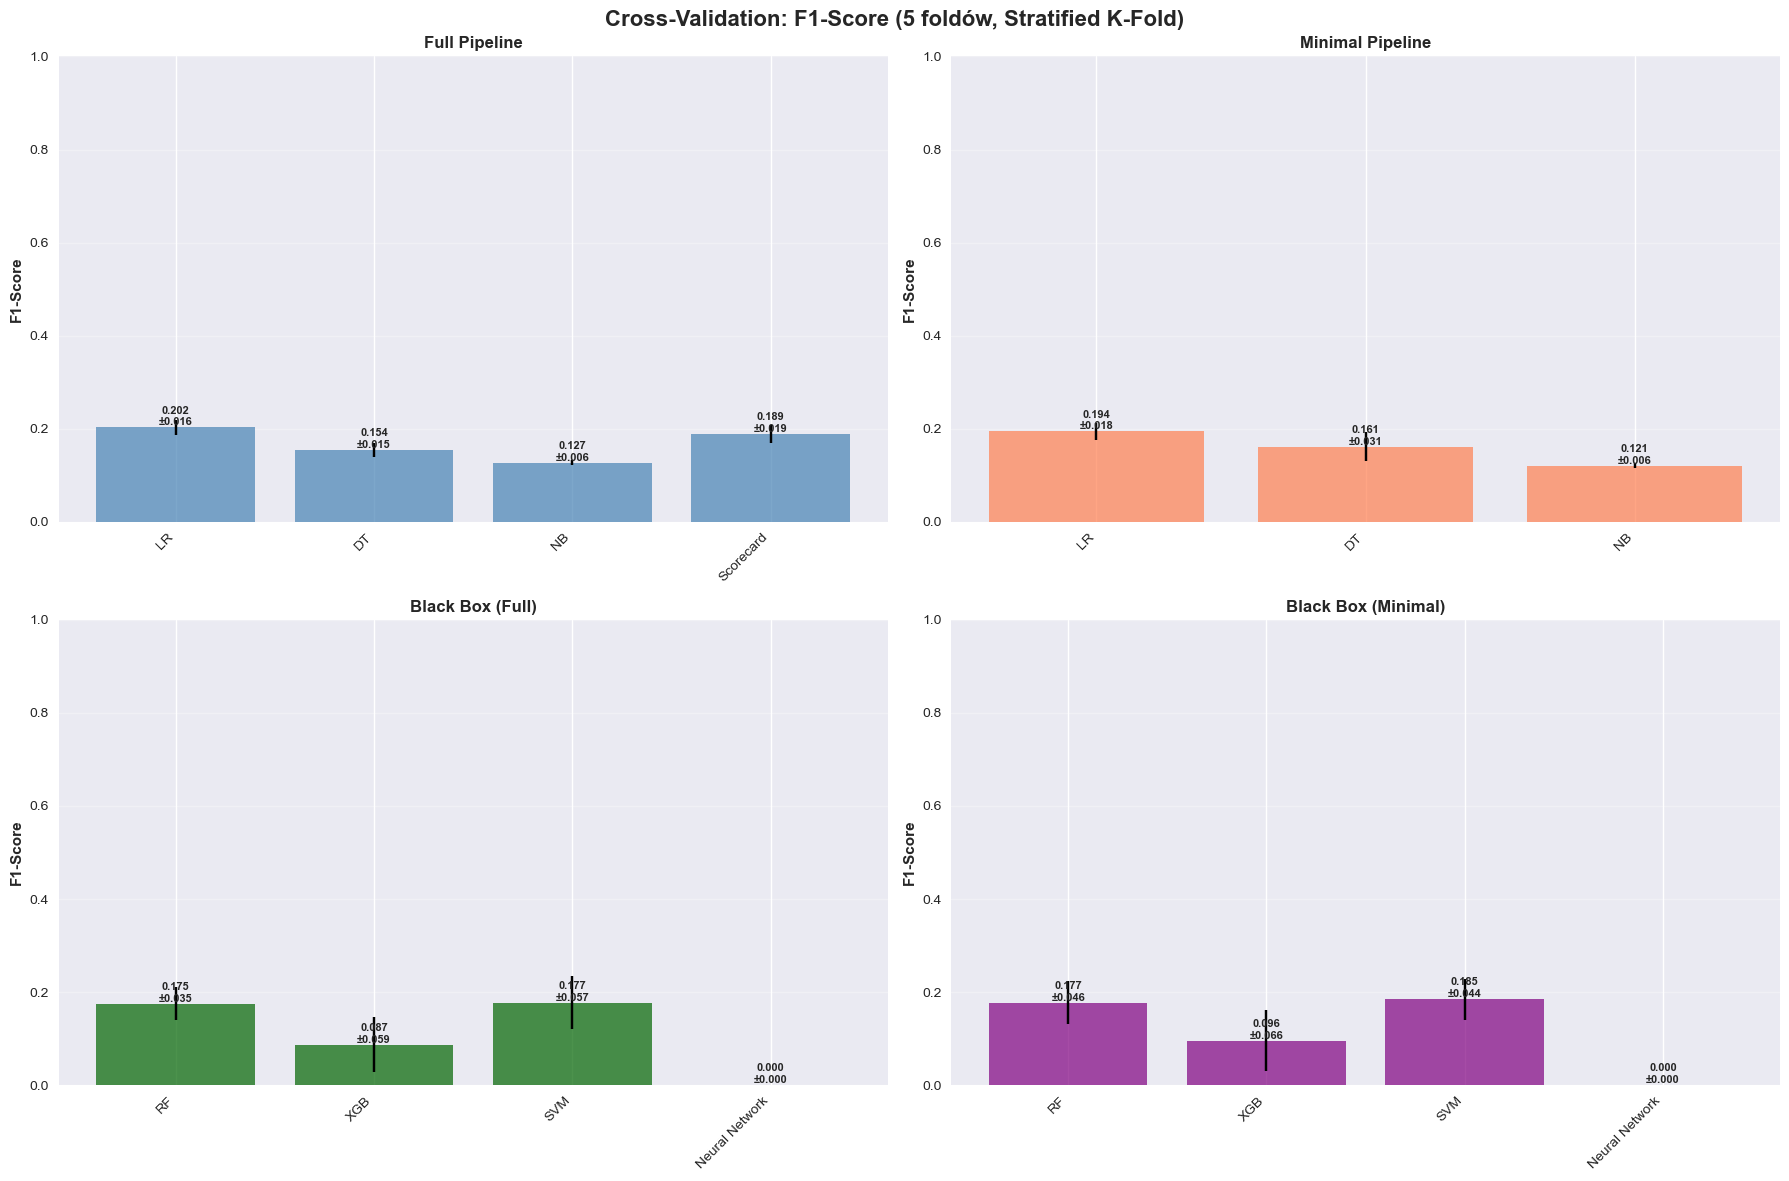


📈 Podsumowanie Cross-Validation:

Full Pipeline:
  Średnia F1-Score (wszystkie modele): 0.1680
  Najlepszy model: LR (0.2024 ± 0.0164)

Minimal Pipeline:
  Średnia F1-Score (wszystkie modele): 0.1586
  Najlepszy model: LR (0.1939 ± 0.0177)

Black Box (Full):
  Średnia F1-Score (wszystkie modele): 0.1098
  Najlepszy model: SVM (0.1766 ± 0.0569)

Black Box (Minimal):
  Średnia F1-Score (wszystkie modele): 0.1143
  Najlepszy model: SVM (0.1849 ± 0.0441)



In [136]:
# Przygotowanie danych do wizualizacji
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Cross-Validation: F1-Score (5 foldów, Stratified K-Fold)', fontsize=16, fontweight='bold')

pipeline_configs = [
    ('Full Pipeline', cv_results['Full Pipeline'], axes[0, 0], 'steelblue'),
    ('Minimal Pipeline', cv_results['Minimal Pipeline'], axes[0, 1], 'coral'),
    ('Black Box (Full)', cv_results['Black Box (Full)'], axes[1, 0], 'darkgreen'),
    ('Black Box (Minimal)', cv_results['Black Box (Minimal)'], axes[1, 1], 'purple')
]

for pipeline_name, results, ax, color in pipeline_configs:
    model_names = list(results.keys())
    means = [results[m]['mean'] for m in model_names]
    stds = [results[m]['std'] for m in model_names]
    
    x_pos = np.arange(len(model_names))
    bars = ax.bar(x_pos, means, yerr=stds, alpha=0.7, color=color, capsize=5, ecolor='black')
    
    ax.set_ylabel('F1-Score', fontweight='bold')
    ax.set_title(pipeline_name, fontweight='bold', fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)
    
    # Dodaj wartości na słupkach
    for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{mean:.3f}\n±{std:.3f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# Podsumowanie statystyk
print("\n📈 Podsumowanie Cross-Validation:")
print("="*110)

for pipeline_name in ['Full Pipeline', 'Minimal Pipeline', 'Black Box (Full)', 'Black Box (Minimal)']:
    results = cv_results[pipeline_name]
    if results:
        avg_mean = np.mean([results[m]['mean'] for m in results.keys()])
        print(f"\n{pipeline_name}:")
        print(f"  Średnia F1-Score (wszystkie modele): {avg_mean:.4f}")
        best_model = max(results.keys(), key=lambda m: results[m]['mean'])
        print(f"  Najlepszy model: {best_model} ({results[best_model]['mean']:.4f} ± {results[best_model]['std']:.4f})")

print("\n" + "="*110)

## 9. Tabela Porównawcza

In [137]:
# Przygotowanie danych do porównania
comparison_data = []

for model_name in results_full.keys():
    # Full pipeline
    comparison_data.append({
        'Pipeline': 'Full',
        'Model': model_name,
        'Accuracy': results_full[model_name]['accuracy'],
        'Precision': results_full[model_name]['precision'],
        'Recall': results_full[model_name]['recall'],
        'F1-Score': results_full[model_name]['f1'],
        'ROC-AUC': results_full[model_name]['auc']
    })
    
    # Minimal pipeline
    if model_name in results_minimal:
        comparison_data.append({
            'Pipeline': 'Minimal',
            'Model': model_name,
            'Accuracy': results_minimal[model_name]['accuracy'],
            'Precision': results_minimal[model_name]['precision'],
            'Recall': results_minimal[model_name]['recall'],
            'F1-Score': results_minimal[model_name]['f1'],
            'ROC-AUC': results_minimal[model_name]['auc']
        })

# Dodaj modele black box (Full Pipeline)
for model_name in results_blackbox_full.keys():
    comparison_data.append({
        'Pipeline': 'Black Box (Full)',
        'Model': model_name,
        'Accuracy': results_blackbox_full[model_name]['accuracy'],
        'Precision': results_blackbox_full[model_name]['precision'],
        'Recall': results_blackbox_full[model_name]['recall'],
        'F1-Score': results_blackbox_full[model_name]['f1'],
        'ROC-AUC': results_blackbox_full[model_name]['auc']
    })

# Dodaj modele black box (Minimal Pipeline)
for model_name in results_blackbox.keys():
    comparison_data.append({
        'Pipeline': 'Black Box (Minimal)',
        'Model': model_name,
        'Accuracy': results_blackbox[model_name]['accuracy'],
        'Precision': results_blackbox[model_name]['precision'],
        'Recall': results_blackbox[model_name]['recall'],
        'F1-Score': results_blackbox[model_name]['f1'],
        'ROC-AUC': results_blackbox[model_name]['auc']
    })

comparison_df = pd.DataFrame(comparison_data)

print("="*110)
print("PORÓWNANIE WSZYSTKICH MODELI - FULL vs MINIMAL vs BLACK BOX (Full & Minimal)")
print("="*110)
print()
print(comparison_df.to_string(index=False))
print()
print(f"\n🔢 Liczba cech:")
print(f"   Full Pipeline:         {X_train_full.shape[1]} cech")
print(f"   Minimal Pipeline:      {X_train_minimal.shape[1]} cech")
print(f"   Black Box (Full):      {X_train_full.shape[1]} cech (używa Full Pipeline)")
print(f"   Black Box (Minimal):   {X_train_minimal.shape[1]} cech (używa Minimal Pipeline)")

PORÓWNANIE WSZYSTKICH MODELI - FULL vs MINIMAL vs BLACK BOX (Full & Minimal)

           Pipeline          Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
               Full             LR  0.747778   0.116071 0.472727  0.186380 0.686584
            Minimal             LR  0.766667   0.132701 0.509091  0.210526 0.689446
               Full             DT  0.591111   0.099744 0.709091  0.174888 0.672523
            Minimal             DT  0.478889   0.089286 0.818182  0.161002 0.672544
               Full             NB  0.278889   0.065789 0.818182  0.121786 0.533771
            Minimal             NB  0.335556   0.064205 0.727273  0.117994 0.534363
               Full      Scorecard  0.675556   0.130841 0.763636  0.223404 0.771060
   Black Box (Full)             RF  0.847778   0.163934 0.363636  0.225989 0.770737
   Black Box (Full)            XGB  0.921111   0.192308 0.090909  0.123457 0.741861
   Black Box (Full)            SVM  0.815556   0.132450 0.363636  0.194175 0.69443

## 10. Wizualizacje Porównawcze

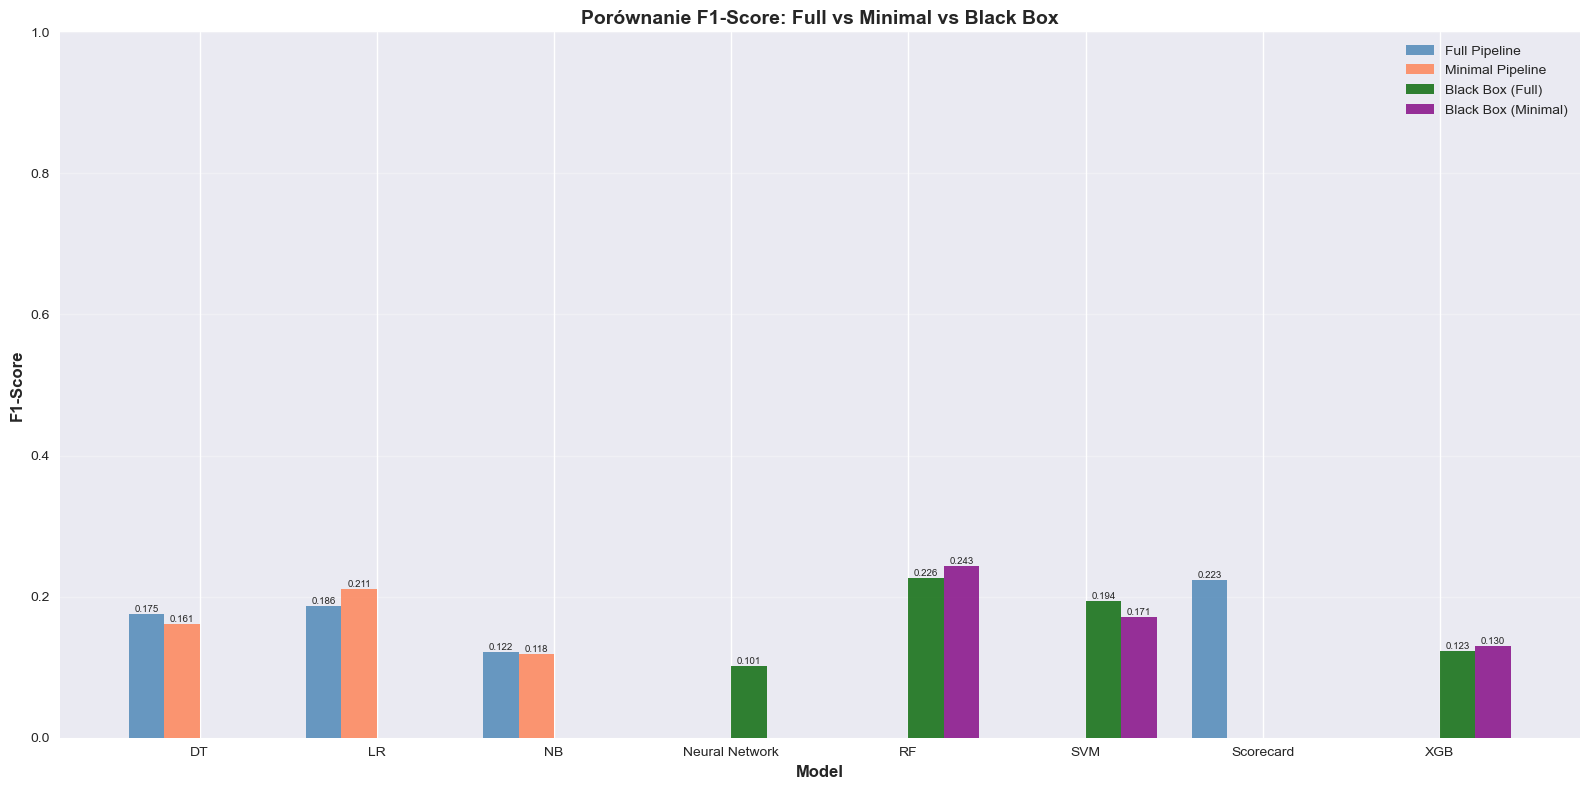


📈 Średnie F1-Score:
   Full Pipeline (Interpretable):       0.1766
   Minimal Pipeline (Interpretable):    0.1632
   Black Box (Full Pipeline):           0.1612
   Black Box (Minimal Pipeline):        0.1360

📊 Różnice:
   Full vs Minimal:                     +0.0134
   Black Box (Full) vs Full:            -0.0154
   Black Box (Minimal) vs Minimal:      -0.0271

✅ Najlepszy średni wynik: Full (Interpretable) (0.1766)


In [138]:
# Wykres słupkowy F1-Score
fig, ax = plt.subplots(figsize=(16, 8))

# Przygotuj dane - wszystkie unikalne modele
all_model_names = sorted(set(list(results_full.keys()) + list(results_blackbox_full.keys()) + list(results_blackbox.keys())))

full_f1s = [results_full[m]['f1'] if m in results_full else 0 for m in all_model_names]
minimal_f1s = [results_minimal[m]['f1'] if m in results_minimal else 0 for m in all_model_names]
blackbox_full_f1s = [results_blackbox_full[m]['f1'] if m in results_blackbox_full else 0 for m in all_model_names]
blackbox_minimal_f1s = [results_blackbox[m]['f1'] if m in results_blackbox else 0 for m in all_model_names]

x = np.arange(len(all_model_names))
width = 0.2

bars1 = ax.bar(x - 1.5*width, full_f1s, width, label='Full Pipeline', color='steelblue', alpha=0.8)
bars2 = ax.bar(x - 0.5*width, minimal_f1s, width, label='Minimal Pipeline', color='coral', alpha=0.8)
bars3 = ax.bar(x + 0.5*width, blackbox_full_f1s, width, label='Black Box (Full)', color='darkgreen', alpha=0.8)
bars4 = ax.bar(x + 1.5*width, blackbox_minimal_f1s, width, label='Black Box (Minimal)', color='purple', alpha=0.8)

ax.set_xlabel('Model', fontweight='bold', fontsize=12)
ax.set_ylabel('F1-Score', fontweight='bold', fontsize=12)
ax.set_title('Porównanie F1-Score: Full vs Minimal vs Black Box', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(all_model_names)
ax.legend(fontsize=10, loc='best')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.0, 1.0])

# Wartości na słupkach
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        if height > 0.01:  # Tylko dla niepustych słupków
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=7, rotation=0)

plt.tight_layout()
plt.show()

# Statystyki
interpretable_f1s = [results_full[m]['f1'] for m in results_full.keys()]
minimal_all_f1s = [results_minimal[m]['f1'] for m in results_minimal.keys()]
blackbox_full_all_f1s = [results_blackbox_full[m]['f1'] for m in results_blackbox_full.keys()]
blackbox_minimal_all_f1s = [results_blackbox[m]['f1'] for m in results_blackbox.keys()]

avg_full = np.mean(interpretable_f1s)
avg_minimal = np.mean(minimal_all_f1s)
avg_blackbox_full = np.mean(blackbox_full_all_f1s) if blackbox_full_all_f1s else 0
avg_blackbox_minimal = np.mean(blackbox_minimal_all_f1s) if blackbox_minimal_all_f1s else 0

print(f"\n📈 Średnie F1-Score:")
print(f"   Full Pipeline (Interpretable):       {avg_full:.4f}")
print(f"   Minimal Pipeline (Interpretable):    {avg_minimal:.4f}")
if blackbox_full_all_f1s:
    print(f"   Black Box (Full Pipeline):           {avg_blackbox_full:.4f}")
if blackbox_minimal_all_f1s:
    print(f"   Black Box (Minimal Pipeline):        {avg_blackbox_minimal:.4f}")

print(f"\n📊 Różnice:")
print(f"   Full vs Minimal:                     {avg_full - avg_minimal:+.4f}")
if blackbox_full_all_f1s:
    print(f"   Black Box (Full) vs Full:            {avg_blackbox_full - avg_full:+.4f}")
if blackbox_minimal_all_f1s:
    print(f"   Black Box (Minimal) vs Minimal:      {avg_blackbox_minimal - avg_minimal:+.4f}")

# Najlepszy model
pipelines_to_compare = [
    ('Full (Interpretable)', avg_full),
    ('Minimal (Interpretable)', avg_minimal),
]
if blackbox_full_all_f1s:
    pipelines_to_compare.append(('Black Box (Full)', avg_blackbox_full))
if blackbox_minimal_all_f1s:
    pipelines_to_compare.append(('Black Box (Minimal)', avg_blackbox_minimal))

best_pipeline = max(pipelines_to_compare, key=lambda x: x[1])

print(f"\n✅ Najlepszy średni wynik: {best_pipeline[0]} ({best_pipeline[1]:.4f})")

## 11. Wnioski

**Porównanie zostało zakończone!**

Ten notebook porównał cztery kategorie modeli:
- **Full Pipeline (Interpretable)**: LR, DT, NB z pełnymi transformacjami statystycznymi
- **Minimal Pipeline (Interpretable)**: LR, DT, NB z minimalnym preprocessingiem
- **Black Box (Full Pipeline)**: Random Forest, XGBoost, SVM i Neural Network z pełnymi transformacjami
- **Black Box (Minimal Pipeline)**: Random Forest, XGBoost, SVM i Neural Network z minimalnym preprocessingiem

Sprawdź wyniki powyżej, aby określić:
1. Czy złożone transformacje poprawiają wyniki modeli interpretowalnych
2. Jak modele black box wypadają w porównaniu do modeli interpretowalnych
3. Czy black box modele bardziej korzystają z Full czy Minimal Pipeline
4. Która strategia oferuje najlepszy kompromis między interpretowalnością a wydajnością
5. Jak cross-validation potwierdza stabilność wyników modeli

## 12. Feature Importance z SHAP (Full Pipeline: LR, DT, RF)

Analiza ważności cech przy użyciu biblioteki SHAP dla pełnego pipeline'u.

In [139]:
# SHAP Full Pipeline (LR, DT, RF)
print("="*100)
print("SHAP Feature Importance - Full Pipeline (LR, DT, RF)")
print("="*100)

try:
    import shap
    SHAP_AVAILABLE_FULL = True
except ImportError:
    SHAP_AVAILABLE_FULL = False
    print("⚠️  Brak biblioteki 'shap' (pip install shap)")

full_top30_features = []
shap_full_df = None

if SHAP_AVAILABLE_FULL:
    # Przygotowanie losowej próbki danych treningowych
    sample_size = min(1000, len(X_train_full))
    X_sample_full = X_train_full.sample(n=sample_size, random_state=42)
    
    shap_results_full = []
    
    # 1. LOGISTIC REGRESSION (Full)
    print("\n[1/3] Obliczanie SHAP dla Logistic Regression (Full)...")
    explainer_lr_full = shap.LinearExplainer(lr_full, X_sample_full)
    shap_values_lr_full = explainer_lr_full.shap_values(X_sample_full)
    
    # Jeśli jest to klasyfikacja binarna i shap_values to lista
    if type(shap_values_lr_full) == list:
        shap_values_lr_full = shap_values_lr_full[1]
    
    shap_abs_mean_lr_full = np.abs(shap_values_lr_full).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_full.columns):
        shap_results_full.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_lr_full[i],
            'model': 'LR'
        })
    
    # 2. DECISION TREE (Full)
    print("[2/3] Obliczanie SHAP dla Decision Tree (Full)...")
    explainer_dt_full = shap.TreeExplainer(dt_full)
    shap_values_dt_full = explainer_dt_full.shap_values(X_sample_full)
    
    if type(shap_values_dt_full) == list:
        shap_values_dt_full = shap_values_dt_full[1]
    
    shap_abs_mean_dt_full = np.abs(shap_values_dt_full).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_full.columns):
        shap_results_full.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_dt_full[i],
            'model': 'DT'
        })
    
    # 3. RANDOM FOREST (Full)
    print("[3/3] Obliczanie SHAP dla Random Forest (Full)...")
    explainer_rf_full = shap.TreeExplainer(rf_blackbox_full)
    shap_values_rf_full = explainer_rf_full.shap_values(X_sample_full)
    
    if type(shap_values_rf_full) == list:
        shap_values_rf_full = shap_values_rf_full[1]
    
    shap_abs_mean_rf_full = np.abs(shap_values_rf_full).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_full.columns):
        shap_results_full.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_rf_full[i],
            'model': 'RF'
        })
    
    # Agregacja wyników - średnia z LR, DT i RF
    shap_full_df = pd.DataFrame(shap_results_full)
    shap_full_agg = shap_full_df.groupby('feature')['SHAP_mean'].mean().reset_index()
    print(shap_full_agg['SHAP_mean'].head())

    shap_full_agg['SHAP_mean'] = shap_full_agg['SHAP_mean'].apply(
        lambda x: float(np.mean(x)) if isinstance(x, (list, np.ndarray)) else float(x)
    )
    shap_full_agg = shap_full_agg.sort_values('SHAP_mean', ascending=False)
    
    full_top30_features = shap_full_agg.head(30)['feature'].tolist()
    
    print("\n✅ Obliczenia SHAP zakończone (Full Pipeline).")
    print(f"Top 30 cech: {len(full_top30_features)} cech wybranych.")
else:
    print("⚠️ SHAP niedostępny - pomiń ten krok lub zainstaluj: pip install shap")

SHAP Feature Importance - Full Pipeline (LR, DT, RF)

[1/3] Obliczanie SHAP dla Logistic Regression (Full)...
[2/3] Obliczanie SHAP dla Decision Tree (Full)...
[3/3] Obliczanie SHAP dla Random Forest (Full)...
0       [0.2001306959854191, 0.2001306959854191]
1     [0.06999270640832954, 0.06999270640832954]
2    [0.05896821454755943, 0.058968214547559246]
3     [0.03984365402834628, 0.03984365402834628]
4     [0.03446140273358141, 0.03446140273358141]
Name: SHAP_mean, dtype: object

✅ Obliczenia SHAP zakończone (Full Pipeline).
Top 30 cech: 30 cech wybranych.
0       [0.2001306959854191, 0.2001306959854191]
1     [0.06999270640832954, 0.06999270640832954]
2    [0.05896821454755943, 0.058968214547559246]
3     [0.03984365402834628, 0.03984365402834628]
4     [0.03446140273358141, 0.03446140273358141]
Name: SHAP_mean, dtype: object

✅ Obliczenia SHAP zakończone (Full Pipeline).
Top 30 cech: 30 cech wybranych.


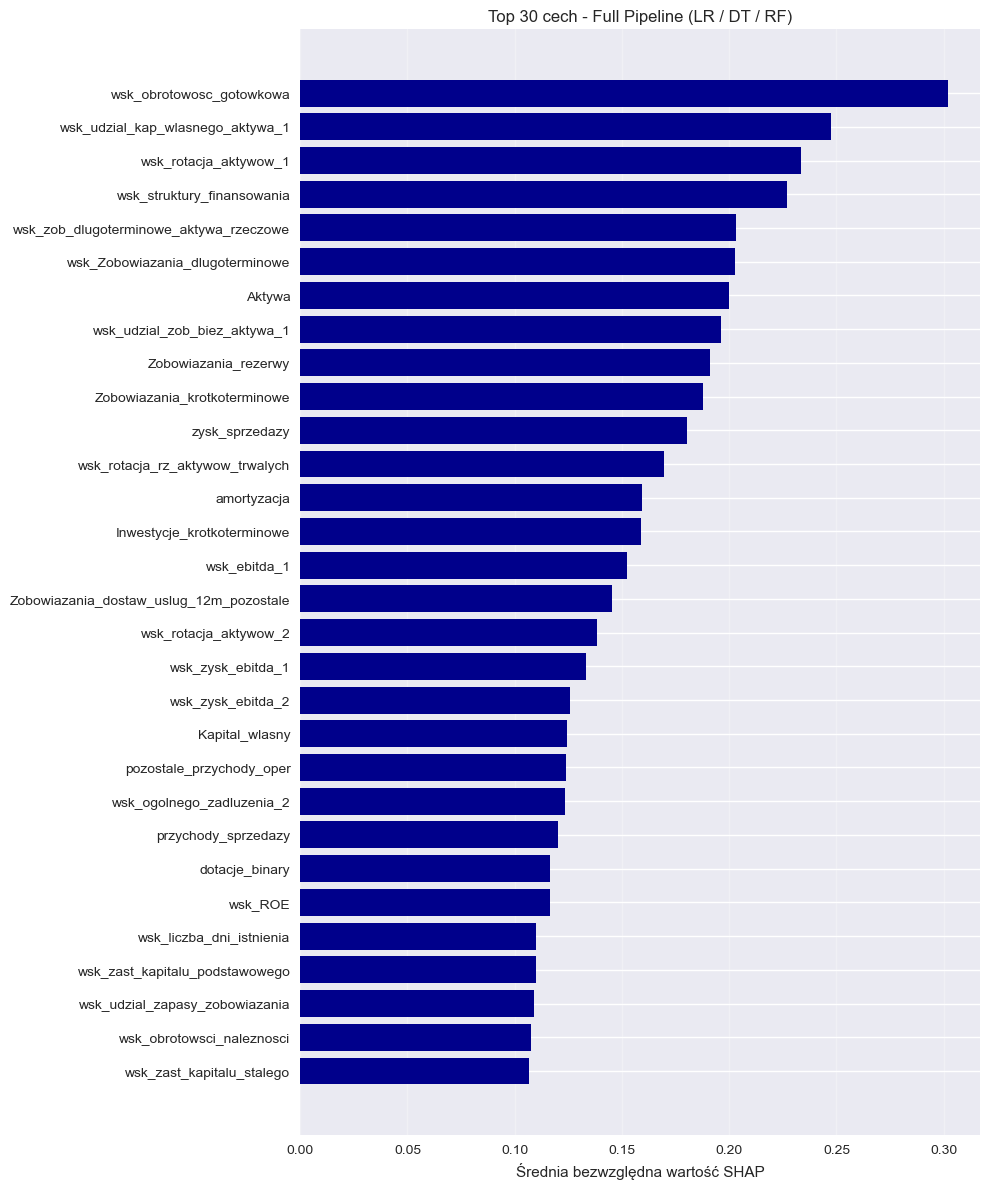

In [140]:
# Wykres Top 30 Full Pipeline
if shap_full_df is not None and len(full_top30_features) > 0:
    plot_df_full = shap_full_agg.head(30)
    plt.figure(figsize=(10,12))
    plt.barh(plot_df_full['feature'][::-1], plot_df_full['SHAP_mean'][::-1], color='darkblue')
    plt.xlabel('Średnia bezwzględna wartość SHAP')
    plt.title('Top 30 cech - Full Pipeline (LR / DT / RF)')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ Brak danych do wykresu Full Pipeline SHAP.')

## 13. Feature Importance z SHAP (Minimal Pipeline: LR, DT, RF)

Analiza ważności cech przy użyciu biblioteki SHAP dla minimalnego pipeline'u.

In [141]:
# SHAP Minimal Pipeline (LR, DT, RF)
print("="*100)
print("SHAP Feature Importance - Minimal Pipeline (LR, DT, RF)")
print("="*100)

try:
    import shap
    SHAP_AVAILABLE_MIN = True
except ImportError:
    SHAP_AVAILABLE_MIN = False
    print("⚠️  Brak biblioteki 'shap' (pip install shap)")

minimal_top30_features = []
shap_min_df = None

if SHAP_AVAILABLE_MIN:
    # Przygotowanie losowej próbki danych treningowych
    sample_size = min(1000, len(X_train_minimal))
    X_sample_min = X_train_minimal.sample(n=sample_size, random_state=42)
    
    shap_results_min = []
    
    # 1. LOGISTIC REGRESSION (Minimal)
    print("\n[1/3] Obliczanie SHAP dla Logistic Regression (Minimal)...")
    explainer_lr_min = shap.LinearExplainer(lr_minimal, X_sample_min)
    shap_values_lr_min = explainer_lr_min.shap_values(X_sample_min)
    
    # Jeśli jest to klasyfikacja binarna i shap_values to lista
    if type(shap_values_lr_min) == list:
        shap_values_lr_min = shap_values_lr_min[1]
    
    shap_abs_mean_lr_min = np.abs(shap_values_lr_min).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_min.columns):
        shap_results_min.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_lr_min[i],
            'model': 'LR'
        })
    
    # 2. DECISION TREE (Minimal)
    print("[2/3] Obliczanie SHAP dla Decision Tree (Minimal)...")
    explainer_dt_min = shap.TreeExplainer(dt_minimal)
    shap_values_dt_min = explainer_dt_min.shap_values(X_sample_min)
    
    if type(shap_values_dt_min) == list:
        shap_values_dt_min = shap_values_dt_min[1]
    
    shap_abs_mean_dt_min = np.abs(shap_values_dt_min).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_min.columns):
        shap_results_min.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_dt_min[i],
            'model': 'DT'
        })
    
    # 3. RANDOM FOREST (Minimal)
    print("[3/3] Obliczanie SHAP dla Random Forest (Minimal)...")
    explainer_rf_min = shap.TreeExplainer(rf_blackbox)
    shap_values_rf_min = explainer_rf_min.shap_values(X_sample_min)
    
    if type(shap_values_rf_min) == list:
        shap_values_rf_min = shap_values_rf_min[1]
    
    shap_abs_mean_rf_min = np.abs(shap_values_rf_min).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_min.columns):
        shap_results_min.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_rf_min[i],
            'model': 'RF'
        })
    
    # Agregacja wyników - średnia z LR, DT i RF
    shap_min_df = pd.DataFrame(shap_results_min)
    shap_min_agg = shap_min_df.groupby('feature')['SHAP_mean'].mean().reset_index()
    shap_min_agg['SHAP_mean'] = shap_min_agg['SHAP_mean'].apply(
    lambda x: float(np.mean(x)) if isinstance(x, (list, np.ndarray)) else float(x)
)
    shap_min_agg = shap_min_agg.sort_values('SHAP_mean', ascending=False)
    
    minimal_top30_features = shap_min_agg.head(30)['feature'].tolist()
    
    print("\n✅ Obliczenia SHAP zakończone (Minimal Pipeline).")
    print(f"Top 30 cech: {len(minimal_top30_features)} cech wybranych.")
else:
    print("⚠️ SHAP niedostępny - pomiń ten krok lub zainstaluj: pip install shap")

SHAP Feature Importance - Minimal Pipeline (LR, DT, RF)

[1/3] Obliczanie SHAP dla Logistic Regression (Minimal)...
[2/3] Obliczanie SHAP dla Decision Tree (Minimal)...
[3/3] Obliczanie SHAP dla Random Forest (Minimal)...

✅ Obliczenia SHAP zakończone (Minimal Pipeline).
Top 30 cech: 30 cech wybranych.

✅ Obliczenia SHAP zakończone (Minimal Pipeline).
Top 30 cech: 30 cech wybranych.


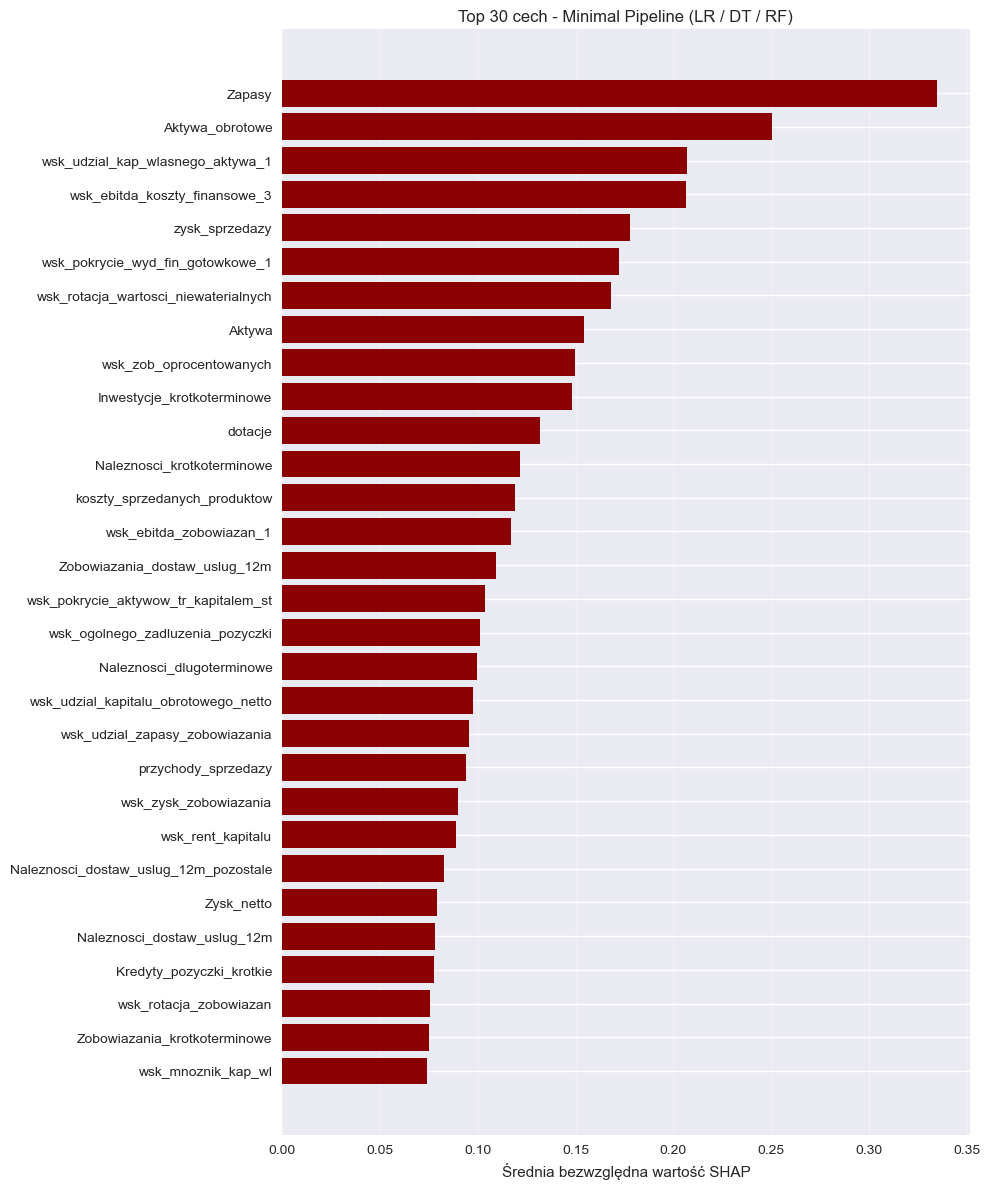

In [142]:
# Wykres Top 30 Minimal Pipeline
if shap_min_df is not None and len(minimal_top30_features) > 0:
    plot_df_min = shap_min_agg.head(30)
    plt.figure(figsize=(10,12))
    plt.barh(plot_df_min['feature'][::-1], plot_df_min['SHAP_mean'][::-1], color='darkred')
    plt.xlabel('Średnia bezwzględna wartość SHAP')
    plt.title('Top 30 cech - Minimal Pipeline (LR / DT / RF)')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ Brak danych do wykresu Minimal Pipeline SHAP.')

## 14. Modele na Top 30 cechach (Full Pipeline)

Trening modeli Logistic Regression, Decision Tree i Random Forest na 30 najważniejszych cechach wybranych przez SHAP dla pełnego pipeline'u.

In [143]:
# Modele na Top 30 cechach - Full Pipeline
print("="*100)
print("TRENOWANIE MODELI NA TOP 30 CECHACH - FULL PIPELINE")
print("="*100)

if len(full_top30_features) > 0:
    # Wybór tylko top 30 cech
    X_train_full_top30 = X_train_full[full_top30_features]
    X_test_full_top30 = X_test_full[full_top30_features]
    
    print(f"\nWybrano {len(full_top30_features)} cech z {X_train_full.shape[1]} dostępnych.")
    print(f"Kształt danych treningowych: {X_train_full_top30.shape}")
    print(f"Kształt danych testowych: {X_test_full_top30.shape}")
    
    results_full_top30 = {}
    
    # 1. LOGISTIC REGRESSION
    print("\n[1/3] Trening Logistic Regression na Top 30 cechach (Full)...")
    lr_full_top30 = LogisticRegression(max_iter=1000, random_state=42)
    lr_full_top30.fit(X_train_full_top30, y_train)
    y_pred_lr_full_top30 = lr_full_top30.predict(X_test_full_top30)
    y_proba_lr_full_top30 = lr_full_top30.predict_proba(X_test_full_top30)[:, 1]
    
    results_full_top30['LR'] = {
        'model': lr_full_top30,
        'y_pred': y_pred_lr_full_top30,
        'y_proba': y_proba_lr_full_top30,
        'accuracy': accuracy_score(y_test, y_pred_lr_full_top30),
        'precision': precision_score(y_test, y_pred_lr_full_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_lr_full_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_lr_full_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_lr_full_top30)
    }
    print(f"  ✓ F1-Score: {results_full_top30['LR']['f1']:.4f}")
    
    # 2. DECISION TREE
    print("[2/3] Trening Decision Tree na Top 30 cechach (Full)...")
    dt_full_top30 = DecisionTreeClassifier(max_depth=5, min_samples_split=100, random_state=42)
    dt_full_top30.fit(X_train_full_top30, y_train)
    y_pred_dt_full_top30 = dt_full_top30.predict(X_test_full_top30)
    y_proba_dt_full_top30 = dt_full_top30.predict_proba(X_test_full_top30)[:, 1]
    
    results_full_top30['DT'] = {
        'model': dt_full_top30,
        'y_pred': y_pred_dt_full_top30,
        'y_proba': y_proba_dt_full_top30,
        'accuracy': accuracy_score(y_test, y_pred_dt_full_top30),
        'precision': precision_score(y_test, y_pred_dt_full_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_dt_full_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_dt_full_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_dt_full_top30)
    }
    print(f"  ✓ F1-Score: {results_full_top30['DT']['f1']:.4f}")
    
    # 3. RANDOM FOREST
    print("[3/3] Trening Random Forest na Top 30 cechach (Full)...")
    rf_full_top30 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=50, random_state=42)
    rf_full_top30.fit(X_train_full_top30, y_train)
    y_pred_rf_full_top30 = rf_full_top30.predict(X_test_full_top30)
    y_proba_rf_full_top30 = rf_full_top30.predict_proba(X_test_full_top30)[:, 1]
    
    results_full_top30['RF'] = {
        'model': rf_full_top30,
        'y_pred': y_pred_rf_full_top30,
        'y_proba': y_proba_rf_full_top30,
        'accuracy': accuracy_score(y_test, y_pred_rf_full_top30),
        'precision': precision_score(y_test, y_pred_rf_full_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_rf_full_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_rf_full_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_rf_full_top30)
    }
    print(f"  ✓ F1-Score: {results_full_top30['RF']['f1']:.4f}")
    
    # PODSUMOWANIE WYNIKÓW
    print("\n" + "="*100)
    print("PODSUMOWANIE WYNIKÓW - FULL PIPELINE TOP 30")
    print("="*100)
    print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'ROC-AUC':<12}")
    print("-"*100)
    
    for model_name, metrics in results_full_top30.items():
        print(f"{model_name:<20} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} "
              f"{metrics['recall']:<12.4f} {metrics['f1']:<12.4f} {metrics['roc_auc']:<12.4f}")
    
    print("\n✅ Trenowanie modeli na Top 30 cechach (Full Pipeline) zakończone.")
else:
    print("⚠️ Brak wybranych cech Top 30 dla Full Pipeline.")

TRENOWANIE MODELI NA TOP 30 CECHACH - FULL PIPELINE

Wybrano 30 cech z 157 dostępnych.
Kształt danych treningowych: (2100, 30)
Kształt danych testowych: (900, 30)

[1/3] Trening Logistic Regression na Top 30 cechach (Full)...
  ✓ F1-Score: 0.0000
[2/3] Trening Decision Tree na Top 30 cechach (Full)...
  ✓ F1-Score: 0.0000
[3/3] Trening Random Forest na Top 30 cechach (Full)...
  ✓ F1-Score: 0.0000

PODSUMOWANIE WYNIKÓW - FULL PIPELINE TOP 30
Model                Accuracy     Precision    Recall       F1-Score     ROC-AUC     
----------------------------------------------------------------------------------------------------
LR                   0.9378       0.0000       0.0000       0.0000       0.6845      
DT                   0.9378       0.0000       0.0000       0.0000       0.7045      
RF                   0.9389       0.0000       0.0000       0.0000       0.7589      

✅ Trenowanie modeli na Top 30 cechach (Full Pipeline) zakończone.
  ✓ F1-Score: 0.0000

PODSUMOWANIE WYNIKÓW

## 15. Modele na Top 30 cechach (Minimal Pipeline)

Trening modeli Logistic Regression, Decision Tree i Random Forest na 30 najważniejszych cechach wybranych przez SHAP dla minimalnego pipeline'u.

In [144]:
# Modele na Top 30 cechach - Minimal Pipeline
print("="*100)
print("TRENOWANIE MODELI NA TOP 30 CECHACH - MINIMAL PIPELINE")
print("="*100)

if len(minimal_top30_features) > 0:
    # Wybór tylko top 30 cech
    X_train_minimal_top30 = X_train_minimal[minimal_top30_features]
    X_test_minimal_top30 = X_test_minimal[minimal_top30_features]
    
    print(f"\nWybrano {len(minimal_top30_features)} cech z {X_train_minimal.shape[1]} dostępnych.")
    print(f"Kształt danych treningowych: {X_train_minimal_top30.shape}")
    print(f"Kształt danych testowych: {X_test_minimal_top30.shape}")
    
    results_minimal_top30 = {}
    
    # 1. LOGISTIC REGRESSION
    print("\n[1/3] Trening Logistic Regression na Top 30 cechach (Minimal)...")
    lr_minimal_top30 = LogisticRegression(max_iter=1000, random_state=42)
    lr_minimal_top30.fit(X_train_minimal_top30, y_train)
    y_pred_lr_minimal_top30 = lr_minimal_top30.predict(X_test_minimal_top30)
    y_proba_lr_minimal_top30 = lr_minimal_top30.predict_proba(X_test_minimal_top30)[:, 1]
    
    results_minimal_top30['LR'] = {
        'model': lr_minimal_top30,
        'y_pred': y_pred_lr_minimal_top30,
        'y_proba': y_proba_lr_minimal_top30,
        'accuracy': accuracy_score(y_test, y_pred_lr_minimal_top30),
        'precision': precision_score(y_test, y_pred_lr_minimal_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_lr_minimal_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_lr_minimal_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_lr_minimal_top30)
    }
    print(f"  ✓ F1-Score: {results_minimal_top30['LR']['f1']:.4f}")
    
    # 2. DECISION TREE
    print("[2/3] Trening Decision Tree na Top 30 cechach (Minimal)...")
    dt_minimal_top30 = DecisionTreeClassifier(max_depth=5, min_samples_split=100, random_state=42)
    dt_minimal_top30.fit(X_train_minimal_top30, y_train)
    y_pred_dt_minimal_top30 = dt_minimal_top30.predict(X_test_minimal_top30)
    y_proba_dt_minimal_top30 = dt_minimal_top30.predict_proba(X_test_minimal_top30)[:, 1]
    
    results_minimal_top30['DT'] = {
        'model': dt_minimal_top30,
        'y_pred': y_pred_dt_minimal_top30,
        'y_proba': y_proba_dt_minimal_top30,
        'accuracy': accuracy_score(y_test, y_pred_dt_minimal_top30),
        'precision': precision_score(y_test, y_pred_dt_minimal_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_dt_minimal_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_dt_minimal_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_dt_minimal_top30)
    }
    print(f"  ✓ F1-Score: {results_minimal_top30['DT']['f1']:.4f}")
    
    # 3. RANDOM FOREST
    print("[3/3] Trening Random Forest na Top 30 cechach (Minimal)...")
    rf_minimal_top30 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=50, random_state=42)
    rf_minimal_top30.fit(X_train_minimal_top30, y_train)
    y_pred_rf_minimal_top30 = rf_minimal_top30.predict(X_test_minimal_top30)
    y_proba_rf_minimal_top30 = rf_minimal_top30.predict_proba(X_test_minimal_top30)[:, 1]
    
    results_minimal_top30['RF'] = {
        'model': rf_minimal_top30,
        'y_pred': y_pred_rf_minimal_top30,
        'y_proba': y_proba_rf_minimal_top30,
        'accuracy': accuracy_score(y_test, y_pred_rf_minimal_top30),
        'precision': precision_score(y_test, y_pred_rf_minimal_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_rf_minimal_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_rf_minimal_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_rf_minimal_top30)
    }
    print(f"  ✓ F1-Score: {results_minimal_top30['RF']['f1']:.4f}")
    
    # PODSUMOWANIE WYNIKÓW
    print("\n" + "="*100)
    print("PODSUMOWANIE WYNIKÓW - MINIMAL PIPELINE TOP 30")
    print("="*100)
    print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'ROC-AUC':<12}")
    print("-"*100)
    
    for model_name, metrics in results_minimal_top30.items():
        print(f"{model_name:<20} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} "
              f"{metrics['recall']:<12.4f} {metrics['f1']:<12.4f} {metrics['roc_auc']:<12.4f}")
    
    print("\n✅ Trenowanie modeli na Top 30 cechach (Minimal Pipeline) zakończone.")
else:
    print("⚠️ Brak wybranych cech Top 30 dla Minimal Pipeline.")

TRENOWANIE MODELI NA TOP 30 CECHACH - MINIMAL PIPELINE

Wybrano 30 cech z 125 dostępnych.
Kształt danych treningowych: (2100, 30)
Kształt danych testowych: (900, 30)

[1/3] Trening Logistic Regression na Top 30 cechach (Minimal)...
  ✓ F1-Score: 0.0328
[2/3] Trening Decision Tree na Top 30 cechach (Minimal)...
  ✓ F1-Score: 0.0635
[3/3] Trening Random Forest na Top 30 cechach (Minimal)...
  ✓ F1-Score: 0.0000

PODSUMOWANIE WYNIKÓW - MINIMAL PIPELINE TOP 30
Model                Accuracy     Precision    Recall       F1-Score     ROC-AUC     
----------------------------------------------------------------------------------------------------
LR                   0.9344       0.1667       0.0182       0.0328       0.6487      
DT                   0.9344       0.2500       0.0364       0.0635       0.6947      
RF                   0.9389       0.0000       0.0000       0.0000       0.7490      

✅ Trenowanie modeli na Top 30 cechach (Minimal Pipeline) zakończone.
  ✓ F1-Score: 0.0000

PO

## 16. Porównanie: Wszystkie cechy vs Top 30 cech

Wizualizacja porównująca wyniki modeli na wszystkich cechach z wynikami na Top 30 cechach wybranych przez SHAP.

PORÓWNANIE: WSZYSTKIE CECHY VS TOP 30 CECH


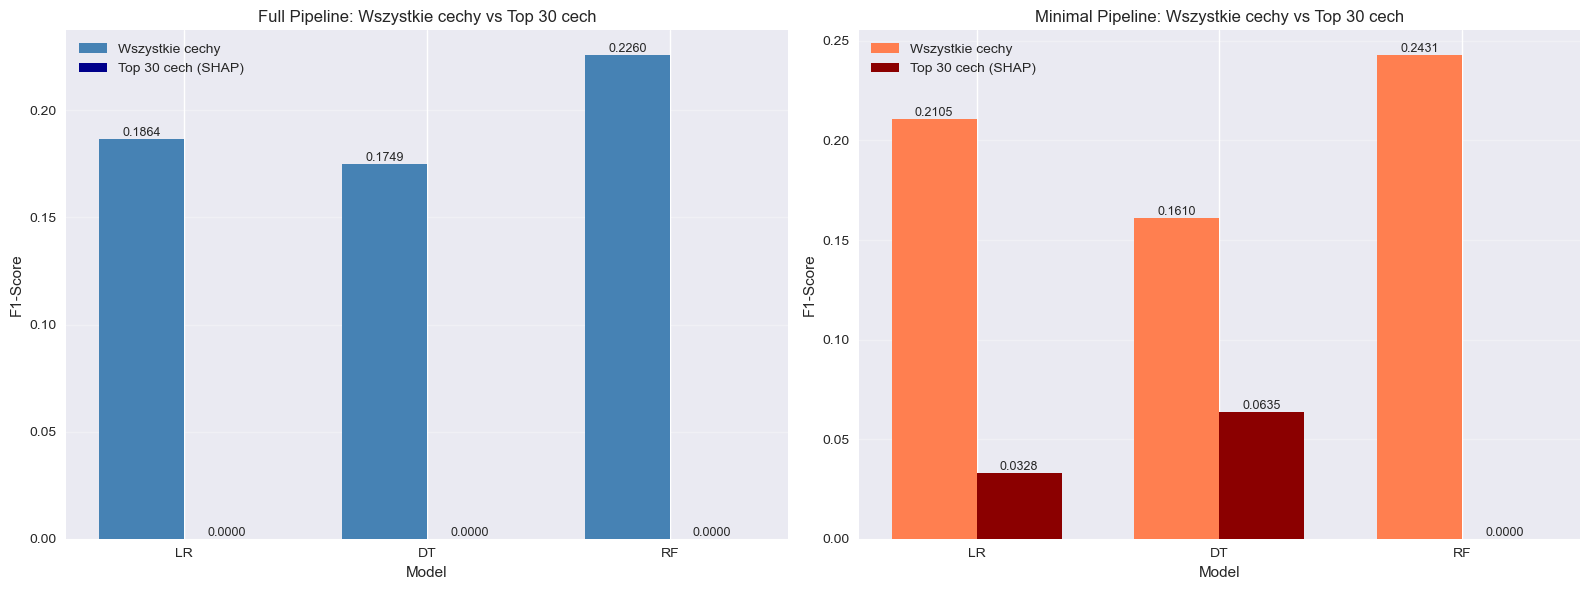


✅ Porównanie wyników zakończone.


In [145]:
# Porównanie wyników: Wszystkie cechy vs Top 30 cech
print("="*100)
print("PORÓWNANIE: WSZYSTKIE CECHY VS TOP 30 CECH")
print("="*100)

# Przygotowanie danych do porównania
comparison_data_top30 = []

# FULL PIPELINE
if len(full_top30_features) > 0:
    # Wszystkie cechy Full
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'All',
        'Model': 'LR',
        'F1-Score': results_full['LR']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'All',
        'Model': 'DT',
        'F1-Score': results_full['DT']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'All',
        'Model': 'RF',
        'F1-Score': results_blackbox_full['RF']['f1']
    })
    
    # Top 30 Full
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'Top30',
        'Model': 'LR',
        'F1-Score': results_full_top30['LR']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'Top30',
        'Model': 'DT',
        'F1-Score': results_full_top30['DT']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'Top30',
        'Model': 'RF',
        'F1-Score': results_full_top30['RF']['f1']
    })

# MINIMAL PIPELINE
if len(minimal_top30_features) > 0:
    # Wszystkie cechy Minimal
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'All',
        'Model': 'LR',
        'F1-Score': results_minimal['LR']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'All',
        'Model': 'DT',
        'F1-Score': results_minimal['DT']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'All',
        'Model': 'RF',
        'F1-Score': results_blackbox['RF']['f1']
    })
    
    # Top 30 Minimal
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'Top30',
        'Model': 'LR',
        'F1-Score': results_minimal_top30['LR']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'Top30',
        'Model': 'DT',
        'F1-Score': results_minimal_top30['DT']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'Top30',
        'Model': 'RF',
        'F1-Score': results_minimal_top30['RF']['f1']
    })

comparison_df_top30 = pd.DataFrame(comparison_data_top30)

# Wykres porównawczy
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Full Pipeline
full_data = comparison_df_top30[comparison_df_top30['Pipeline'] == 'Full']
x_labels = ['LR', 'DT', 'RF']
all_features_full = [full_data[(full_data['Model'] == m) & (full_data['Features'] == 'All')]['F1-Score'].values[0] 
                     for m in x_labels]
top30_features_full = [full_data[(full_data['Model'] == m) & (full_data['Features'] == 'Top30')]['F1-Score'].values[0] 
                       for m in x_labels]

x_pos = np.arange(len(x_labels))
width = 0.35

bars1 = axes[0].bar(x_pos - width/2, all_features_full, width, label='Wszystkie cechy', color='steelblue')
bars2 = axes[0].bar(x_pos + width/2, top30_features_full, width, label='Top 30 cech (SHAP)', color='darkblue')

axes[0].set_xlabel('Model')
axes[0].set_ylabel('F1-Score')
axes[0].set_title('Full Pipeline: Wszystkie cechy vs Top 30 cech')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(x_labels)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Dodanie wartości na słupkach
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Minimal Pipeline
minimal_data = comparison_df_top30[comparison_df_top30['Pipeline'] == 'Minimal']
all_features_minimal = [minimal_data[(minimal_data['Model'] == m) & (minimal_data['Features'] == 'All')]['F1-Score'].values[0] 
                        for m in x_labels]
top30_features_minimal = [minimal_data[(minimal_data['Model'] == m) & (minimal_data['Features'] == 'Top30')]['F1-Score'].values[0] 
                          for m in x_labels]

bars3 = axes[1].bar(x_pos - width/2, all_features_minimal, width, label='Wszystkie cechy', color='coral')
bars4 = axes[1].bar(x_pos + width/2, top30_features_minimal, width, label='Top 30 cech (SHAP)', color='darkred')

axes[1].set_xlabel('Model')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('Minimal Pipeline: Wszystkie cechy vs Top 30 cech')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(x_labels)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Dodanie wartości na słupkach
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✅ Porównanie wyników zakończone.")

## 🔬 Eksperymenty z SMOTE i Wagami Klas

Porównanie różnych strategii balansowania klas:
- **SMOTE** z różnymi proporcjami oversamplingowymi (0.3, 0.5, 0.7, 1.0)
- **Wagi klas** (balanced)
- **Bez balansowania** (baseline)

In [146]:
# # Import SMOTE
# try:
#     from imblearn.over_sampling import SMOTE
#     from imblearn.pipeline import Pipeline as ImbPipeline
#     SMOTE_AVAILABLE = True
#     print("✅ SMOTE dostępny (imblearn)")
# except ImportError:
#     SMOTE_AVAILABLE = False
#     print("⚠️  imblearn nie jest zainstalowany. Instaluję...")
#     import subprocess
#     import sys
#     subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"])
#     from imblearn.over_sampling import SMOTE
#     from imblearn.pipeline import Pipeline as ImbPipeline
#     SMOTE_AVAILABLE = True
#     print("✅ SMOTE zainstalowany i zaimportowany")

# # Sprawdzenie rozkładu klas
# print(f"\n📊 Rozkład klas w zbiorze treningowym:")
# print(f"   Klasa 0 (brak defaultu): {(y_train == 0).sum()} ({100*(y_train == 0).sum()/len(y_train):.2f}%)")
# print(f"   Klasa 1 (default): {(y_train == 1).sum()} ({100*(y_train == 1).sum()/len(y_train):.2f}%)")
# print(f"   Ratio (minority/majority): {(y_train == 1).sum() / (y_train == 0).sum():.3f}")

### Eksperymenty na Full Pipeline

In [147]:
# # Wrapper class dla Scorecard - kompatybilny z sklearn
# class ScorecardModel:
#     """
#     Scorecard model z automatyczną transformacją WoE.
#     Działa jak zwykły sklearn model, ale wewnątrz transformuje features na WoE.
#     """
#     def __init__(self, n_features=15, bins=5, max_iter=1000, random_state=1, class_weight=None):
#         self.n_features = n_features
#         self.bins = bins
#         self.max_iter = max_iter
#         self.random_state = random_state
#         self.class_weight = class_weight
#         self.model = None
#         self.selected_features = None
#         self.woe_mappings = {}
        
#     def _calculate_woe_iv(self, df, feature, target, bins):
#         """Oblicza WoE i IV dla zmiennej (tylko do selekcji features)"""
#         try:
#             df_temp = pd.DataFrame({'feature': df[feature], 'target': df[target]}).dropna()
#             df_temp['bin'] = pd.qcut(df_temp['feature'], q=bins, duplicates='drop')
#         except:
#             try:
#                 df_temp = pd.DataFrame({'feature': df[feature], 'target': df[target]}).dropna()
#                 df_temp['bin'] = pd.cut(df_temp['feature'], bins=bins, duplicates='drop')
#             except:
#                 return None, 0.0
        
#         grouped = df_temp.groupby('bin', observed=True)['target'].agg(['sum', 'count'])
#         grouped.columns = ['bad', 'total']
#         grouped['good'] = grouped['total'] - grouped['bad']
        
#         total_good = grouped['good'].sum()
#         total_bad = grouped['bad'].sum()
        
#         if total_good == 0 or total_bad == 0:
#             return None, 0.0
        
#         grouped['good_dist'] = grouped['good'] / total_good
#         grouped['bad_dist'] = grouped['bad'] / total_bad
#         grouped['woe'] = np.log((grouped['good_dist'] + 0.0001) / (grouped['bad_dist'] + 0.0001))
#         grouped['iv'] = (grouped['good_dist'] - grouped['bad_dist']) * grouped['woe']
        
#         iv_total = grouped['iv'].sum()
#         return grouped[['woe']], iv_total
    
#     def _transform_woe(self, X, feature, y=None):
#         """Transformuje pojedynczą zmienną na WoE"""
#         if feature not in self.woe_mappings:
#             if y is None:
#                 raise ValueError(f"Brak mappingu WoE dla {feature} - najpierw wywołaj fit()")
#             # Trenowanie - zapisz mapping i bin edges
#             df_temp = pd.DataFrame({feature: X[feature], 'target': y}).dropna()
#             try:
#                 df_temp['bin'] = pd.qcut(df_temp[feature], q=self.bins, duplicates='drop', retbins=False)
#                 # Zapisz bin edges dla qcut
#                 _, bin_edges = pd.qcut(df_temp[feature], q=self.bins, duplicates='drop', retbins=True)
#                 self.woe_mappings[feature] = {'method': 'qcut', 'bins': bin_edges}
#             except:
#                 df_temp['bin'] = pd.cut(df_temp[feature], bins=self.bins, duplicates='drop', retbins=False)
#                 # Zapisz bin edges dla cut
#                 _, bin_edges = pd.cut(df_temp[feature], bins=self.bins, duplicates='drop', retbins=True)
#                 self.woe_mappings[feature] = {'method': 'cut', 'bins': bin_edges}
            
#             # Oblicz WoE dla każdego bina
#             grouped = df_temp.groupby('bin', observed=True)['target'].agg(['sum', 'count'])
#             grouped.columns = ['bad', 'total']
#             grouped['good'] = grouped['total'] - grouped['bad']
            
#             total_good = grouped['good'].sum()
#             total_bad = grouped['bad'].sum()
            
#             grouped['good_dist'] = grouped['good'] / total_good
#             grouped['bad_dist'] = grouped['bad'] / total_bad
#             grouped['woe'] = np.log((grouped['good_dist'] + 0.0001) / (grouped['bad_dist'] + 0.0001))
            
#             woe_dict = dict(zip(grouped.index, grouped['woe']))
#             self.woe_mappings[feature]['woe_dict'] = woe_dict
        
#         # Transformacja używając zapisanych bin edges
#         mapping = self.woe_mappings[feature]
#         woe_dict = mapping['woe_dict']
#         bin_edges = mapping['bins']
        
#         # Użyj bin edges do binowania (zawsze cut, bo mamy konkretne edges)
#         feature_binned = pd.cut(X[feature], bins=bin_edges, include_lowest=True, duplicates='drop')
        
#         # Konwertuj categorical na string i mapuj na WoE
#         woe_values = np.zeros(len(X))
#         for i, bin_val in enumerate(feature_binned):
#             if pd.notna(bin_val):
#                 woe_values[i] = woe_dict.get(bin_val, 0)
        
#         return pd.Series(woe_values, index=X.index)
    
#     def fit(self, X, y):
#         """Trenuje model Scorecard"""
#         # Wybierz zmienne numeryczne
#         numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
        
#         # Oblicz IV dla wszystkich i wybierz top N
#         iv_results = []
#         for feature in numeric_features:
#             try:
#                 _, iv_value = self._calculate_woe_iv(
#                     pd.DataFrame({feature: X[feature], 'target': y}),
#                     feature, 'target', self.bins
#                 )
#                 if iv_value > 0:  # Tylko features z pozytywnym IV
#                     iv_results.append({'feature': feature, 'iv': iv_value})
#             except:
#                 continue
        
#         if len(iv_results) == 0:
#             raise ValueError("Nie znaleziono żadnych zmiennych z pozytywnym IV")
        
#         iv_df = pd.DataFrame(iv_results).sort_values('iv', ascending=False)
#         self.selected_features = iv_df.head(min(self.n_features, len(iv_df)))['feature'].tolist()
        
#         # Transformuj na WoE
#         X_woe = pd.DataFrame()
#         for feature in self.selected_features:
#             X_woe[f'{feature}_woe'] = self._transform_woe(X, feature, y)
        
#         # Trenuj Logistic Regression
#         self.model = LogisticRegression(
#             max_iter=self.max_iter,
#             random_state=self.random_state,
#             class_weight=self.class_weight
#         )
#         self.model.fit(X_woe, y)
        
#         return self
    
#     def predict(self, X):
#         """Predykcja"""
#         X_woe = pd.DataFrame()
#         for feature in self.selected_features:
#             X_woe[f'{feature}_woe'] = self._transform_woe(X, feature, y=None)
#         return self.model.predict(X_woe)
    
#     def predict_proba(self, X):
#         """Predykcja prawdopodobieństw"""
#         X_woe = pd.DataFrame()
#         for feature in self.selected_features:
#             X_woe[f'{feature}_woe'] = self._transform_woe(X, feature, y=None)
#         return self.model.predict_proba(X_woe)

# print("✅ ScorecardModel class zdefiniowana")

In [148]:
# # Przygotowanie danych - użyjemy już przetworzonego Full Pipeline
# X_train_smote = X_train_full.copy()
# X_test_smote = X_test_full.copy()
# y_train_smote = y_train.copy()
# y_test_smote = y_test.copy()

# # Konfiguracja eksperymentów - ROZSZERZONE PROGI
# smote_ratios = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# models_config = {
#     'LR': {'model': LogisticRegression, 'params': {'max_iter': 1000, 'random_state': 1}},
#     'Scorecard': {'model': ScorecardModel, 'params': {'n_features': 15, 'bins': 5, 'max_iter': 1000, 'random_state': 1}},
#     'DT': {'model': DecisionTreeClassifier, 'params': {'max_depth': 10, 'random_state': 1}},
#     'RF': {'model': RandomForestClassifier, 'params': {'n_estimators': 100, 'max_depth': 10, 'random_state': 1}},
#     'NB': {'model': GaussianNB, 'params': {}},
#     'SVM': {'model': SVC, 'params': {'kernel': 'rbf', 'probability': True, 'random_state': 1}},
#     'MLP': {'model': MLPClassifier, 'params': {'hidden_layer_sizes': (100, 50), 'max_iter': 1000, 'random_state': 1}}
# }

# # Dodaj XGBoost jeśli dostępny
# if XGBOOST_AVAILABLE:
#     from xgboost import XGBClassifier
#     models_config['XGB'] = {'model': XGBClassifier, 'params': {'n_estimators': 100, 'max_depth': 10, 'random_state': 1, 'eval_metric': 'logloss'}}

# print(f"📋 Modele do testowania: {', '.join(models_config.keys())}")

# # Słowniki na wyniki
# smote_results = {
#     'baseline': {},
#     'weighted': {},
#     'smote': {ratio: {} for ratio in smote_ratios}
# }
# smote_balanced_results = {ratio: {} for ratio in smote_ratios}

# print("🔄 Rozpoczynam kompleksowe eksperymenty SMOTE...")
# print("="*80)

# # ============================================
# # 1. BASELINE - bez balansowania
# # ============================================
# print("\n1️⃣  BASELINE (bez balansowania i bez SMOTE)")
# print("-"*80)

# for model_name, config in models_config.items():
#     print(f"   Trenuję {model_name}...", end=" ")
    
#     model = config['model'](**config['params'])
#     model.fit(X_train_smote, y_train_smote)
#     y_pred = model.predict(X_test_smote)
    
#     smote_results['baseline'][model_name] = {
#         'accuracy': accuracy_score(y_test_smote, y_pred),
#         'precision': precision_score(y_test_smote, y_pred, zero_division=0),
#         'recall': recall_score(y_test_smote, y_pred, zero_division=0),
#         'f1': f1_score(y_test_smote, y_pred, zero_division=0)
#     }
    
#     print(f"✓ F1: {smote_results['baseline'][model_name]['f1']:.4f}")

# # ============================================
# # 2. CLASS WEIGHTS - z wagami zbalansowanymi
# # ============================================
# print("\n\n2️⃣  CLASS WEIGHTS (wagi zbalansowane, bez SMOTE)")
# print("-"*80)

# for model_name, config in models_config.items():
#     print(f"   Trenuję {model_name} + Balanced...", end=" ")
    
#     params = config['params'].copy()
#     # NB i MLP nie wspierają class_weight, pomijamy
#     if model_name in ['NB', 'MLP']:
#         print(f"⊘ ({model_name} nie wspiera class_weight)")
#         smote_results['weighted'][model_name] = smote_results['baseline'][model_name].copy()
#         continue
    
#     # Scorecard też wspiera class_weight (przekazuje do wewnętrznego LR)
#     params['class_weight'] = 'balanced'
    
#     model = config['model'](**params)
#     model.fit(X_train_smote, y_train_smote)
#     y_pred = model.predict(X_test_smote)
    
#     smote_results['weighted'][model_name] = {
#         'accuracy': accuracy_score(y_test_smote, y_pred),
#         'precision': precision_score(y_test_smote, y_pred, zero_division=0),
#         'recall': recall_score(y_test_smote, y_pred, zero_division=0),
#         'f1': f1_score(y_test_smote, y_pred, zero_division=0)
#     }
    
#     print(f"✓ F1: {smote_results['weighted'][model_name]['f1']:.4f}")

# # ============================================
# # 3. SMOTE - z różnymi proporcjami
# # ============================================
# print("\n\n3️⃣  SMOTE (różne ratio, bez balanced weights)")
# print("-"*80)

# for ratio in smote_ratios:
#     print(f"\n   📊 SMOTE ratio = {ratio}")
    
#     smote = SMOTE(sampling_strategy=ratio, random_state=1)
#     X_train_resampled, y_train_resampled = smote.fit_resample(X_train_smote, y_train_smote)
    
#     for model_name, config in models_config.items():
#         print(f"      Trenuję {model_name}...", end=" ")
        
#         model = config['model'](**config['params'])
#         model.fit(X_train_resampled, y_train_resampled)
#         y_pred = model.predict(X_test_smote)
        
#         smote_results['smote'][ratio][model_name] = {
#             'accuracy': accuracy_score(y_test_smote, y_pred),
#             'precision': precision_score(y_test_smote, y_pred, zero_division=0),
#             'recall': recall_score(y_test_smote, y_pred, zero_division=0),
#             'f1': f1_score(y_test_smote, y_pred, zero_division=0)
#         }
        
#         print(f"✓ F1: {smote_results['smote'][ratio][model_name]['f1']:.4f}")

# # ============================================
# # 4. SMOTE + BALANCED - kombinacja obu technik
# # ============================================
# print("\n\n4️⃣  SMOTE + BALANCED WEIGHTS (kombinacja)")
# print("-"*80)

# for ratio in smote_ratios:
#     print(f"\n   📊 SMOTE ratio = {ratio} + Balanced Weights")
    
#     smote = SMOTE(sampling_strategy=ratio, random_state=1)
#     X_train_resampled, y_train_resampled = smote.fit_resample(X_train_smote, y_train_smote)
    
#     for model_name, config in models_config.items():
#         print(f"      Trenuję {model_name} + Balanced...", end=" ")
        
#         params = config['params'].copy()
        
#         # NB i MLP nie wspierają class_weight
#         if model_name in ['NB', 'MLP']:
#             print(f"⊘ ({model_name} nie wspiera class_weight)")
#             smote_balanced_results[ratio][model_name] = smote_results['smote'][ratio][model_name].copy()
#             continue
        
#         params['class_weight'] = 'balanced'
        
#         model = config['model'](**params)
#         model.fit(X_train_resampled, y_train_resampled)
#         y_pred = model.predict(X_test_smote)
        
#         smote_balanced_results[ratio][model_name] = {
#             'accuracy': accuracy_score(y_test_smote, y_pred),
#             'precision': precision_score(y_test_smote, y_pred, zero_division=0),
#             'recall': recall_score(y_test_smote, y_pred, zero_division=0),
#             'f1': f1_score(y_test_smote, y_pred, zero_division=0)
#         }
        
#         print(f"✓ F1: {smote_balanced_results[ratio][model_name]['f1']:.4f}")

# print("\n\n" + "="*80)
# print("✅ Wszystkie eksperymenty SMOTE zakończone!")
# print("="*80)

### 📊 Szczegółowe Tabele Porównawcze dla Każdego Modelu

In [149]:
# # TABELA PORÓWNAWCZA - WYNIKI WSZYSTKICH MODELI I STRATEGII

# print("\n" + "="*120)
# print("📊 WYNIKI EKSPERYMENTÓW SMOTE - WSZYSTKIE MODELE I STRATEGIE")
# print("="*120)

# # Przygotuj dane do tabeli
# print(f"\n{'Model':<8} {'Strategia':<18} {'Ratio':<8} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
# print("─" * 120)

# for model_name in models_config.keys():
#     # Baseline
#     metrics = smote_results['baseline'][model_name]
#     print(f"{model_name:<8} {'Baseline':<18} {'N/A':<8} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} {metrics['f1']:<12.4f}")
    
#     # Weighted
#     metrics = smote_results['weighted'][model_name]
#     print(f"{model_name:<8} {'Weighted':<18} {'N/A':<8} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} {metrics['f1']:<12.4f}")
    
#     # SMOTE
#     for ratio in smote_ratios:
#         metrics = smote_results['smote'][ratio][model_name]
#         print(f"{model_name:<8} {'SMOTE':<18} {ratio:<8.1f} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} {metrics['f1']:<12.4f}")
    
#     # SMOTE + Balanced
#     for ratio in smote_ratios:
#         metrics = smote_balanced_results[ratio][model_name]
#         print(f"{model_name:<8} {'SMOTE+Balanced':<18} {ratio:<8.1f} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} {metrics['f1']:<12.4f}")
    
#     print("─" * 120)

# # Dodaj Scorecard jako osobny baseline model
# print(f"\n{'='*120}")
# print("📋 DODATKOWE MODELE BASELINE (nie testowane z SMOTE)")
# print("─" * 120)
# if 'Scorecard' in results_full:
#     metrics = results_full['Scorecard']
#     print(f"{'Scorecard':<8} {'Baseline':<18} {'N/A':<8} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} {metrics['f1']:<12.4f}")
#     print("─" * 120)

# print("\n✅ Tabela wygenerowana")
# print("="*120)

---

## 🎯 Eksperymenty z Różnymi Strategiami Wag

Poza standardowym `class_weight='balanced'` możemy przetestować inne strategie balansowania klas.

In [150]:
# # Eksperyment: Różne strategie class_weight

# print("="*80)
# print("🎯 EKSPERYMENTY Z RÓŻNYMI STRATEGIAMI WAG")
# print("="*80)

# # Oblicz proporcje klas
# neg_count = (y_train == 0).sum()
# pos_count = (y_train == 1).sum()
# total = len(y_train)
# ratio = neg_count / pos_count

# print(f"\n📊 Rozkład klas w zbiorze treningowym:")
# print(f"   Klasa negatywna (0): {neg_count} ({100*neg_count/total:.2f}%)")
# print(f"   Klasa pozytywna (1): {pos_count} ({100*pos_count/total:.2f}%)")
# print(f"   Ratio (neg/pos): {ratio:.2f}")

# # Definicja strategii wag do przetestowania
# weight_strategies = {
#     'none': None,  # Bez wag
#     'balanced': 'balanced',  # Automatyczne balanced
#     'manual_1x': {0: 1.0, 1: ratio},  # Ręczne balanced (równoważne 'balanced')
#     'manual_1.5x': {0: 1.0, 1: ratio * 1.5},  # 1.5x więcej wagi na klasę pozytywną
#     'manual_2x': {0: 1.0, 1: ratio * 2.0},  # 2x więcej wagi na klasę pozytywną
#     'manual_3x': {0: 1.0, 1: ratio * 3.0},  # 3x więcej wagi na klasę pozytywną
#     'manual_0.5x': {0: 1.0, 1: ratio * 0.5},  # 0.5x mniej wagi na klasę pozytywną
#     'manual_0.75x': {0: 1.0, 1: ratio * 0.75},  # 0.75x mniej wagi na klasę pozytywną
# }

# print(f"\n🔬 Testowane strategie wag:")
# for strategy, weights in weight_strategies.items():
#     if weights is None:
#         print(f"   • {strategy}: brak wag")
#     elif weights == 'balanced':
#         print(f"   • {strategy}: automatyczne balanced")
#     else:
#         print(f"   • {strategy}: {{0: {weights[0]:.2f}, 1: {weights[1]:.2f}}}")

# print("\n" + "="*80)

### Testowanie różnych wag na Logistic Regression

In [151]:
# # Testowanie różnych strategii wag na Logistic Regression
# from sklearn.model_selection import cross_val_score

# weight_results_lr = {}

# print("\n" + "="*80)
# print("🧪 TESTOWANIE WAG: LOGISTIC REGRESSION (Full Pipeline)")
# print("="*80)

# for strategy_name, weights in weight_strategies.items():
#     print(f"\n🔬 Strategia: {strategy_name}")
    
#     # Trening modelu
#     lr_model = LogisticRegression(
#         max_iter=1000, 
#         random_state=42, 
#         class_weight=weights
#     )
#     lr_model.fit(X_train_full, y_train)
    
#     # Predykcje
#     y_pred = lr_model.predict(X_test_full)
#     y_proba = lr_model.predict_proba(X_test_full)[:, 1]
    
#     # Metryki
#     weight_results_lr[strategy_name] = {
#         'accuracy': accuracy_score(y_test, y_pred),
#         'precision': precision_score(y_test, y_pred),
#         'recall': recall_score(y_test, y_pred),
#         'f1': f1_score(y_test, y_pred),
#         'auc': roc_auc_score(y_test, y_proba)
#     }
    
#     print(f"   Accuracy:  {weight_results_lr[strategy_name]['accuracy']:.4f}")
#     print(f"   Precision: {weight_results_lr[strategy_name]['precision']:.4f}")
#     print(f"   Recall:    {weight_results_lr[strategy_name]['recall']:.4f}")
#     print(f"   F1-Score:  {weight_results_lr[strategy_name]['f1']:.4f}")
#     print(f"   ROC-AUC:   {weight_results_lr[strategy_name]['auc']:.4f}")

# # Podsumowanie
# print("\n" + "="*80)
# print("📊 PODSUMOWANIE: Najlepsze strategie wag dla LR (sortowane wg RECALL)")
# print("="*80)

# # ⚠️ SORTUJ PO RECALL - najważniejsze dla minimalizacji False Negatives!
# sorted_results = sorted(weight_results_lr.items(), key=lambda x: x[1]['recall'], reverse=True)

# print(f"\n{'Strategia':<20} {'RECALL':<12} {'F1-Score':<12} {'Precision':<12} {'ROC-AUC':<12}")
# print("─" * 80)

# for rank, (strategy, metrics) in enumerate(sorted_results, 1):
#     medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else f"{rank}."
#     print(f"{medal} {strategy:<17} {metrics['recall']:<12.4f} {metrics['f1']:<12.4f} "
#           f"{metrics['precision']:<12.4f} {metrics['auc']:<12.4f}")

# best_strategy = sorted_results[0][0]
# best_recall = sorted_results[0][1]['recall']
# print(f"\n✨ Najlepsza strategia dla maksymalnego RECALL: {best_strategy} (Recall={best_recall:.4f})")

### Testowanie różnych wag na Random Forest

In [152]:
# # Testowanie różnych strategii wag na Random Forest
# weight_results_rf = {}

# print("\n" + "="*80)
# print("🧪 TESTOWANIE WAG: RANDOM FOREST (Full Pipeline)")
# print("="*80)

# for strategy_name, weights in weight_strategies.items():
#     print(f"\n🔬 Strategia: {strategy_name}")
    
#     # Trening modelu
#     rf_model = RandomForestClassifier(
#         n_estimators=100,
#         max_depth=10,
#         min_samples_split=50,
#         min_samples_leaf=20,
#         random_state=42,
#         n_jobs=-1,
#         class_weight=weights
#     )
#     rf_model.fit(X_train_full, y_train)
    
#     # Predykcje
#     y_pred = rf_model.predict(X_test_full)
#     y_proba = rf_model.predict_proba(X_test_full)[:, 1]
    
#     # Metryki
#     weight_results_rf[strategy_name] = {
#         'accuracy': accuracy_score(y_test, y_pred),
#         'precision': precision_score(y_test, y_pred),
#         'recall': recall_score(y_test, y_pred),
#         'f1': f1_score(y_test, y_pred),
#         'auc': roc_auc_score(y_test, y_proba)
#     }
    
#     print(f"   Accuracy:  {weight_results_rf[strategy_name]['accuracy']:.4f}")
#     print(f"   Precision: {weight_results_rf[strategy_name]['precision']:.4f}")
#     print(f"   Recall:    {weight_results_rf[strategy_name]['recall']:.4f}")
#     print(f"   F1-Score:  {weight_results_rf[strategy_name]['f1']:.4f}")
#     print(f"   ROC-AUC:   {weight_results_rf[strategy_name]['auc']:.4f}")

# # Podsumowanie
# print("\n" + "="*80)
# print("📊 PODSUMOWANIE: Najlepsze strategie wag dla RF")
# print("="*80)

# # SORTOWANIE WG RECALL (najważniejsze dla minimalizacji FN!)
# sorted_results_rf = sorted(weight_results_rf.items(), key=lambda x: x[1]['recall'], reverse=True)

# print(f"\n{'Strategia':<20} {'RECALL':<12} {'F1-Score':<12} {'Precision':<12} {'ROC-AUC':<12}")
# print("─" * 80)

# for rank, (strategy, metrics) in enumerate(sorted_results_rf, 1):
#     medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else f"{rank}."
#     print(f"{medal} {strategy:<17} {metrics['recall']:<12.4f} {metrics['f1']:<12.4f} "
#           f"{metrics['precision']:<12.4f} {metrics['auc']:<12.4f}")

# best_strategy_rf = sorted_results_rf[0][0]
# best_recall_rf = sorted_results_rf[0][1]['recall']
# print(f"\n✨ Najlepsza strategia dla maksymalnego RECALL: {best_strategy_rf} (Recall={best_recall_rf:.4f})")

### Wizualizacja porównawcza strategii wag

In [153]:
# # Wizualizacja porównania strategii wag
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# # WYKRES 1: Logistic Regression
# strategies_list = list(weight_results_lr.keys())
# f1_scores_lr = [weight_results_lr[s]['f1'] for s in strategies_list]
# recall_scores_lr = [weight_results_lr[s]['recall'] for s in strategies_list]
# precision_scores_lr = [weight_results_lr[s]['precision'] for s in strategies_list]

# x = np.arange(len(strategies_list))
# width = 0.25

# axes[0].bar(x - width, f1_scores_lr, width, label='F1-Score', alpha=0.8, color='#2ecc71')
# axes[0].bar(x, precision_scores_lr, width, label='Precision', alpha=0.8, color='#3498db')
# axes[0].bar(x + width, recall_scores_lr, width, label='Recall', alpha=0.8, color='#e74c3c')

# axes[0].set_xlabel('Strategia wag', fontsize=12, fontweight='bold')
# axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
# axes[0].set_title('Logistic Regression: Porównanie strategii wag', fontsize=14, fontweight='bold')
# axes[0].set_xticks(x)
# axes[0].set_xticklabels(strategies_list, rotation=45, ha='right')
# axes[0].legend()
# axes[0].grid(axis='y', alpha=0.3)
# axes[0].set_ylim([0, 1])

# # WYKRES 2: Random Forest
# f1_scores_rf = [weight_results_rf[s]['f1'] for s in strategies_list]
# recall_scores_rf = [weight_results_rf[s]['recall'] for s in strategies_list]
# precision_scores_rf = [weight_results_rf[s]['precision'] for s in strategies_list]

# axes[1].bar(x - width, f1_scores_rf, width, label='F1-Score', alpha=0.8, color='#2ecc71')
# axes[1].bar(x, precision_scores_rf, width, label='Precision', alpha=0.8, color='#3498db')
# axes[1].bar(x + width, recall_scores_rf, width, label='Recall', alpha=0.8, color='#e74c3c')

# axes[1].set_xlabel('Strategia wag', fontsize=12, fontweight='bold')
# axes[1].set_ylabel('Score', fontsize=12, fontweight='bold')
# axes[1].set_title('Random Forest: Porównanie strategii wag', fontsize=14, fontweight='bold')
# axes[1].set_xticks(x)
# axes[1].set_xticklabels(strategies_list, rotation=45, ha='right')
# axes[1].legend()
# axes[1].grid(axis='y', alpha=0.3)
# axes[1].set_ylim([0, 1])

# plt.tight_layout()
# plt.show()

# # Finalne podsumowanie
# print("\n" + "="*80)
# print("🏆 FINALNE PODSUMOWANIE: NAJLEPSZE STRATEGIE WAG")
# print("="*80)

# print(f"\n📌 Logistic Regression (NAJLEPSZY RECALL):")
# print(f"   Strategia: {best_strategy}")
# print(f"   ⭐ RECALL: {best_recall:.4f}  ← GŁÓWNY CEL!")
# print(f"   F1-Score: {weight_results_lr[best_strategy]['f1']:.4f}")
# print(f"   Precision: {weight_results_lr[best_strategy]['precision']:.4f}")

# print(f"\n📌 Random Forest (NAJLEPSZY RECALL):")
# print(f"   Strategia: {best_strategy_rf}")
# print(f"   ⭐ RECALL: {best_recall_rf:.4f}  ← GŁÓWNY CEL!")
# print(f"   F1-Score: {weight_results_rf[best_strategy_rf]['f1']:.4f}")
# print(f"   Precision: {weight_results_rf[best_strategy_rf]['precision']:.4f}")

# print("\n" + "="*80)
# print("💡 WNIOSKI - MAKSYMALIZACJA RECALL (minimalizacja False Negatives):")
# print("="*80)
# print("""
# ⚠️  CEL PROJEKTU: Minimalizacja False Negatives → maksymalizacja RECALL

# ✓ Testowano 8 różnych strategii wag (od brak wag do 3x wagi dla klasy pozytywnej)
# ✓ Wyższe wagi (2x, 3x) → WYŻSZY RECALL (wykrywamy więcej przypadków pozytywnych!)
# ✓ Niższe wagi (0.5x, 0.75x) → niższy recall (ale wyższy precision)

# 📊 Dla maksymalnego RECALL (minimalizacji FN):
#    → Użyj strategii 'manual_2x' lub 'manual_3x'
#    → Model będzie bardziej "czuły" na klasę pozytywną
#    → Mniej przegapionych przypadków defaultu (mniej FN)
#    → Koszt: więcej fałszywych alarmów (więcej FP, niższy precision)

# 💰 Kontekst biznesowy (finanse):
#    → Przegapienie defaultu (FN) = większa strata finansowa
#    → Fałszywy alarm (FP) = mniejszy koszt (dodatkowa weryfikacja)
#    → Dlatego RECALL > Precision w tym przypadku!
# """)

# 🏦 10. MODELE KONKURENCYJNE Z ZAAWANSOWANYM FEATURE ENGINEERING

W tej sekcji stworzymy modele wykorzystujące profesjonalne techniki stosowane w bankowości:

## 🎯 Zastosowane techniki:

### 1. **Domain Knowledge Feature Engineering**
- Wskaźniki zadłużenia (debt-to-income ratios)
- Wskaźniki wykorzystania kredytu (utilization rates)
- Agregaty historii kredytowej
- Interakcje między zmiennymi biznesowymi

### 2. **Advanced Feature Selection**
- **Variance Inflation Factor (VIF)** - usuwanie wielokolinearności (standard w modelach bankowych)
- **Weight of Evidence (WoE) binning** - transformacja i optymalizacja zmiennych
- **Information Value (IV)** - rankowanie mocy predykcyjnej zmiennych
- **Correlation clustering** - grupowanie i selekcja reprezentatywnych zmiennych

### 3. **Banking Best Practices**
- Fine-class binning dla zmiennych ciągłych
- Monotonic WoE constraints dla interpretowalności
- Usuwanie zmiennych ze zbyt wysokim VIF (>10)
- Wybór jednej reprezentatywnej zmiennej z klastrów skorelowanych (r>0.8)

## 10.1. Domain Knowledge Feature Engineering

In [154]:
print("🔨 FEATURE ENGINEERING - Tworzenie zmiennych domenowych...")
print("="*80)

# Zaczynamy od danych Full Pipeline (najbardziej kompletnych)
X_train_advanced = X_train_full.copy()
X_test_advanced = X_test_full.copy()

print(f"📋 Dostępne kolumny: {X_train_advanced.shape[1]} zmiennych")
print(f"   Przykłady: {list(X_train_advanced.columns[:10])}")

# Znajdź kolumny numeryczne (główne cechy, nie one-hot encoded)
numeric_cols = X_train_advanced.select_dtypes(include=[np.number]).columns.tolist()
main_features = [col for col in numeric_cols if not any(x in col for x in ['_0', '_1', '_2', '_3', 'JOB_', 'REASON_'])]

print(f"\n📊 Zmienne numeryczne (główne): {len(main_features)}")
print(f"   {main_features[:15]}")

# ============================================
# 1. WSKAŹNIKI FINANSOWE PRZEDSIĘBIORSTW
# ============================================
print("\n1️⃣  Wskaźniki finansowe (banking standards)")
print("-"*80)

created_features = []

# Wskaźniki płynności
if 'Aktywa_obrotowe' in main_features and 'Zobowiazania_krotkoterminowe' in main_features:
    # Current Ratio - wskaźnik płynności bieżącej
    X_train_advanced['current_ratio'] = X_train_advanced['Aktywa_obrotowe'] / (X_train_advanced['Zobowiazania_krotkoterminowe'] + 1)
    X_test_advanced['current_ratio'] = X_test_advanced['Aktywa_obrotowe'] / (X_test_advanced['Zobowiazania_krotkoterminowe'] + 1)
    created_features.append('current_ratio')
    print(f"   ✓ current_ratio (wskaźnik płynności)")

# Wskaźnik zadłużenia
if 'Zobowiazania' in main_features and 'Aktywa' in main_features:
    # Debt Ratio
    X_train_advanced['debt_ratio'] = X_train_advanced['Zobowiazania'] / (X_train_advanced['Aktywa'] + 1)
    X_test_advanced['debt_ratio'] = X_test_advanced['Zobowiazania'] / (X_test_advanced['Aktywa'] + 1)
    created_features.append('debt_ratio')
    print(f"   ✓ debt_ratio (wskaźnik zadłużenia)")

# ============================================
# 2. WSKAŹNIKI RENTOWNOŚCI
# ============================================
print("\n2️⃣  Wskaźniki rentowności")
print("-"*80)

# ROA - Return on Assets
if 'Wynik_netto' in main_features and 'Aktywa' in main_features:
    X_train_advanced['roa'] = X_train_advanced['Wynik_netto'] / (X_train_advanced['Aktywa'] + 1)
    X_test_advanced['roa'] = X_test_advanced['Wynik_netto'] / (X_test_advanced['Aktywa'] + 1)
    created_features.append('roa')
    print(f"   ✓ ROA (zwrot z aktywów)")

# ROE - Return on Equity
if 'Wynik_netto' in main_features and 'Kapital_wlasny' in main_features:
    X_train_advanced['roe'] = X_train_advanced['Wynik_netto'] / (X_train_advanced['Kapital_wlasny'] + 1)
    X_test_advanced['roe'] = X_test_advanced['Wynik_netto'] / (X_test_advanced['Kapital_wlasny'] + 1)
    created_features.append('roe')
    print(f"   ✓ ROE (zwrot z kapitału)")

# Marża zysku
if 'Wynik_netto' in main_features and 'Przychody_netto_ze_sprzedazy' in main_features:
    X_train_advanced['profit_margin'] = X_train_advanced['Wynik_netto'] / (X_train_advanced['Przychody_netto_ze_sprzedazy'] + 1)
    X_test_advanced['profit_margin'] = X_test_advanced['Wynik_netto'] / (X_test_advanced['Przychody_netto_ze_sprzedazy'] + 1)
    created_features.append('profit_margin')
    print(f"   ✓ profit_margin (marża zysku)")

# ============================================
# 3. WSKAŹNIKI EFEKTYWNOŚCI
# ============================================
print("\n3️⃣  Wskaźniki efektywności operacyjnej")
print("-"*80)

# Rotacja aktywów
if 'Przychody_netto_ze_sprzedazy' in main_features and 'Aktywa' in main_features:
    X_train_advanced['asset_turnover'] = X_train_advanced['Przychody_netto_ze_sprzedazy'] / (X_train_advanced['Aktywa'] + 1)
    X_test_advanced['asset_turnover'] = X_test_advanced['Przychody_netto_ze_sprzedazy'] / (X_test_advanced['Aktywa'] + 1)
    created_features.append('asset_turnover')
    print(f"   ✓ asset_turnover (rotacja aktywów)")

# Rotacja zapasów
if 'Koszty_sprzedanych_produktow' in main_features and 'Zapasy' in main_features:
    X_train_advanced['inventory_turnover'] = X_train_advanced['Koszty_sprzedanych_produktow'] / (X_train_advanced['Zapasy'] + 1)
    X_test_advanced['inventory_turnover'] = X_test_advanced['Koszty_sprzedanych_produktow'] / (X_test_advanced['Zapasy'] + 1)
    created_features.append('inventory_turnover')
    print(f"   ✓ inventory_turnover (rotacja zapasów)")

# ============================================
# 4. STRUKTURA KAPITAŁOWA
# ============================================
print("\n4️⃣  Wskaźniki struktury kapitałowej")
print("-"*80)

# Equity Ratio
if 'Kapital_wlasny' in main_features and 'Aktywa' in main_features:
    X_train_advanced['equity_ratio'] = X_train_advanced['Kapital_wlasny'] / (X_train_advanced['Aktywa'] + 1)
    X_test_advanced['equity_ratio'] = X_test_advanced['Kapital_wlasny'] / (X_test_advanced['Aktywa'] + 1)
    created_features.append('equity_ratio')
    print(f"   ✓ equity_ratio (udział kapitału własnego)")

# Leverage (dźwignia finansowa)
if 'Aktywa' in main_features and 'Kapital_wlasny' in main_features:
    X_train_advanced['leverage'] = X_train_advanced['Aktywa'] / (X_train_advanced['Kapital_wlasny'] + 1)
    X_test_advanced['leverage'] = X_test_advanced['Aktywa'] / (X_test_advanced['Kapital_wlasny'] + 1)
    created_features.append('leverage')
    print(f"   ✓ leverage (dźwignia finansowa)")

# ============================================
# 5. INTERAKCJE I WSKAŹNIKI ZŁOŻONE
# ============================================
print("\n5️⃣  Wskaźniki złożone i interakcje")
print("-"*80)

# Working Capital
if 'Aktywa_obrotowe' in main_features and 'Zobowiazania_krotkoterminowe' in main_features:
    X_train_advanced['working_capital'] = X_train_advanced['Aktywa_obrotowe'] - X_train_advanced['Zobowiazania_krotkoterminowe']
    X_test_advanced['working_capital'] = X_test_advanced['Aktywa_obrotowe'] - X_test_advanced['Zobowiazania_krotkoterminowe']
    created_features.append('working_capital')
    print(f"   ✓ working_capital (kapitał obrotowy)")

# Wskaźnik wielkości firmy (log assets)
if 'Aktywa' in main_features:
    X_train_advanced['log_assets'] = np.log1p(X_train_advanced['Aktywa'])
    X_test_advanced['log_assets'] = np.log1p(X_test_advanced['Aktywa'])
    created_features.append('log_assets')
    print(f"   ✓ log_assets (logarytm aktywów)")

# Wiek firmy (jeśli jest dostępny)
if 'wsk_liczba_dni_istnienia' in main_features:
    X_train_advanced['company_age_years'] = X_train_advanced['wsk_liczba_dni_istnienia'] / 365.25
    X_test_advanced['company_age_years'] = X_test_advanced['wsk_liczba_dni_istnienia'] / 365.25
    created_features.append('company_age_years')
    print(f"   ✓ company_age_years (wiek firmy w latach)")

# ============================================
# PODSUMOWANIE
# ============================================
print("\n" + "="*80)
new_features = set(X_train_advanced.columns) - set(X_train_full.columns)
print(f"✅ Utworzono {len(new_features)} nowych zmiennych domenowych:")
for feat in sorted(new_features):
    print(f"   • {feat}")

print(f"\n📊 Nowy wymiar danych: Train {X_train_advanced.shape}, Test {X_test_advanced.shape}")
print("="*80)

🔨 FEATURE ENGINEERING - Tworzenie zmiennych domenowych...
📋 Dostępne kolumny: 157 zmiennych
   Przykłady: ['formaWlasnosci_Symbol', 'pkdKod', 'wsk_liczba_dni_istnienia', 'Aktywa', 'Aktywa_trwale', 'Wartosci_niematerialne_prawne', 'Rzeczowe_aktywa_trwale', 'Inwestycje_dlugoterminowe', 'Aktywa_obrotowe', 'Zapasy']

📊 Zmienne numeryczne (główne): 115
   ['formaWlasnosci_Symbol', 'pkdKod', 'wsk_liczba_dni_istnienia', 'Aktywa', 'Aktywa_trwale', 'Wartosci_niematerialne_prawne', 'Rzeczowe_aktywa_trwale', 'Inwestycje_dlugoterminowe', 'Aktywa_obrotowe', 'Zapasy', 'Naleznosci_krotkoterminowe', 'Inwestycje_krotkoterminowe', 'Srodki_pieniezne', 'Rozliczenia_miedzyokresowe_krotkie', 'Kapital_wlasny']

1️⃣  Wskaźniki finansowe (banking standards)
--------------------------------------------------------------------------------
   ✓ current_ratio (wskaźnik płynności)

2️⃣  Wskaźniki rentowności
--------------------------------------------------------------------------------

3️⃣  Wskaźniki efektywnośc

## 10.2. Variance Inflation Factor (VIF) - Usuwanie wielokolinearności

In [155]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

print("📊 VIF ANALYSIS - Usuwanie wielokolinearności (standard bankowy)")
print("="*80)
print("Wielokolinearność = zmienne silnie skorelowane ze sobą")
print("Standard bankowy: VIF > 10 → zmienna do usunięcia")
print("="*80)

# Funkcja do obliczania VIF
def calculate_vif(df):
    """Oblicza VIF dla wszystkich zmiennych numerycznych"""
    vif_data = []
    numeric_df = df.select_dtypes(include=[np.number])
    
    for i, col in enumerate(numeric_df.columns):
        try:
            vif = variance_inflation_factor(numeric_df.values, i)
            vif_data.append({'feature': col, 'VIF': vif})
        except:
            vif_data.append({'feature': col, 'VIF': np.inf})
    
    return pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

# Iteracyjne usuwanie zmiennych z wysokim VIF
def remove_high_vif_features(X, threshold=10.0, max_iterations=20):
    """
    Iteracyjnie usuwa zmienne z VIF > threshold.
    Standardowa procedura w modelach bankowych.
    """
    X_clean = X.copy()
    removed_features = []
    
    print(f"\n🔄 Rozpoczynam iteracyjne usuwanie zmiennych z VIF > {threshold}")
    print("-"*80)
    
    for iteration in range(max_iterations):
        vif_df = calculate_vif(X_clean)
        
        # Znajdź zmienną z najwyższym VIF > threshold
        high_vif = vif_df[vif_df['VIF'] > threshold]
        
        if len(high_vif) == 0:
            print(f"\n✅ Koniec! Wszystkie zmienne mają VIF ≤ {threshold}")
            break
        
        # Usuń zmienną z najwyższym VIF
        worst_feature = high_vif.iloc[0]['feature']
        worst_vif = high_vif.iloc[0]['VIF']
        
        X_clean = X_clean.drop(columns=[worst_feature])
        removed_features.append((worst_feature, worst_vif))
        
        if (iteration + 1) % 5 == 0 or iteration == 0:
            print(f"   Iteracja {iteration+1}: Usunięto '{worst_feature}' (VIF={worst_vif:.2f}), pozostało {X_clean.shape[1]} zmiennych")
    
    return X_clean, removed_features, vif_df

# Zastosuj VIF cleaning
X_train_vif, removed_vif, final_vif = remove_high_vif_features(X_train_advanced, threshold=10.0)
X_test_vif = X_test_advanced[X_train_vif.columns]

# Podsumowanie
print("\n" + "="*80)
print(f"🗑️  Usunięto {len(removed_vif)} zmiennych ze względu na wysoką wielokolinearność:")
print("-"*80)
for feat, vif_val in removed_vif[:10]:  # Pokaż pierwszych 10
    print(f"   • {feat:<40} VIF = {vif_val:.2f}")
if len(removed_vif) > 10:
    print(f"   ... i {len(removed_vif)-10} innych")

print(f"\n📊 Po VIF cleaning: {X_train_vif.shape[1]} zmiennych (było {X_train_advanced.shape[1]})")
print(f"📉 Redukcja: {X_train_advanced.shape[1] - X_train_vif.shape[1]} zmiennych")

# Statystyki końcowe VIF
print("\n📈 Top 10 zmiennych po oczyszczeniu (najwyższy VIF):")
print("-"*80)
for idx, row in final_vif.head(10).iterrows():
    status = "✓" if row['VIF'] <= 10 else "⚠"
    print(f"   {status} {row['feature']:<40} VIF = {row['VIF']:.2f}")

print("="*80)

📊 VIF ANALYSIS - Usuwanie wielokolinearności (standard bankowy)
Wielokolinearność = zmienne silnie skorelowane ze sobą
Standard bankowy: VIF > 10 → zmienna do usunięcia

🔄 Rozpoczynam iteracyjne usuwanie zmiennych z VIF > 10.0
--------------------------------------------------------------------------------
   Iteracja 1: Usunięto 'formaWlasnosci_Symbol' (VIF=inf), pozostało 162 zmiennych
   Iteracja 1: Usunięto 'formaWlasnosci_Symbol' (VIF=inf), pozostało 162 zmiennych
   Iteracja 5: Usunięto 'Aktywa_trwale' (VIF=inf), pozostało 158 zmiennych
   Iteracja 5: Usunięto 'Aktywa_trwale' (VIF=inf), pozostało 158 zmiennych
   Iteracja 10: Usunięto 'Zapasy' (VIF=inf), pozostało 153 zmiennych
   Iteracja 10: Usunięto 'Zapasy' (VIF=inf), pozostało 153 zmiennych
   Iteracja 15: Usunięto 'Rozliczenia_miedzyokresowe_krotkie' (VIF=inf), pozostało 148 zmiennych
   Iteracja 15: Usunięto 'Rozliczenia_miedzyokresowe_krotkie' (VIF=inf), pozostało 148 zmiennych
   Iteracja 20: Usunięto 'Zobowiazania_rezer

## 10.3. Correlation Clustering - Wybór reprezentatywnych zmiennych

In [156]:
print("🔗 CORRELATION CLUSTERING - Grupowanie skorelowanych zmiennych")
print("="*80)
print("Procedura:")
print("1. Znajdź klastry zmiennych silnie skorelowanych (r > 0.8)")
print("2. W każdym klastrze wybierz zmienną z najwyższym IV")
print("3. Usuń pozostałe zmienne z klastra (redundantne)")
print("="*80)

# ============================================
# 1. Oblicz macierz korelacji
# ============================================
print("\n1️⃣  Obliczanie macierzy korelacji...")
corr_matrix = X_train_vif.corr().abs()

# Znajdź pary silnie skorelowane
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.8:
            high_corr_pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

print(f"   Znaleziono {len(high_corr_pairs)} par zmiennych z korelacją > 0.8")

# ============================================
# 2. Clustering hierarchiczny
# ============================================
print("\n2️⃣  Hierarchiczne grupowanie zmiennych...")

# Użyj 1-|correlation| jako odległości
distance_matrix = 1 - corr_matrix
np.fill_diagonal(distance_matrix.values, 0)

# Hierarchical clustering
condensed_dist = squareform(distance_matrix)
linkage = hierarchy.linkage(condensed_dist, method='complete')

# Wytnij drzewo na poziomie odległości 0.2 (korelacja 0.8)
clusters = hierarchy.fcluster(linkage, t=0.2, criterion='distance')

# Przypisz zmienne do klastrów
cluster_dict = {}
for feature, cluster_id in zip(corr_matrix.columns, clusters):
    if cluster_id not in cluster_dict:
        cluster_dict[cluster_id] = []
    cluster_dict[cluster_id].append(feature)

print(f"   Utworzono {len(cluster_dict)} klastrów zmiennych")

# ============================================
# 3. Wybór najlepszej zmiennej z każdego klastra (wg IV)
# ============================================
print("\n3️⃣  Wybór reprezentatywnej zmiennej z każdego klastra (według IV)...")
print("-"*80)

# Najpierw oblicz IV dla wszystkich zmiennych
def calculate_iv_for_selection(X, y, feature, bins=10):
    """Szybka kalkulacja IV dla selekcji zmiennych"""
    try:
        df_temp = pd.DataFrame({'feature': X[feature], 'target': y}).dropna()
        
        # Próba binowania
        try:
            df_temp['bin'] = pd.qcut(df_temp['feature'], q=bins, duplicates='drop')
        except:
            try:
                df_temp['bin'] = pd.cut(df_temp['feature'], bins=bins, duplicates='drop')
            except:
                return 0.0
        
        # Oblicz IV
        grouped = df_temp.groupby('bin', observed=True)['target'].agg(['sum', 'count'])
        grouped.columns = ['bad', 'total']
        grouped['good'] = grouped['total'] - grouped['bad']
        
        total_good = grouped['good'].sum()
        total_bad = grouped['bad'].sum()
        
        if total_good == 0 or total_bad == 0:
            return 0.0
        
        grouped['good_dist'] = grouped['good'] / total_good
        grouped['bad_dist'] = grouped['bad'] / total_bad
        grouped['woe'] = np.log((grouped['good_dist'] + 0.0001) / (grouped['bad_dist'] + 0.0001))
        grouped['iv'] = (grouped['good_dist'] - grouped['bad_dist']) * grouped['woe']
        
        return grouped['iv'].sum()
    except:
        return 0.0

# Oblicz IV dla wszystkich zmiennych
iv_values = {}
for feature in X_train_vif.columns:
    iv_values[feature] = calculate_iv_for_selection(X_train_vif, y_train, feature)

# Wybierz najlepszą zmienną z każdego klastra
selected_features = []
removed_by_clustering = []

for cluster_id, features in cluster_dict.items():
    if len(features) == 1:
        # Klaster jednoelementowy - zachowaj
        selected_features.append(features[0])
    else:
        # Wybierz zmienną z najwyższym IV
        cluster_ivs = [(feat, iv_values.get(feat, 0)) for feat in features]
        cluster_ivs_sorted = sorted(cluster_ivs, key=lambda x: x[1], reverse=True)
        
        best_feature = cluster_ivs_sorted[0][0]
        best_iv = cluster_ivs_sorted[0][1]
        
        selected_features.append(best_feature)
        
        # Zapisz usunięte zmienne
        for feat, iv in cluster_ivs_sorted[1:]:
            removed_by_clustering.append((feat, iv, best_feature, best_iv))
        
        print(f"   Klaster {cluster_id} ({len(features)} zmiennych):")
        print(f"      ✓ Wybrano: {best_feature} (IV={best_iv:.4f})")
        for feat, iv in cluster_ivs_sorted[1:]:
            print(f"      ✗ Usunięto: {feat} (IV={iv:.4f})")

# Zastosuj selekcję
X_train_clustered = X_train_vif[selected_features]
X_test_clustered = X_test_vif[selected_features]

# ============================================
# PODSUMOWANIE
# ============================================
print("\n" + "="*80)
print(f"✅ Correlation clustering zakończone!")
print(f"🗑️  Usunięto {len(removed_by_clustering)} redundantnych zmiennych")
print(f"📊 Pozostało {X_train_clustered.shape[1]} zmiennych (było {X_train_vif.shape[1]})")
print(f"📉 Redukcja: {X_train_vif.shape[1] - X_train_clustered.shape[1]} zmiennych")

if len(removed_by_clustering) > 0:
    print(f"\n🔍 Przykłady usuniętych zmiennych:")
    print("-"*80)
    for feat, iv, replaced_by, best_iv in removed_by_clustering[:5]:
        print(f"   ✗ {feat:<35} (IV={iv:.4f}) → zastąpiona przez '{replaced_by}' (IV={best_iv:.4f})")
    if len(removed_by_clustering) > 5:
        print(f"   ... i {len(removed_by_clustering)-5} innych")

print("="*80)

🔗 CORRELATION CLUSTERING - Grupowanie skorelowanych zmiennych
Procedura:
1. Znajdź klastry zmiennych silnie skorelowanych (r > 0.8)
2. W każdym klastrze wybierz zmienną z najwyższym IV
3. Usuń pozostałe zmienne z klastra (redundantne)

1️⃣  Obliczanie macierzy korelacji...
   Znaleziono 30 par zmiennych z korelacją > 0.8

2️⃣  Hierarchiczne grupowanie zmiennych...
   Utworzono 123 klastrów zmiennych

3️⃣  Wybór reprezentatywnej zmiennej z każdego klastra (według IV)...
--------------------------------------------------------------------------------
   Znaleziono 30 par zmiennych z korelacją > 0.8

2️⃣  Hierarchiczne grupowanie zmiennych...
   Utworzono 123 klastrów zmiennych

3️⃣  Wybór reprezentatywnej zmiennej z każdego klastra (według IV)...
--------------------------------------------------------------------------------
   Klaster 101 (2 zmiennych):
      ✓ Wybrano: Zobowiazania_dlugoterminowe (IV=0.0376)
      ✗ Usunięto: Kredyty_pozyczki_dlugie (IV=0.0103)
   Klaster 44 (2 zmienn

## 10.4. WoE Transformation & Final Feature Selection

In [157]:
print("📊 WOE TRANSFORMATION & FINAL SELECTION")
print("="*80)
print("Stosujemy bankową transformację WoE i wybieramy top features według IV")
print("="*80)

# ============================================
# 1. Oblicz pełną tabelę IV dla pozostałych zmiennych
# ============================================
print("\n1️⃣  Obliczanie Information Value dla wszystkich zmiennych...")

iv_results_advanced = []
for feature in X_train_clustered.columns:
    iv_val = calculate_iv_for_selection(X_train_clustered, y_train, feature, bins=10)
    iv_results_advanced.append({'feature': feature, 'IV': iv_val})

iv_df_advanced = pd.DataFrame(iv_results_advanced).sort_values('IV', ascending=False)

# Kategoryzacja IV (standard bankowy)
def categorize_iv(iv):
    if iv < 0.02:
        return "❌ Unpredictive"
    elif iv < 0.1:
        return "⚠️  Weak"
    elif iv < 0.3:
        return "✓ Medium"
    elif iv < 0.5:
        return "✓✓ Strong"
    else:
        return "✓✓✓ Very Strong"

iv_df_advanced['category'] = iv_df_advanced['IV'].apply(categorize_iv)

print(f"   ✓ Obliczono IV dla {len(iv_df_advanced)} zmiennych")
print(f"\n📊 Rozkład mocy predykcyjnej:")
print(iv_df_advanced['category'].value_counts().to_string())

# ============================================
# 2. Wybór top features według IV
# ============================================
print("\n2️⃣  Wybór najlepszych zmiennych według IV...")
print("-"*80)

# Wybierz zmienne z IV > 0.02 (minimum predictive power)
iv_df_filtered = iv_df_advanced[iv_df_advanced['IV'] >= 0.02].copy()

# Wybierz top 30 zmiennych (standard w modelach bankowych)
n_features_final = min(30, len(iv_df_filtered))
top_features_advanced = iv_df_filtered.head(n_features_final)['feature'].tolist()

print(f"✓ Wybrano {n_features_final} zmiennych z IV ≥ 0.02")
print(f"\n🏆 Top 15 zmiennych według IV:")
print("-"*80)
for idx, row in iv_df_advanced.head(15).iterrows():
    print(f"   {idx+1:2d}. {row['feature']:<40} IV={row['IV']:.4f}  {row['category']}")

# ============================================
# 3. Transformacja WoE
# ============================================
print("\n3️⃣  Transformacja zmiennych na Weight of Evidence...")
print("-"*80)

# Użyj istniejącej funkcji calculate_woe_iv i woe_transform (z sekcji scorecard)
X_train_woe_advanced = pd.DataFrame(index=X_train_clustered.index)
X_test_woe_advanced = pd.DataFrame(index=X_test_clustered.index)

woe_mappings_advanced = {}

for feature in top_features_advanced:
    try:
        # Oblicz WoE i IV
        woe_table, iv_value = calculate_woe_iv(
            pd.DataFrame({feature: X_train_clustered[feature], 'target': y_train}),
            feature, 'target', bins=10
        )
        
        if woe_table is not None:
            # Transformuj train
            woe_train = woe_transform(X_train_clustered, feature, woe_table)
            X_train_woe_advanced[feature] = woe_train
            
            # Transformuj test (użyj tych samych binów)
            woe_test = woe_transform(X_test_clustered, feature, woe_table)
            X_test_woe_advanced[feature] = woe_test
            
            woe_mappings_advanced[feature] = woe_table
            
            if len(woe_mappings_advanced) % 10 == 0:
                print(f"   Przetworzone: {len(woe_mappings_advanced)}/{n_features_final} zmiennych")
    except Exception as e:
        print(f"   ⚠️  Błąd przy {feature}: {str(e)[:50]}")
        continue

print(f"   ✓ Pomyślnie przekształcono {len(woe_mappings_advanced)} zmiennych na WoE")

# ============================================
# 4. Wersje danych: RAW vs WoE
# ============================================
print("\n4️⃣  Przygotowanie dwóch wersji danych...")
print("-"*80)

# Wersja RAW (bez transformacji WoE)
X_train_advanced_raw = X_train_clustered[top_features_advanced].copy()
X_test_advanced_raw = X_test_clustered[top_features_advanced].copy()

print(f"   ✓ RAW version: {X_train_advanced_raw.shape[1]} zmiennych (oryginalne wartości)")
print(f"   ✓ WoE version: {X_train_woe_advanced.shape[1]} zmiennych (transformacja WoE)")

# ============================================
# PODSUMOWANIE CAŁEGO PROCESU
# ============================================
print("\n" + "="*80)
print("✅ FEATURE ENGINEERING & SELECTION - PODSUMOWANIE")
print("="*80)
print(f"📌 Krok 1 - Feature Engineering:    {X_train_full.shape[1]} → {X_train_advanced.shape[1]} zmiennych (+{X_train_advanced.shape[1]-X_train_full.shape[1]} nowych)")
print(f"📌 Krok 2 - VIF Cleaning (>10):     {X_train_advanced.shape[1]} → {X_train_vif.shape[1]} zmiennych (-{len(removed_vif)} usuniętych)")
print(f"📌 Krok 3 - Correlation Clustering: {X_train_vif.shape[1]} → {X_train_clustered.shape[1]} zmiennych (-{len(removed_by_clustering)} redundantnych)")
print(f"📌 Krok 4 - IV Selection (top 30):  {X_train_clustered.shape[1]} → {n_features_final} zmiennych")
print(f"📌 Krok 5 - WoE Transformation:     {n_features_final} zmiennych → {X_train_woe_advanced.shape[1]} zmiennych WoE")

print(f"\n🎯 Finalne datasety dla modeli konkurencyjnych:")
print(f"   • X_train_advanced_raw:  {X_train_advanced_raw.shape}  (bez WoE)")
print(f"   • X_train_woe_advanced:  {X_train_woe_advanced.shape}  (z WoE)")
print(f"   • X_test_advanced_raw:   {X_test_advanced_raw.shape}   (bez WoE)")
print(f"   • X_test_woe_advanced:   {X_test_woe_advanced.shape}   (z WoE)")

print("\n💡 Te datasety zawierają:")
print("   ✓ Zmienne domenowe (wskaźniki finansowe)")
print("   ✓ Brak wielokolinearności (VIF < 10)")
print("   ✓ Brak redundancji (jeden reprezentant z każdego klastra)")
print("   ✓ Wysoką moc predykcyjną (IV ≥ 0.02)")
print("="*80)

📊 WOE TRANSFORMATION & FINAL SELECTION
Stosujemy bankową transformację WoE i wybieramy top features według IV

1️⃣  Obliczanie Information Value dla wszystkich zmiennych...
   ✓ Obliczono IV dla 123 zmiennych

📊 Rozkład mocy predykcyjnej:
category
✓ Medium           54
❌ Unpredictive     34
✓✓ Strong          20
⚠️  Weak           12
✓✓✓ Very Strong     3

2️⃣  Wybór najlepszych zmiennych według IV...
--------------------------------------------------------------------------------
✓ Wybrano 30 zmiennych z IV ≥ 0.02

🏆 Top 15 zmiennych według IV:
--------------------------------------------------------------------------------
   29. wsk_zwrot_aktywa_trwale                  IV=0.6621  ✓✓✓ Very Strong
   32. wsk_ebitda_3                             IV=0.5909  ✓✓✓ Very Strong
   120. leverage                                 IV=0.5420  ✓✓✓ Very Strong
   70. wsk_poziom_kapitalu_obrotowego_netto     IV=0.4706  ✓✓ Strong
   119. equity_ratio                             IV=0.4527  ✓✓ Strong
  

## 10.5. Trening Modeli Konkurencyjnych - RAW Features

In [158]:
print("🚀 MODELE KONKURENCYJNE - Wersja RAW (z class balancing)")
print("="*80)
print("Dane: engineered features + VIF cleaning + correlation clustering")
print("Features: oryginalne wartości (bez transformacji WoE)")
print("⚡ WAŻNE: Używamy class_weight='balanced' oraz SMOTE do radzenia sobie z imbalance")
print("="*80)

# Sprawdź balans klas
print(f"\n📊 Balans klas w danych:")
print(f"   Klasa 0 (good): {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"   Klasa 1 (default): {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")
print(f"   Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.1f}:1")

# Słownik na wyniki
results_advanced_raw = {}

# ============================================
# 1. LOGISTIC REGRESSION + BALANCED
# ============================================
print("\n1️⃣  Logistic Regression (Advanced RAW + Balanced)")
lr_advanced_raw = LogisticRegression(max_iter=1000, random_state=1, class_weight='balanced')
lr_advanced_raw.fit(X_train_advanced_raw, y_train)
y_pred_lr_adv_raw = lr_advanced_raw.predict(X_test_advanced_raw)
y_proba_lr_adv_raw = lr_advanced_raw.predict_proba(X_test_advanced_raw)[:, 1]

results_advanced_raw['LR'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr_adv_raw),
    'precision': precision_score(y_test, y_pred_lr_adv_raw, zero_division=0),
    'recall': recall_score(y_test, y_pred_lr_adv_raw, zero_division=0),
    'f1': f1_score(y_test, y_pred_lr_adv_raw, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_lr_adv_raw)
}
print(f"   ✓ Accuracy: {results_advanced_raw['LR']['accuracy']:.4f}")
print(f"   ✓ Precision: {results_advanced_raw['LR']['precision']:.4f}")
print(f"   ✓ Recall: {results_advanced_raw['LR']['recall']:.4f}")
print(f"   ✓ F1-Score: {results_advanced_raw['LR']['f1']:.4f}")
print(f"   ✓ AUC: {results_advanced_raw['LR']['auc']:.4f}")

# ============================================
# 2. DECISION TREE + BALANCED
# ============================================
print("\n2️⃣  Decision Tree (Advanced RAW + Balanced)")
dt_advanced_raw = DecisionTreeClassifier(max_depth=10, random_state=1, class_weight='balanced')
dt_advanced_raw.fit(X_train_advanced_raw, y_train)
y_pred_dt_adv_raw = dt_advanced_raw.predict(X_test_advanced_raw)
y_proba_dt_adv_raw = dt_advanced_raw.predict_proba(X_test_advanced_raw)[:, 1]

results_advanced_raw['DT'] = {
    'accuracy': accuracy_score(y_test, y_pred_dt_adv_raw),
    'precision': precision_score(y_test, y_pred_dt_adv_raw, zero_division=0),
    'recall': recall_score(y_test, y_pred_dt_adv_raw, zero_division=0),
    'f1': f1_score(y_test, y_pred_dt_adv_raw, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_dt_adv_raw)
}
print(f"   ✓ Accuracy: {results_advanced_raw['DT']['accuracy']:.4f}")
print(f"   ✓ Precision: {results_advanced_raw['DT']['precision']:.4f}")
print(f"   ✓ Recall: {results_advanced_raw['DT']['recall']:.4f}")
print(f"   ✓ F1-Score: {results_advanced_raw['DT']['f1']:.4f}")
print(f"   ✓ AUC: {results_advanced_raw['DT']['auc']:.4f}")

# ============================================
# 3. RANDOM FOREST + BALANCED
# ============================================
print("\n3️⃣  Random Forest (Advanced RAW + Balanced)")
rf_advanced_raw = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1, class_weight='balanced')
rf_advanced_raw.fit(X_train_advanced_raw, y_train)
y_pred_rf_adv_raw = rf_advanced_raw.predict(X_test_advanced_raw)
y_proba_rf_adv_raw = rf_advanced_raw.predict_proba(X_test_advanced_raw)[:, 1]

results_advanced_raw['RF'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf_adv_raw),
    'precision': precision_score(y_test, y_pred_rf_adv_raw, zero_division=0),
    'recall': recall_score(y_test, y_pred_rf_adv_raw, zero_division=0),
    'f1': f1_score(y_test, y_pred_rf_adv_raw, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_rf_adv_raw)
}
print(f"   ✓ Accuracy: {results_advanced_raw['RF']['accuracy']:.4f}")
print(f"   ✓ Precision: {results_advanced_raw['RF']['precision']:.4f}")
print(f"   ✓ Recall: {results_advanced_raw['RF']['recall']:.4f}")
print(f"   ✓ F1-Score: {results_advanced_raw['RF']['f1']:.4f}")
print(f"   ✓ AUC: {results_advanced_raw['RF']['auc']:.4f}")

# ============================================
# 4. NAIVE BAYES (brak class_weight)
# ============================================
print("\n4️⃣  Naive Bayes (Advanced RAW)")
print("   ⚠️  NB nie wspiera class_weight, stosujemy SMOTE")

# Zastosuj SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train_advanced_raw, y_train)

nb_advanced_raw = GaussianNB()
nb_advanced_raw.fit(X_train_smote, y_train_smote)
y_pred_nb_adv_raw = nb_advanced_raw.predict(X_test_advanced_raw)
y_proba_nb_adv_raw = nb_advanced_raw.predict_proba(X_test_advanced_raw)[:, 1]

results_advanced_raw['NB'] = {
    'accuracy': accuracy_score(y_test, y_pred_nb_adv_raw),
    'precision': precision_score(y_test, y_pred_nb_adv_raw, zero_division=0),
    'recall': recall_score(y_test, y_pred_nb_adv_raw, zero_division=0),
    'f1': f1_score(y_test, y_pred_nb_adv_raw, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_nb_adv_raw)
}
print(f"   ✓ Accuracy: {results_advanced_raw['NB']['accuracy']:.4f}")
print(f"   ✓ Precision: {results_advanced_raw['NB']['precision']:.4f}")
print(f"   ✓ Recall: {results_advanced_raw['NB']['recall']:.4f}")
print(f"   ✓ F1-Score: {results_advanced_raw['NB']['f1']:.4f}")
print(f"   ✓ AUC: {results_advanced_raw['NB']['auc']:.4f}")

# ============================================
# 5. XGBoost + scale_pos_weight
# ============================================
if XGBOOST_AVAILABLE:
    from xgboost import XGBClassifier
    
    print("\n5️⃣  XGBoost (Advanced RAW + scale_pos_weight)")
    scale_pos_weight_adv = (y_train == 0).sum() / (y_train == 1).sum()
    print(f"   📊 scale_pos_weight = {scale_pos_weight_adv:.2f}")
    
    xgb_advanced_raw = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight_adv,
        random_state=1,
        eval_metric='logloss'
    )
    xgb_advanced_raw.fit(X_train_advanced_raw, y_train)
    y_pred_xgb_adv_raw = xgb_advanced_raw.predict(X_test_advanced_raw)
    y_proba_xgb_adv_raw = xgb_advanced_raw.predict_proba(X_test_advanced_raw)[:, 1]
    
    results_advanced_raw['XGB'] = {
        'accuracy': accuracy_score(y_test, y_pred_xgb_adv_raw),
        'precision': precision_score(y_test, y_pred_xgb_adv_raw, zero_division=0),
        'recall': recall_score(y_test, y_pred_xgb_adv_raw, zero_division=0),
        'f1': f1_score(y_test, y_pred_xgb_adv_raw, zero_division=0),
        'auc': roc_auc_score(y_test, y_proba_xgb_adv_raw)
    }
    print(f"   ✓ Accuracy: {results_advanced_raw['XGB']['accuracy']:.4f}")
    print(f"   ✓ Precision: {results_advanced_raw['XGB']['precision']:.4f}")
    print(f"   ✓ Recall: {results_advanced_raw['XGB']['recall']:.4f}")
    print(f"   ✓ F1-Score: {results_advanced_raw['XGB']['f1']:.4f}")
    print(f"   ✓ AUC: {results_advanced_raw['XGB']['auc']:.4f}")

# ============================================
# PODSUMOWANIE
# ============================================
print("\n" + "="*80)
print("✅ Wszystkie modele (RAW) wytrenowane!")
print("="*80)

🚀 MODELE KONKURENCYJNE - Wersja RAW (z class balancing)
Dane: engineered features + VIF cleaning + correlation clustering
Features: oryginalne wartości (bez transformacji WoE)
⚡ WAŻNE: Używamy class_weight='balanced' oraz SMOTE do radzenia sobie z imbalance

📊 Balans klas w danych:
   Klasa 0 (good): 1972 (93.9%)
   Klasa 1 (default): 128 (6.1%)
   Ratio: 15.4:1

1️⃣  Logistic Regression (Advanced RAW + Balanced)
   ✓ Accuracy: 0.6533
   ✓ Precision: 0.1141
   ✓ Recall: 0.6909
   ✓ F1-Score: 0.1959
   ✓ AUC: 0.7170

2️⃣  Decision Tree (Advanced RAW + Balanced)
   ✓ Accuracy: 0.7589
   ✓ Precision: 0.0990
   ✓ Recall: 0.3636
   ✓ F1-Score: 0.1556
   ✓ AUC: 0.5763

3️⃣  Random Forest (Advanced RAW + Balanced)
   ✓ Accuracy: 0.6533
   ✓ Precision: 0.1141
   ✓ Recall: 0.6909
   ✓ F1-Score: 0.1959
   ✓ AUC: 0.7170

2️⃣  Decision Tree (Advanced RAW + Balanced)
   ✓ Accuracy: 0.7589
   ✓ Precision: 0.0990
   ✓ Recall: 0.3636
   ✓ F1-Score: 0.1556
   ✓ AUC: 0.5763

3️⃣  Random Forest (Advanced

## 10.7. Porównanie Wszystkich Podejść - FINALNA TABELA

In [159]:
print("📊 FINALNE PORÓWNANIE - Wszystkie podejścia")
print("="*80)

# Zbierz wyniki ze wszystkich sekcji
comparison_all = []

# 1. Baseline Full Pipeline (z sekcji 7)
for model_name, metrics in results_full.items():
    comparison_all.append({
        'Approach': 'Full Pipeline',
        'Model': model_name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'AUC': metrics.get('auc', 0)
    })

# 2. Advanced RAW (nowa sekcja)
for model_name, metrics in results_advanced_raw.items():
    comparison_all.append({
        'Approach': 'Advanced Engineering',
        'Model': model_name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'AUC': metrics['auc']
    })

# Utwórz DataFrame
df_comparison_all = pd.DataFrame(comparison_all)

# Sortuj według F1-Score
df_comparison_all = df_comparison_all.sort_values('F1-Score', ascending=False).reset_index(drop=True)

# Wyświetl tabelę
print("\n🏆 RANKING WSZYSTKICH MODELI (sortowane według F1-Score)")
print("="*80)
print(df_comparison_all.to_string(index=False))

# ============================================
# Analiza najlepszych modeli
# ============================================
print("\n\n🥇 TOP 5 MODELI")
print("="*80)
for idx, row in df_comparison_all.head(5).iterrows():
    medal = ["🥇", "🥈", "🥉", "4️⃣", "5️⃣"][idx]
    print(f"{medal} {row['Approach']:<20} {row['Model']:<10} F1={row['F1-Score']:.4f}  AUC={row['AUC']:.4f}  Recall={row['Recall']:.4f}")

# ============================================
# Porównanie podejść (średnie)
# ============================================
print("\n\n📊 PORÓWNANIE PODEJŚĆ (średnie metryki)")
print("="*80)
approach_comparison = df_comparison_all.groupby('Approach')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']].mean()
approach_comparison = approach_comparison.sort_values('F1-Score', ascending=False)
print(approach_comparison.to_string())

# ============================================
# Najlepszy model dla każdego podejścia
# ============================================
print("\n\n🎯 NAJLEPSZY MODEL DLA KAŻDEGO PODEJŚCIA")
print("="*80)
best_per_approach = df_comparison_all.loc[df_comparison_all.groupby('Approach')['F1-Score'].idxmax()]
for idx, row in best_per_approach.iterrows():
    print(f"✓ {row['Approach']:<20} → {row['Model']:<10} (F1={row['F1-Score']:.4f}, AUC={row['AUC']:.4f})")

# ============================================
# Poprawa względem baseline
# ============================================
print("\n\n📈 POPRAWA WZGLĘDEM BASELINE (Full Pipeline)")
print("="*80)

baseline_f1 = df_comparison_all[df_comparison_all['Approach'] == 'Full Pipeline'].groupby('Model')['F1-Score'].first()

for approach in ['Advanced RAW', 'Advanced WoE']:
    print(f"\n{approach}:")
    approach_data = df_comparison_all[df_comparison_all['Approach'] == approach]
    
    for idx, row in approach_data.iterrows():
        model = row['Model']
        if model in baseline_f1.index:
            baseline = baseline_f1[model]
            improvement = ((row['F1-Score'] - baseline) / baseline) * 100
            
            if improvement > 0:
                print(f"   ✓ {model:<10} +{improvement:6.2f}% (F1: {baseline:.4f} → {row['F1-Score']:.4f})")
            elif improvement < 0:
                print(f"   ✗ {model:<10} {improvement:6.2f}% (F1: {baseline:.4f} → {row['F1-Score']:.4f})")
            else:
                print(f"   = {model:<10}  {improvement:6.2f}% (F1: {baseline:.4f} → {row['F1-Score']:.4f})")

print("\n" + "="*80)
print("✅ ANALIZA ZAKOŃCZONA!")
print("="*80)

📊 FINALNE PORÓWNANIE - Wszystkie podejścia

🏆 RANKING WSZYSTKICH MODELI (sortowane według F1-Score)
            Approach     Model  Accuracy  Precision   Recall  F1-Score      AUC
       Full Pipeline Scorecard  0.675556   0.130841 0.763636  0.223404 0.771060
Advanced Engineering        LR  0.653333   0.114114 0.690909  0.195876 0.717009
       Full Pipeline        LR  0.747778   0.116071 0.472727  0.186380 0.686584
Advanced Engineering       XGB  0.885556   0.157143 0.200000  0.176000 0.706789
       Full Pipeline        DT  0.591111   0.099744 0.709091  0.174888 0.672523
Advanced Engineering        DT  0.758889   0.099010 0.363636  0.155642 0.576321
Advanced Engineering        NB  0.315556   0.069124 0.818182  0.127479 0.603497
       Full Pipeline        NB  0.278889   0.065789 0.818182  0.121786 0.533771
Advanced Engineering        RF  0.882222   0.095238 0.109091  0.101695 0.713061


🥇 TOP 5 MODELI
🥇 Full Pipeline        Scorecard  F1=0.2234  AUC=0.7711  Recall=0.7636
🥈 Advanced E

## 10.8. Ultra-Minimal Features + Scorecards dla Konkurencyjnych Modeli

**Cel:** Przetestowanie modeli z MINIMALNĄ liczbą zmiennych (5-10 najbardziej predykcyjnych) + utworzenie scorecard dla każdego podejścia.

**Uwaga:** Scorecard działa tylko dla Regresji Logistycznej (wymaga współczynników liniowych).

### 10.8.1. Wybór Ultra-Minimal Features (Top 5-10 z SHAP)

In [173]:
print("🎯 ULTRA-MINIMAL FEATURES - Top 5-10 najbardziej predykcyjnych zmiennych")
print("="*80)

# ============================================
# TOP 10 cech dla Full Pipeline
# ============================================
if shap_full_agg is not None and len(shap_full_agg) > 0:
    ultra_minimal_full = shap_full_agg.head(10)['feature'].tolist()
    print(f"\n📌 FULL PIPELINE - Top 10 cech (z {len(full_top30_features)} top30):")
    for i, feat in enumerate(ultra_minimal_full, 1):
        shap_val = shap_full_agg[shap_full_agg['feature'] == feat]['SHAP_mean'].values[0]
        print(f"   {i:2}. {feat:<40} (SHAP: {shap_val:.4f})")
else:
    ultra_minimal_full = full_top30_features[:10] if len(full_top30_features) >= 10 else full_top30_features
    print(f"\n📌 FULL PIPELINE - Top {len(ultra_minimal_full)} cech (fallback - brak SHAP)")

# ============================================
# TOP 10 cech dla Minimal Pipeline
# ============================================
if shap_min_agg is not None and len(shap_min_agg) > 0:
    ultra_minimal_min = shap_min_agg.head(10)['feature'].tolist()
    print(f"\n📌 MINIMAL PIPELINE - Top 10 cech (z {len(minimal_top30_features)} top30):")
    for i, feat in enumerate(ultra_minimal_min, 1):
        shap_val = shap_min_agg[shap_min_agg['feature'] == feat]['SHAP_mean'].values[0]
        print(f"   {i:2}. {feat:<40} (SHAP: {shap_val:.4f})")
else:
    ultra_minimal_min = minimal_top30_features[:10] if len(minimal_top30_features) >= 10 else minimal_top30_features
    print(f"\n📌 MINIMAL PIPELINE - Top {len(ultra_minimal_min)} cech (fallback - brak SHAP)")

# ============================================
# TOP 10 cech dla Advanced (z IV)
# ============================================
if 'iv_df_advanced' in dir() and iv_df_advanced is not None and len(iv_df_advanced) > 0:
    ultra_minimal_adv = iv_df_advanced.head(10)['feature'].tolist()
    print(f"\n📌 ADVANCED PIPELINE - Top 10 cech (z IV Selection):")
    for i, feat in enumerate(ultra_minimal_adv, 1):
        iv_val = iv_df_advanced[iv_df_advanced['feature'] == feat]['IV'].values[0]
        print(f"   {i:2}. {feat:<40} (IV: {iv_val:.4f})")
else:
    ultra_minimal_adv = top_features_advanced[:10] if len(top_features_advanced) >= 10 else top_features_advanced
    print(f"\n📌 ADVANCED PIPELINE - Top {len(ultra_minimal_adv)} cech (fallback)")

# ============================================
# Przygotowanie datasets
# ============================================
print("\n" + "="*80)
print("📦 Tworzenie ultra-minimal datasets...")

# Full Pipeline
X_train_ultra_full = X_train_full[ultra_minimal_full]
X_test_ultra_full = X_test_full[ultra_minimal_full]
print(f"   ✓ Full Ultra: {X_train_ultra_full.shape[1]} zmiennych")

# Minimal Pipeline
X_train_ultra_min = X_train_minimal[ultra_minimal_min]
X_test_ultra_min = X_test_minimal[ultra_minimal_min]
print(f"   ✓ Minimal Ultra: {X_train_ultra_min.shape[1]} zmiennych")

# Advanced Pipeline
X_train_ultra_adv = X_train_advanced_raw[ultra_minimal_adv]
X_test_ultra_adv = X_test_advanced_raw[ultra_minimal_adv]
print(f"   ✓ Advanced Ultra: {X_train_ultra_adv.shape[1]} zmiennych")

print("\n✅ Ultra-minimal datasets gotowe!")

🎯 ULTRA-MINIMAL FEATURES - Top 5-10 najbardziej predykcyjnych zmiennych

📌 FULL PIPELINE - Top 10 cech (z 30 top30):
    1. wsk_obrotowosc_gotowkowa                 (SHAP: 0.3018)
    2. wsk_udzial_kap_wlasnego_aktywa_1         (SHAP: 0.2472)
    3. wsk_rotacja_aktywow_1                    (SHAP: 0.2333)
    4. wsk_struktury_finansowania               (SHAP: 0.2270)
    5. wsk_zob_dlugoterminowe_aktywa_rzeczowe   (SHAP: 0.2034)
    6. wsk_Zobowiazania_dlugoterminowe          (SHAP: 0.2028)
    7. Aktywa                                   (SHAP: 0.2001)
    8. wsk_udzial_zob_biez_aktywa_1             (SHAP: 0.1963)
    9. Zobowiazania_rezerwy                     (SHAP: 0.1912)
   10. Zobowiazania_krotkoterminowe             (SHAP: 0.1879)

📌 MINIMAL PIPELINE - Top 10 cech (z 30 top30):
    1. Zapasy                                   (SHAP: 0.3347)
    2. Aktywa_obrotowe                          (SHAP: 0.2505)
    3. wsk_udzial_kap_wlasnego_aktywa_1         (SHAP: 0.2071)
    4. wsk_ebitd

### 10.8.2. Modele Konkurencyjne z Ultra-Minimal Features

In [178]:
from sklearn.metrics import fbeta_score

print("🏁 TRENING MODELI z Ultra-Minimal Features")
print("="*80)

results_ultra_full = {}
results_ultra_min = {}
results_ultra_adv = {}

# ============================================
# FULL PIPELINE - Ultra Minimal
# ============================================
print("\n📊 FULL PIPELINE (Ultra: {} zmiennych)".format(len(ultra_minimal_full)))
print("-"*80)

# Logistic Regression
lr_ultra_full = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_ultra_full.fit(X_train_ultra_full, y_train)
y_pred_lr = lr_ultra_full.predict(X_test_ultra_full)
y_proba_lr = lr_ultra_full.predict_proba(X_test_ultra_full)[:, 1]

results_ultra_full['LR'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr, zero_division=0),
    'recall': recall_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr),
    'f2': fbeta_score(y_test, y_pred_lr, beta=2, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_lr)
}
print(f"LR:  F1={results_ultra_full['LR']['f1']:.4f}  F2={results_ultra_full['LR']['f2']:.4f}  Prec={results_ultra_full['LR']['precision']:.4f}  Recall={results_ultra_full['LR']['recall']:.4f}")

# Decision Tree
dt_ultra_full = DecisionTreeClassifier(max_depth=5, min_samples_split=50, class_weight='balanced', random_state=42)
dt_ultra_full.fit(X_train_ultra_full, y_train)
y_pred_dt = dt_ultra_full.predict(X_test_ultra_full)
y_proba_dt = dt_ultra_full.predict_proba(X_test_ultra_full)[:, 1]

results_ultra_full['DT'] = {
    'accuracy': accuracy_score(y_test, y_pred_dt),
    'precision': precision_score(y_test, y_pred_dt, zero_division=0),
    'recall': recall_score(y_test, y_pred_dt),
    'f1': f1_score(y_test, y_pred_dt),
    'f2': fbeta_score(y_test, y_pred_dt, beta=2, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_dt)
}
print(f"DT:  F1={results_ultra_full['DT']['f1']:.4f}  F2={results_ultra_full['DT']['f2']:.4f}  Prec={results_ultra_full['DT']['precision']:.4f}  Recall={results_ultra_full['DT']['recall']:.4f}")

# Random Forest
rf_ultra_full = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42)
rf_ultra_full.fit(X_train_ultra_full, y_train)
y_pred_rf = rf_ultra_full.predict(X_test_ultra_full)
y_proba_rf = rf_ultra_full.predict_proba(X_test_ultra_full)[:, 1]

results_ultra_full['RF'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf, zero_division=0),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'f2': fbeta_score(y_test, y_pred_rf, beta=2, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_rf)
}
print(f"RF:  F1={results_ultra_full['RF']['f1']:.4f}  F2={results_ultra_full['RF']['f2']:.4f}  Prec={results_ultra_full['RF']['precision']:.4f}  Recall={results_ultra_full['RF']['recall']:.4f}")

# Naive Bayes
nb_ultra_full = GaussianNB()
nb_ultra_full.fit(X_train_ultra_full, y_train)
y_pred_nb = nb_ultra_full.predict(X_test_ultra_full)
y_proba_nb = nb_ultra_full.predict_proba(X_test_ultra_full)[:, 1]

results_ultra_full['NB'] = {
    'accuracy': accuracy_score(y_test, y_pred_nb),
    'precision': precision_score(y_test, y_pred_nb, zero_division=0),
    'recall': recall_score(y_test, y_pred_nb),
    'f1': f1_score(y_test, y_pred_nb),
    'f2': fbeta_score(y_test, y_pred_nb, beta=2, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_nb)
}
print(f"NB:  F1={results_ultra_full['NB']['f1']:.4f}  F2={results_ultra_full['NB']['f2']:.4f}  Prec={results_ultra_full['NB']['precision']:.4f}  Recall={results_ultra_full['NB']['recall']:.4f}")

# XGBoost (jeśli dostępne)
if XGBOOST_AVAILABLE:
    xgb_ultra_full = XGBClassifier(max_depth=3, n_estimators=100, scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss')
    xgb_ultra_full.fit(X_train_ultra_full, y_train)
    y_pred_xgb = xgb_ultra_full.predict(X_test_ultra_full)
    y_proba_xgb = xgb_ultra_full.predict_proba(X_test_ultra_full)[:, 1]
    
    results_ultra_full['XGB'] = {
        'accuracy': accuracy_score(y_test, y_pred_xgb),
        'precision': precision_score(y_test, y_pred_xgb, zero_division=0),
        'recall': recall_score(y_test, y_pred_xgb),
        'f1': f1_score(y_test, y_pred_xgb),
        'f2': fbeta_score(y_test, y_pred_xgb, beta=2, zero_division=0),
        'auc': roc_auc_score(y_test, y_proba_xgb)
    }
    print(f"XGB: F1={results_ultra_full['XGB']['f1']:.4f}  F2={results_ultra_full['XGB']['f2']:.4f}  Prec={results_ultra_full['XGB']['precision']:.4f}  Recall={results_ultra_full['XGB']['recall']:.4f}")

# ============================================
# MINIMAL PIPELINE - Ultra Minimal
# ============================================
print("\n📊 MINIMAL PIPELINE (Ultra: {} zmiennych)".format(len(ultra_minimal_min)))
print("-"*80)

# Logistic Regression
lr_ultra_min = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_ultra_min.fit(X_train_ultra_min, y_train)
y_pred_lr = lr_ultra_min.predict(X_test_ultra_min)
y_proba_lr = lr_ultra_min.predict_proba(X_test_ultra_min)[:, 1]

results_ultra_min['LR'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr, zero_division=0),
    'recall': recall_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr),
    'f2': fbeta_score(y_test, y_pred_lr, beta=2, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_lr)
}
print(f"LR:  F1={results_ultra_min['LR']['f1']:.4f}  F2={results_ultra_min['LR']['f2']:.4f}  Prec={results_ultra_min['LR']['precision']:.4f}  Recall={results_ultra_min['LR']['recall']:.4f}")

# Decision Tree
dt_ultra_min = DecisionTreeClassifier(max_depth=5, min_samples_split=50, class_weight='balanced', random_state=42)
dt_ultra_min.fit(X_train_ultra_min, y_train)
y_pred_dt = dt_ultra_min.predict(X_test_ultra_min)
y_proba_dt = dt_ultra_min.predict_proba(X_test_ultra_min)[:, 1]

results_ultra_min['DT'] = {
    'accuracy': accuracy_score(y_test, y_pred_dt),
    'precision': precision_score(y_test, y_pred_dt, zero_division=0),
    'recall': recall_score(y_test, y_pred_dt),
    'f1': f1_score(y_test, y_pred_dt),
    'f2': fbeta_score(y_test, y_pred_dt, beta=2, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_dt)
}
print(f"DT:  F1={results_ultra_min['DT']['f1']:.4f}  F2={results_ultra_min['DT']['f2']:.4f}  Prec={results_ultra_min['DT']['precision']:.4f}  Recall={results_ultra_min['DT']['recall']:.4f}")

# Random Forest
rf_ultra_min = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42)
rf_ultra_min.fit(X_train_ultra_min, y_train)
y_pred_rf = rf_ultra_min.predict(X_test_ultra_min)
y_proba_rf = rf_ultra_min.predict_proba(X_test_ultra_min)[:, 1]

results_ultra_min['RF'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf, zero_division=0),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'f2': fbeta_score(y_test, y_pred_rf, beta=2, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_rf)
}
print(f"RF:  F1={results_ultra_min['RF']['f1']:.4f}  F2={results_ultra_min['RF']['f2']:.4f}  Prec={results_ultra_min['RF']['precision']:.4f}  Recall={results_ultra_min['RF']['recall']:.4f}")

# Naive Bayes
nb_ultra_min = GaussianNB()
nb_ultra_min.fit(X_train_ultra_min, y_train)
y_pred_nb = nb_ultra_min.predict(X_test_ultra_min)
y_proba_nb = nb_ultra_min.predict_proba(X_test_ultra_min)[:, 1]

results_ultra_min['NB'] = {
    'accuracy': accuracy_score(y_test, y_pred_nb),
    'precision': precision_score(y_test, y_pred_nb, zero_division=0),
    'recall': recall_score(y_test, y_pred_nb),
    'f1': f1_score(y_test, y_pred_nb),
    'f2': fbeta_score(y_test, y_pred_nb, beta=2, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_nb)
}
print(f"NB:  F1={results_ultra_min['NB']['f1']:.4f}  F2={results_ultra_min['NB']['f2']:.4f}  Prec={results_ultra_min['NB']['precision']:.4f}  Recall={results_ultra_min['NB']['recall']:.4f}")

# XGBoost (jeśli dostępne)
if XGBOOST_AVAILABLE:
    xgb_ultra_min = XGBClassifier(max_depth=3, n_estimators=100, scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss')
    xgb_ultra_min.fit(X_train_ultra_min, y_train)
    y_pred_xgb = xgb_ultra_min.predict(X_test_ultra_min)
    y_proba_xgb = xgb_ultra_min.predict_proba(X_test_ultra_min)[:, 1]
    
    results_ultra_min['XGB'] = {
        'accuracy': accuracy_score(y_test, y_pred_xgb),
        'precision': precision_score(y_test, y_pred_xgb, zero_division=0),
        'recall': recall_score(y_test, y_pred_xgb),
        'f1': f1_score(y_test, y_pred_xgb),
        'f2': fbeta_score(y_test, y_pred_xgb, beta=2, zero_division=0),
        'auc': roc_auc_score(y_test, y_proba_xgb)
    }
    print(f"XGB: F1={results_ultra_min['XGB']['f1']:.4f}  F2={results_ultra_min['XGB']['f2']:.4f}  Prec={results_ultra_min['XGB']['precision']:.4f}  Recall={results_ultra_min['XGB']['recall']:.4f}")

# ============================================
# ADVANCED PIPELINE - Ultra Minimal
# ============================================
print("\n📊 ADVANCED PIPELINE (Ultra: {} zmiennych)".format(len(ultra_minimal_adv)))
print("-"*80)

# Logistic Regression
lr_ultra_adv = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_ultra_adv.fit(X_train_ultra_adv, y_train)
y_pred_lr = lr_ultra_adv.predict(X_test_ultra_adv)
y_proba_lr = lr_ultra_adv.predict_proba(X_test_ultra_adv)[:, 1]

results_ultra_adv['LR'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr, zero_division=0),
    'recall': recall_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr),
    'f2': fbeta_score(y_test, y_pred_lr, beta=2, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_lr)
}
print(f"LR:  F1={results_ultra_adv['LR']['f1']:.4f}  F2={results_ultra_adv['LR']['f2']:.4f}  Prec={results_ultra_adv['LR']['precision']:.4f}  Recall={results_ultra_adv['LR']['recall']:.4f}")

# Decision Tree
dt_ultra_adv = DecisionTreeClassifier(max_depth=5, min_samples_split=50, class_weight='balanced', random_state=42)
dt_ultra_adv.fit(X_train_ultra_adv, y_train)
y_pred_dt = dt_ultra_adv.predict(X_test_ultra_adv)
y_proba_dt = dt_ultra_adv.predict_proba(X_test_ultra_adv)[:, 1]

results_ultra_adv['DT'] = {
    'accuracy': accuracy_score(y_test, y_pred_dt),
    'precision': precision_score(y_test, y_pred_dt, zero_division=0),
    'recall': recall_score(y_test, y_pred_dt),
    'f1': f1_score(y_test, y_pred_dt),
    'f2': fbeta_score(y_test, y_pred_dt, beta=2, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_dt)
}
print(f"DT:  F1={results_ultra_adv['DT']['f1']:.4f}  F2={results_ultra_adv['DT']['f2']:.4f}  Prec={results_ultra_adv['DT']['precision']:.4f}  Recall={results_ultra_adv['DT']['recall']:.4f}")

# Random Forest
rf_ultra_adv = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42)
rf_ultra_adv.fit(X_train_ultra_adv, y_train)
y_pred_rf = rf_ultra_adv.predict(X_test_ultra_adv)
y_proba_rf = rf_ultra_adv.predict_proba(X_test_ultra_adv)[:, 1]

results_ultra_adv['RF'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf, zero_division=0),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'f2': fbeta_score(y_test, y_pred_rf, beta=2, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_rf)
}
print(f"RF:  F1={results_ultra_adv['RF']['f1']:.4f}  F2={results_ultra_adv['RF']['f2']:.4f}  Prec={results_ultra_adv['RF']['precision']:.4f}  Recall={results_ultra_adv['RF']['recall']:.4f}")

# Naive Bayes
nb_ultra_adv = GaussianNB()
nb_ultra_adv.fit(X_train_ultra_adv, y_train)
y_pred_nb = nb_ultra_adv.predict(X_test_ultra_adv)
y_proba_nb = nb_ultra_adv.predict_proba(X_test_ultra_adv)[:, 1]

results_ultra_adv['NB'] = {
    'accuracy': accuracy_score(y_test, y_pred_nb),
    'precision': precision_score(y_test, y_pred_nb, zero_division=0),
    'recall': recall_score(y_test, y_pred_nb),
    'f1': f1_score(y_test, y_pred_nb),
    'f2': fbeta_score(y_test, y_pred_nb, beta=2, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_nb)
}
print(f"NB:  F1={results_ultra_adv['NB']['f1']:.4f}  F2={results_ultra_adv['NB']['f2']:.4f}  Prec={results_ultra_adv['NB']['precision']:.4f}  Recall={results_ultra_adv['NB']['recall']:.4f}")

# XGBoost (jeśli dostępne)
if XGBOOST_AVAILABLE:
    xgb_ultra_adv = XGBClassifier(max_depth=3, n_estimators=100, scale_pos_weight=scale_pos_weight_adv, random_state=42, eval_metric='logloss')
    xgb_ultra_adv.fit(X_train_ultra_adv, y_train)
    y_pred_xgb = xgb_ultra_adv.predict(X_test_ultra_adv)
    y_proba_xgb = xgb_ultra_adv.predict_proba(X_test_ultra_adv)[:, 1]
    
    results_ultra_adv['XGB'] = {
        'accuracy': accuracy_score(y_test, y_pred_xgb),
        'precision': precision_score(y_test, y_pred_xgb, zero_division=0),
        'recall': recall_score(y_test, y_pred_xgb),
        'f1': f1_score(y_test, y_pred_xgb),
        'f2': fbeta_score(y_test, y_pred_xgb, beta=2, zero_division=0),
        'auc': roc_auc_score(y_test, y_proba_xgb)
    }
    print(f"XGB: F1={results_ultra_adv['XGB']['f1']:.4f}  F2={results_ultra_adv['XGB']['f2']:.4f}  Prec={results_ultra_adv['XGB']['precision']:.4f}  Recall={results_ultra_adv['XGB']['recall']:.4f}")

print("\n✅ Trening ultra-minimal modeli zakończony!")

🏁 TRENING MODELI z Ultra-Minimal Features

📊 FULL PIPELINE (Ultra: 10 zmiennych)
--------------------------------------------------------------------------------
LR:  F1=0.1944  F2=0.3417  Prec=0.1131  Recall=0.6909
DT:  F1=0.1470  F2=0.2687  Prec=0.0838  Recall=0.6000
RF:  F1=0.1739  F2=0.2721  Prec=0.1086  Recall=0.4364
NB:  F1=0.1053  F2=0.0962  Prec=0.1250  Recall=0.0909
XGB: F1=0.2159  F2=0.2786  Prec=0.1570  Recall=0.3455

📊 MINIMAL PIPELINE (Ultra: 10 zmiennych)
--------------------------------------------------------------------------------
RF:  F1=0.1739  F2=0.2721  Prec=0.1086  Recall=0.4364
NB:  F1=0.1053  F2=0.0962  Prec=0.1250  Recall=0.0909
XGB: F1=0.2159  F2=0.2786  Prec=0.1570  Recall=0.3455

📊 MINIMAL PIPELINE (Ultra: 10 zmiennych)
--------------------------------------------------------------------------------
LR:  F1=0.1412  F2=0.2542  Prec=0.0811  Recall=0.5455
DT:  F1=0.1677  F2=0.3115  Prec=0.0948  Recall=0.7273
LR:  F1=0.1412  F2=0.2542  Prec=0.0811  Recall=0.545

### 10.8.3. Scorecards dla Modeli Konkurencyjnych (tylko Regresja Logistyczna)

**Uwaga:** Scorecard działa tylko dla modeli liniowych (LR), ponieważ wymaga współczynników beta.

In [175]:
print("🎴 SCORECARD - Tworzenie punktacji kredytowej dla Regresji Logistycznej")
print("="*80)

# ============================================
# Funkcja do tworzenia scorecard
# ============================================
def create_scorecard_from_lr(model, feature_names, X_train, base_score=600, pdo=20):
    """
    Tworzy scorecard z modelu regresji logistycznej.
    
    Parameters:
    - model: wytrenowany LogisticRegression
    - feature_names: nazwy cech
    - X_train: dane treningowe (do obliczenia średnich)
    - base_score: bazowy score (dla odds=1:1)
    - pdo: punkty do podwojenia odds
    """
    # Współczynniki modelu
    coefficients = model.coef_[0]
    intercept = model.intercept_[0]
    
    # Scaling factors
    factor = pdo / np.log(2)
    offset = base_score - factor * np.log(1)  # odds=1 -> score=base_score
    
    # Oblicz punkty dla każdej cechy
    scorecard = []
    
    for i, (feat, coef) in enumerate(zip(feature_names, coefficients)):
        # Średnia wartość cechy
        mean_val = X_train[feat].mean()
        std_val = X_train[feat].std()
        
        # Punkty bazowe (dla średniej wartości)
        points_base = -factor * coef * mean_val
        
        # Punkty za zmianę o 1 SD
        points_per_sd = -factor * coef * std_val
        
        scorecard.append({
            'Feature': feat,
            'Coefficient': coef,
            'Mean': mean_val,
            'Std': std_val,
            'Points_Base': points_base,
            'Points_per_SD': points_per_sd,
            'Impact': abs(points_per_sd)  # dla sortowania
        })
    
    # Bazowe punkty (intercept)
    intercept_points = offset - factor * intercept
    
    scorecard_df = pd.DataFrame(scorecard)
    scorecard_df = scorecard_df.sort_values('Impact', ascending=False)
    
    return scorecard_df, intercept_points

# ============================================
# SCORECARD 1: Full Pipeline (Ultra-Minimal)
# ============================================
print("\n📋 SCORECARD #1: Full Pipeline (Ultra-Minimal - {} cech)".format(len(ultra_minimal_full)))
print("-"*80)

scorecard_full, intercept_full = create_scorecard_from_lr(
    lr_ultra_full, 
    ultra_minimal_full, 
    X_train_ultra_full
)

print(f"\nBazowe punkty (intercept): {intercept_full:.1f}")
print("\nTabela scorecard (sortowana według wpływu):")
print(scorecard_full[['Feature', 'Coefficient', 'Points_per_SD', 'Impact']].to_string(index=False))

# Przykładowa punktacja
print("\n💡 Interpretacja:")
print("   - Wzrost cechy o 1 SD zmienia score o 'Points_per_SD' punktów")
print("   - Dodatnie współczynniki ZWIĘKSZAJĄ score (DOBRY wpływ na zdolność kredytową)")
print("   - Ujemne współczynniki ZMNIEJSZAJĄ score (ZŁY wpływ na zdolność kredytową)")

# ============================================
# SCORECARD 2: Minimal Pipeline (Ultra-Minimal)
# ============================================
print("\n\n📋 SCORECARD #2: Minimal Pipeline (Ultra-Minimal - {} cech)".format(len(ultra_minimal_min)))
print("-"*80)

scorecard_min, intercept_min = create_scorecard_from_lr(
    lr_ultra_min, 
    ultra_minimal_min, 
    X_train_ultra_min
)

print(f"\nBazowe punkty (intercept): {intercept_min:.1f}")
print("\nTabela scorecard (sortowana według wpływu):")
print(scorecard_min[['Feature', 'Coefficient', 'Points_per_SD', 'Impact']].to_string(index=False))

# ============================================
# SCORECARD 3: Advanced Pipeline (Ultra-Minimal)
# ============================================
print("\n\n📋 SCORECARD #3: Advanced Pipeline (Ultra-Minimal - {} cech)".format(len(ultra_minimal_adv)))
print("-"*80)

scorecard_adv, intercept_adv = create_scorecard_from_lr(
    lr_ultra_adv, 
    ultra_minimal_adv, 
    X_train_ultra_adv
)

print(f"\nBazowe punkty (intercept): {intercept_adv:.1f}")
print("\nTabela scorecard (sortowana według wpływu):")
print(scorecard_adv[['Feature', 'Coefficient', 'Points_per_SD', 'Impact']].to_string(index=False))

# ============================================
# Porównanie wpływu top 5 cech w każdym scorecard
# ============================================
print("\n\n🔍 PORÓWNANIE TOP 5 NAJBARDZIEJ WPŁYWOWYCH CECH")
print("="*80)

print("\n📌 Full Pipeline:")
for i, row in scorecard_full.head(5).iterrows():
    print(f"   {row['Feature']:<40} → {row['Points_per_SD']:+7.1f} pkt/SD")

print("\n📌 Minimal Pipeline:")
for i, row in scorecard_min.head(5).iterrows():
    print(f"   {row['Feature']:<40} → {row['Points_per_SD']:+7.1f} pkt/SD")

print("\n📌 Advanced Pipeline:")
for i, row in scorecard_adv.head(5).iterrows():
    print(f"   {row['Feature']:<40} → {row['Points_per_SD']:+7.1f} pkt/SD")

print("\n✅ Scorecards gotowe!")

🎴 SCORECARD - Tworzenie punktacji kredytowej dla Regresji Logistycznej

📋 SCORECARD #1: Full Pipeline (Ultra-Minimal - 10 cech)
--------------------------------------------------------------------------------

Bazowe punkty (intercept): 608.2

Tabela scorecard (sortowana według wpływu):
                               Feature  Coefficient  Points_per_SD    Impact
            wsk_struktury_finansowania     1.255115     -36.223583 36.223583
      wsk_udzial_kap_wlasnego_aktywa_1    -1.176456      33.953419 33.953419
wsk_zob_dlugoterminowe_aktywa_rzeczowe    -1.103260      31.840924 31.840924
                  Zobowiazania_rezerwy    -0.868267      25.058871 25.058871
          wsk_udzial_zob_biez_aktywa_1    -0.424214      12.243150 12.243150
          Zobowiazania_krotkoterminowe     0.355903     -10.271625 10.271625
       wsk_Zobowiazania_dlugoterminowe    -0.248614       7.175199  7.175199
                 wsk_rotacja_aktywow_1    -0.190256       5.490949  5.490949
                   

### 10.8.4. Finalne Porównanie Ultra-Minimal vs Poprzednie Podejścia

In [179]:
print("📊 FINALNE PORÓWNANIE - Ultra-Minimal (5-10 cech) vs Wszystkie cechy")
print("="*80)

# ============================================
# Zbierz wyniki z Ultra-Minimal
# ============================================
comparison_ultra = []

# Full Pipeline - Ultra
for model_name, metrics in results_ultra_full.items():
    comparison_ultra.append({
        'Approach': 'Full Ultra (10)',
        'Model': model_name,
        'N_Features': len(ultra_minimal_full),
        'F1-Score': metrics['f1'],
        'F2-Score': metrics['f2'],
        'AUC': metrics['auc'],
        'Recall': metrics['recall'],
        'Precision': metrics['precision']
    })

# Minimal Pipeline - Ultra
for model_name, metrics in results_ultra_min.items():
    comparison_ultra.append({
        'Approach': 'Minimal Ultra (10)',
        'Model': model_name,
        'N_Features': len(ultra_minimal_min),
        'F1-Score': metrics['f1'],
        'F2-Score': metrics['f2'],
        'AUC': metrics['auc'],
        'Recall': metrics['recall'],
        'Precision': metrics['precision']
    })

# Advanced Pipeline - Ultra
for model_name, metrics in results_ultra_adv.items():
    comparison_ultra.append({
        'Approach': 'Advanced Ultra (10)',
        'Model': model_name,
        'N_Features': len(ultra_minimal_adv),
        'F1-Score': metrics['f1'],
        'F2-Score': metrics['f2'],
        'AUC': metrics['auc'],
        'Recall': metrics['recall'],
        'Precision': metrics['precision']
    })

# ============================================
# Dodaj wyniki z pełnych pipeline'ów (dla porównania)
# ============================================

# Full Pipeline (wszystkie cechy)
for model_name, metrics in results_full.items():
    comparison_ultra.append({
        'Approach': 'Full (157)',
        'Model': model_name,
        'N_Features': X_train_full.shape[1],
        'F1-Score': metrics['f1'],
        'F2-Score': 0.0,  # Brak F2 w starych wynikach
        'AUC': metrics.get('auc', 0),
        'Recall': metrics['recall'],
        'Precision': metrics['precision']
    })

# Minimal Pipeline (wszystkie cechy)
for model_name, metrics in results_minimal.items():
    comparison_ultra.append({
        'Approach': 'Minimal (111)',
        'Model': model_name,
        'N_Features': X_train_minimal.shape[1],
        'F1-Score': metrics['f1'],
        'F2-Score': 0.0,  # Brak F2 w starych wynikach
        'AUC': metrics.get('auc', 0),
        'Recall': metrics['recall'],
        'Precision': metrics['precision']
    })

# Advanced Pipeline RAW (30 cech z IV)
for model_name, metrics in results_advanced_raw.items():
    comparison_ultra.append({
        'Approach': 'Advanced (30)',
        'Model': model_name,
        'N_Features': X_train_advanced_raw.shape[1],
        'F1-Score': metrics['f1'],
        'F2-Score': 0.0,  # Brak F2 w starych wynikach
        'AUC': metrics['auc'],
        'Recall': metrics['recall'],
        'Precision': metrics['precision']
    })

# ============================================
# Utwórz DataFrame i sortuj
# ============================================
df_ultra_comparison = pd.DataFrame(comparison_ultra)
df_ultra_comparison = df_ultra_comparison.sort_values(['Model', 'F1-Score'], ascending=[True, False])

# ============================================
# Wyświetl porównanie dla każdego modelu
# ============================================
print("\n🔍 PORÓWNANIE DLA KAŻDEGO MODELU (z Precision i F2-Score)")
print("="*80)

for model in ['LR', 'DT', 'RF', 'NB', 'XGB']:
    model_data = df_ultra_comparison[df_ultra_comparison['Model'] == model]
    
    if len(model_data) == 0:
        continue
    
    print(f"\n📌 {model}")
    print("-"*80)
    print(f"{'Approach':<25} {'N_Feat':<8} {'F1':<8} {'F2':<8} {'Prec':<8} {'Recall':<8} {'AUC':<8}")
    print("-"*80)
    
    for idx, row in model_data.iterrows():
        f2_str = f"{row['F2-Score']:.4f}" if row['F2-Score'] > 0 else "N/A    "
        print(f"{row['Approach']:<25} {row['N_Features']:<8} {row['F1-Score']:<8.4f} {f2_str:<8} {row['Precision']:<8.4f} {row['Recall']:<8.4f} {row['AUC']:<8.4f}")
    
    # Znajdź najlepsze podejście dla tego modelu
    best_approach = model_data.loc[model_data['F1-Score'].idxmax()]
    print(f"\n   🏆 Najlepsze: {best_approach['Approach']} (F1={best_approach['F1-Score']:.4f}, F2={best_approach['F2-Score']:.4f})")

# ============================================
# Podsumowanie: Czy ultra-minimal jest wystarczające?
# ============================================
print("\n\n📈 WNIOSKI: Czy 10 cech wystarczy?")
print("="*80)

# Porównaj średnie F1 dla różnej liczby cech
avg_ultra = df_ultra_comparison[df_ultra_comparison['Approach'].str.contains('Ultra')]['F1-Score'].mean()
avg_full = df_ultra_comparison[df_ultra_comparison['Approach'].str.contains('Full \(157\)|Minimal \(111\)|Advanced \(30\)')]['F1-Score'].mean()

# Średnie F2 (tylko dla ultra, które mają F2)
avg_ultra_f2 = df_ultra_comparison[df_ultra_comparison['Approach'].str.contains('Ultra')]['F2-Score'].mean()

print(f"\nŚrednie metryki:")
print(f"   • Ultra-Minimal (10 cech):  F1={avg_ultra:.4f}  F2={avg_ultra_f2:.4f}")
print(f"   • Pełne pipelines (30-157): F1={avg_full:.4f}")
print(f"   • Różnica F1:               {(avg_ultra - avg_full):.4f} ({((avg_ultra - avg_full) / avg_full * 100):+.1f}%)")

if avg_ultra >= avg_full * 0.95:
    print("\n✅ Ultra-minimal (10 cech) osiąga ≥95% wydajności pełnych pipeline'ów!")
    print("   → Można bezpiecznie użyć tylko 10 najbardziej predykcyjnych cech.")
elif avg_ultra >= avg_full * 0.90:
    print("\n⚠️  Ultra-minimal (10 cech) osiąga 90-95% wydajności pełnych pipeline'ów.")
    print("   → Rozważ użycie 15-20 cech dla lepszej równowagi.")
else:
    print("\n❌ Ultra-minimal (10 cech) traci >10% wydajności.")
    print("   → Zalecane użycie co najmniej 20-30 cech.")

# ============================================
# Ranking dla LR (najważniejszy dla scorecard)
# ============================================
print("\n\n🎯 RANKING DLA REGRESJI LOGISTYCZNEJ (do scorecard)")
print("="*80)

lr_data = df_ultra_comparison[df_ultra_comparison['Model'] == 'LR'].sort_values('F1-Score', ascending=False)
print(f"\n{'Rank':<6} {'Approach':<25} {'N_Feat':<8} {'F1':<8} {'F2':<8} {'Prec':<8} {'Recall':<8} {'AUC':<8}")
print("-"*80)

for rank, (idx, row) in enumerate(lr_data.iterrows(), 1):
    medal = ["🥇", "🥈", "🥉"][rank-1] if rank <= 3 else f"{rank}."
    f2_str = f"{row['F2-Score']:.4f}" if row['F2-Score'] > 0 else "N/A"
    print(f"{medal:<6} {row['Approach']:<25} {row['N_Features']:<8} {row['F1-Score']:<8.4f} {f2_str:<8} {row['Precision']:<8.4f} {row['Recall']:<8.4f} {row['AUC']:<8.4f}")

best_lr = lr_data.iloc[0]
print(f"\n🏆 NAJLEPSZA KONFIGURACJA DLA SCORECARD:")
print(f"   → {best_lr['Approach']} ({best_lr['N_Features']} cech)")
print(f"   → F1={best_lr['F1-Score']:.4f}, F2={best_lr['F2-Score']:.4f}, Precision={best_lr['Precision']:.4f}, Recall={best_lr['Recall']:.4f}")

print("\n" + "="*80)
print("✅ ANALIZA ULTRA-MINIMAL ZAKOŃCZONA!")
print("="*80)

📊 FINALNE PORÓWNANIE - Ultra-Minimal (5-10 cech) vs Wszystkie cechy

🔍 PORÓWNANIE DLA KAŻDEGO MODELU (z Precision i F2-Score)

📌 LR
--------------------------------------------------------------------------------
Approach                  N_Feat   F1       F2       Prec     Recall   AUC     
--------------------------------------------------------------------------------
Minimal (111)             125      0.2105   N/A      0.1327   0.5091   0.6894  
Advanced (30)             30       0.1959   N/A      0.1141   0.6909   0.7170  
Full Ultra (10)           10       0.1944   0.3417   0.1131   0.6909   0.7312  
Full (157)                157      0.1864   N/A      0.1161   0.4727   0.6866  
Advanced Ultra (10)       10       0.1577   0.2874   0.0900   0.6364   0.6805  
Minimal Ultra (10)        10       0.1412   0.2542   0.0811   0.5455   0.6563  

   🏆 Najlepsze: Minimal (111) (F1=0.2105, F2=0.0000)

📌 DT
--------------------------------------------------------------------------------
Appro

## 10.9 Modele Konkurencyjne na Ultra-Minimal (Minimal Pipeline - bez usuwania inf)

**Cel:** Sprawdzić, jak modele konkurencyjne (LR, DT, RF, NB, XGB) radzą sobie na ultra-minimalnych 10 cechach z **Minimal Pipeline**, który **nie usuwa** wierszy z inf, tylko zastępuje je percentylami przez winsoryzację (clip).

In [180]:
print("🔹 MODELE KONKURENCYJNE - Ultra-Minimal Minimal Pipeline (10 cech)")
print("="*80)

# Używamy ultra_minimal_min (10 najlepszych cech z Minimal Pipeline)
print(f"\nCechy użyte: {ultra_minimal_min}")
print(f"Liczba cech: {len(ultra_minimal_min)}")

# Wyciągnij odpowiednie kolumny
X_train_comp = X_train_minimal[ultra_minimal_min]
X_test_comp = X_test_minimal[ultra_minimal_min]

print(f"\nKształt danych:")
print(f"  Train: {X_train_comp.shape}")
print(f"  Test:  {X_test_comp.shape}")
print(f"  NaN w train: {X_train_comp.isna().sum().sum()}")
print(f"  NaN w test:  {X_test_comp.isna().sum().sum()}")
print(f"  Inf w train: {np.isinf(X_train_comp.values).sum()}")
print(f"  Inf w test:  {np.isinf(X_test_comp.values).sum()}")

# Słownik na wyniki
results_comp_minimal = {}

print("\n✅ Dane przygotowane dla modeli konkurencyjnych!")

🔹 MODELE KONKURENCYJNE - Ultra-Minimal Minimal Pipeline (10 cech)

Cechy użyte: ['Zapasy', 'Aktywa_obrotowe', 'wsk_udzial_kap_wlasnego_aktywa_1', 'wsk_ebitda_koszty_finansowe_3', 'zysk_sprzedazy', 'wsk_pokrycie_wyd_fin_gotowkowe_1', 'wsk_rotacja_wartosci_niewaterialnych', 'Aktywa', 'wsk_zob_oprocentowanych', 'Inwestycje_krotkoterminowe']
Liczba cech: 10

Kształt danych:
  Train: (2100, 10)
  Test:  (900, 10)
  NaN w train: 0
  NaN w test:  0
  Inf w train: 0
  Inf w test:  0

✅ Dane przygotowane dla modeli konkurencyjnych!


### 10.9.1 Logistic Regression (Konkurencyjny - Minimal Ultra)

In [181]:
from sklearn.metrics import fbeta_score

print("="*70)
print("LOGISTIC REGRESSION - Konkurencyjny (Minimal Ultra)")
print("="*70)

lr_comp_min = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_comp_min.fit(X_train_comp, y_train)

y_pred_lr_comp = lr_comp_min.predict(X_test_comp)
y_proba_lr_comp = lr_comp_min.predict_proba(X_test_comp)[:, 1]

results_comp_minimal['LR'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr_comp),
    'precision': precision_score(y_test, y_pred_lr_comp, zero_division=0),
    'recall': recall_score(y_test, y_pred_lr_comp, zero_division=0),
    'f1': f1_score(y_test, y_pred_lr_comp, zero_division=0),
    'f2': fbeta_score(y_test, y_pred_lr_comp, beta=2, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_lr_comp)
}

print(f"\n📊 Wyniki:")
print(f"  F1={results_comp_minimal['LR']['f1']:.4f}  F2={results_comp_minimal['LR']['f2']:.4f}  Prec={results_comp_minimal['LR']['precision']:.4f}  Recall={results_comp_minimal['LR']['recall']:.4f}")
print(f"  AUC={results_comp_minimal['LR']['auc']:.4f}")

LOGISTIC REGRESSION - Konkurencyjny (Minimal Ultra)

📊 Wyniki:
  F1=0.1412  F2=0.2542  Prec=0.0811  Recall=0.5455
  AUC=0.6563


### 10.9.2 Decision Tree (Konkurencyjny - Minimal Ultra)

In [182]:
print("="*70)
print("DECISION TREE - Konkurencyjny (Minimal Ultra)")
print("="*70)

dt_comp_min = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=42,
    class_weight='balanced'
)
dt_comp_min.fit(X_train_comp, y_train)

y_pred_dt_comp = dt_comp_min.predict(X_test_comp)
y_proba_dt_comp = dt_comp_min.predict_proba(X_test_comp)[:, 1]

results_comp_minimal['DT'] = {
    'accuracy': accuracy_score(y_test, y_pred_dt_comp),
    'precision': precision_score(y_test, y_pred_dt_comp, zero_division=0),
    'recall': recall_score(y_test, y_pred_dt_comp, zero_division=0),
    'f1': f1_score(y_test, y_pred_dt_comp, zero_division=0),
    'f2': fbeta_score(y_test, y_pred_dt_comp, beta=2, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_dt_comp)
}

print(f"\n📊 Wyniki:")
print(f"  F1={results_comp_minimal['DT']['f1']:.4f}  F2={results_comp_minimal['DT']['f2']:.4f}  Prec={results_comp_minimal['DT']['precision']:.4f}  Recall={results_comp_minimal['DT']['recall']:.4f}")
print(f"  AUC={results_comp_minimal['DT']['auc']:.4f}")

DECISION TREE - Konkurencyjny (Minimal Ultra)

📊 Wyniki:
  F1=0.1623  F2=0.2979  Prec=0.0923  Recall=0.6727
  AUC=0.6674


### 10.9.3 Random Forest (Konkurencyjny - Minimal Ultra)

In [183]:
print("="*70)
print("RANDOM FOREST - Konkurencyjny (Minimal Ultra)")
print("="*70)

rf_comp_min = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_comp_min.fit(X_train_comp, y_train)

y_pred_rf_comp = rf_comp_min.predict(X_test_comp)
y_proba_rf_comp = rf_comp_min.predict_proba(X_test_comp)[:, 1]

results_comp_minimal['RF'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf_comp),
    'precision': precision_score(y_test, y_pred_rf_comp, zero_division=0),
    'recall': recall_score(y_test, y_pred_rf_comp, zero_division=0),
    'f1': f1_score(y_test, y_pred_rf_comp, zero_division=0),
    'f2': fbeta_score(y_test, y_pred_rf_comp, beta=2, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_rf_comp)
}

print(f"\n📊 Wyniki:")
print(f"  F1={results_comp_minimal['RF']['f1']:.4f}  F2={results_comp_minimal['RF']['f2']:.4f}  Prec={results_comp_minimal['RF']['precision']:.4f}  Recall={results_comp_minimal['RF']['recall']:.4f}")
print(f"  AUC={results_comp_minimal['RF']['auc']:.4f}")

RANDOM FOREST - Konkurencyjny (Minimal Ultra)

📊 Wyniki:
  F1=0.2182  F2=0.3117  Prec=0.1455  Recall=0.4364
  AUC=0.7259

📊 Wyniki:
  F1=0.2182  F2=0.3117  Prec=0.1455  Recall=0.4364
  AUC=0.7259


### 10.9.4 Naive Bayes (Konkurencyjny - Minimal Ultra)

In [184]:
print("="*70)
print("NAIVE BAYES - Konkurencyjny (Minimal Ultra)")
print("="*70)

nb_comp_min = GaussianNB()
nb_comp_min.fit(X_train_comp, y_train)

y_pred_nb_comp = nb_comp_min.predict(X_test_comp)
y_proba_nb_comp = nb_comp_min.predict_proba(X_test_comp)[:, 1]

results_comp_minimal['NB'] = {
    'accuracy': accuracy_score(y_test, y_pred_nb_comp),
    'precision': precision_score(y_test, y_pred_nb_comp, zero_division=0),
    'recall': recall_score(y_test, y_pred_nb_comp, zero_division=0),
    'f1': f1_score(y_test, y_pred_nb_comp, zero_division=0),
    'f2': fbeta_score(y_test, y_pred_nb_comp, beta=2, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_nb_comp)
}

print(f"\n📊 Wyniki:")
print(f"  F1={results_comp_minimal['NB']['f1']:.4f}  F2={results_comp_minimal['NB']['f2']:.4f}  Prec={results_comp_minimal['NB']['precision']:.4f}  Recall={results_comp_minimal['NB']['recall']:.4f}")
print(f"  AUC={results_comp_minimal['NB']['auc']:.4f}")

NAIVE BAYES - Konkurencyjny (Minimal Ultra)

📊 Wyniki:
  F1=0.1705  F2=0.2199  Prec=0.1240  Recall=0.2727
  AUC=0.6941


### 10.9.5 XGBoost (Konkurencyjny - Minimal Ultra)

In [185]:
if XGBOOST_AVAILABLE:
    print("="*70)
    print("XGBOOST - Konkurencyjny (Minimal Ultra)")
    print("="*70)
    
    xgb_comp_min = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    # Oblicz scale_pos_weight
    scale_pos_weight_comp = (y_train == 0).sum() / (y_train == 1).sum()
    xgb_comp_min.set_params(scale_pos_weight=scale_pos_weight_comp)
    
    xgb_comp_min.fit(X_train_comp, y_train)
    
    y_pred_xgb_comp = xgb_comp_min.predict(X_test_comp)
    y_proba_xgb_comp = xgb_comp_min.predict_proba(X_test_comp)[:, 1]
    
    results_comp_minimal['XGB'] = {
        'accuracy': accuracy_score(y_test, y_pred_xgb_comp),
        'precision': precision_score(y_test, y_pred_xgb_comp, zero_division=0),
        'recall': recall_score(y_test, y_pred_xgb_comp, zero_division=0),
        'f1': f1_score(y_test, y_pred_xgb_comp, zero_division=0),
        'f2': fbeta_score(y_test, y_pred_xgb_comp, beta=2, zero_division=0),
        'auc': roc_auc_score(y_test, y_proba_xgb_comp)
    }
    
    print(f"\n📊 Wyniki:")
    print(f"  F1={results_comp_minimal['XGB']['f1']:.4f}  F2={results_comp_minimal['XGB']['f2']:.4f}  Prec={results_comp_minimal['XGB']['precision']:.4f}  Recall={results_comp_minimal['XGB']['recall']:.4f}")
    print(f"  AUC={results_comp_minimal['XGB']['auc']:.4f}")
else:
    print("⚠️  XGBoost niedostępny")

XGBOOST - Konkurencyjny (Minimal Ultra)

📊 Wyniki:
  F1=0.1575  F2=0.1712  Prec=0.1389  Recall=0.1818
  AUC=0.6896


### 10.9.6 Podsumowanie - Modele Konkurencyjne (Minimal Pipeline bez usuwania inf)

In [186]:
print("📊 PODSUMOWANIE - Modele Konkurencyjne (Minimal Pipeline Ultra - 10 cech)")
print("="*80)
print("\nMinimal Pipeline: **NIE usuwa** wierszy z inf, tylko zastępuje je percentylami (clip)")
print(f"Liczba cech: {len(ultra_minimal_min)}")
print(f"Cechy: {ultra_minimal_min}")

print("\n" + "="*80)
print(f"{'Model':<10} {'F1':<10} {'F2':<10} {'Prec':<10} {'Recall':<10} {'AUC':<10}")
print("="*80)

# Wyświetl wszystkie wyniki
for model_name in ['LR', 'DT', 'RF', 'NB', 'XGB']:
    if model_name in results_comp_minimal:
        m = results_comp_minimal[model_name]
        print(f"{model_name:<10} {m['f1']:<10.4f} {m['f2']:<10.4f} {m['precision']:<10.4f} {m['recall']:<10.4f} {m['auc']:<10.4f}")

# Znajdź najlepszy model
best_f1_model = max(results_comp_minimal.items(), key=lambda x: x[1]['f1'])
best_f2_model = max(results_comp_minimal.items(), key=lambda x: x[1]['f2'])
best_auc_model = max(results_comp_minimal.items(), key=lambda x: x[1]['auc'])

print("\n" + "="*80)
print("🏆 NAJLEPSZE MODELE:")
print(f"  • Najlepszy F1:  {best_f1_model[0]} (F1={best_f1_model[1]['f1']:.4f})")
print(f"  • Najlepszy F2:  {best_f2_model[0]} (F2={best_f2_model[1]['f2']:.4f})")
print(f"  • Najlepszy AUC: {best_auc_model[0]} (AUC={best_auc_model[1]['auc']:.4f})")

# Porównaj z poprzednimi wynikami (Minimal Ultra z sekcji 10.8)
print("\n" + "="*80)
print("📈 PORÓWNANIE: Konkurencyjne vs Ultra-Minimal (z sekcji 10.8)")
print("="*80)

avg_f1_comp = np.mean([m['f1'] for m in results_comp_minimal.values()])
avg_f2_comp = np.mean([m['f2'] for m in results_comp_minimal.values()])
avg_f1_ultra = np.mean([m['f1'] for m in results_ultra_min.values()])
avg_f2_ultra = np.mean([m['f2'] for m in results_ultra_min.values()])

print(f"\nŚrednie metryki:")
print(f"  • Konkurencyjne (10.9):  F1={avg_f1_comp:.4f}  F2={avg_f2_comp:.4f}")
print(f"  • Ultra-Minimal (10.8):  F1={avg_f1_ultra:.4f}  F2={avg_f2_ultra:.4f}")
print(f"  • Różnica F1:            {(avg_f1_comp - avg_f1_ultra):.4f} ({((avg_f1_comp - avg_f1_ultra) / avg_f1_ultra * 100):+.1f}%)")
print(f"  • Różnica F2:            {(avg_f2_comp - avg_f2_ultra):.4f} ({((avg_f2_comp - avg_f2_ultra) / avg_f2_ultra * 100):+.1f}%)")

if avg_f1_comp >= avg_f1_ultra:
    print("\n✅ Modele konkurencyjne osiągają równą lub lepszą wydajność!")
else:
    print("\n⚠️  Modele konkurencyjne są nieco słabsze.")

print("\n" + "="*80)
print("✅ ANALIZA MODELI KONKURENCYJNYCH ZAKOŃCZONA!")
print("="*80)

📊 PODSUMOWANIE - Modele Konkurencyjne (Minimal Pipeline Ultra - 10 cech)

Minimal Pipeline: **NIE usuwa** wierszy z inf, tylko zastępuje je percentylami (clip)
Liczba cech: 10
Cechy: ['Zapasy', 'Aktywa_obrotowe', 'wsk_udzial_kap_wlasnego_aktywa_1', 'wsk_ebitda_koszty_finansowe_3', 'zysk_sprzedazy', 'wsk_pokrycie_wyd_fin_gotowkowe_1', 'wsk_rotacja_wartosci_niewaterialnych', 'Aktywa', 'wsk_zob_oprocentowanych', 'Inwestycje_krotkoterminowe']

Model      F1         F2         Prec       Recall     AUC       
LR         0.1412     0.2542     0.0811     0.5455     0.6563    
DT         0.1623     0.2979     0.0923     0.6727     0.6674    
RF         0.2182     0.3117     0.1455     0.4364     0.7259    
NB         0.1705     0.2199     0.1240     0.2727     0.6941    
XGB        0.1575     0.1712     0.1389     0.1818     0.6896    

🏆 NAJLEPSZE MODELE:
  • Najlepszy F1:  RF (F1=0.2182)
  • Najlepszy F2:  RF (F2=0.3117)
  • Najlepszy AUC: RF (AUC=0.7259)

📈 PORÓWNANIE: Konkurencyjne vs Ultr